# The News of Our Times

<img src="news_logos.jpeg" style="width: 900px;">

In [1]:
# Load all packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as tkr
import sqlite3
from IPython.display import display
import random
from collections import Counter
import string
from sklearn.preprocessing import StandardScaler, minmax_scale,label_binarize
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer 
from spacy import en
import re
from sklearn.linear_model import LogisticRegression
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix,classification_report,roc_curve, auc
import itertools
from scipy import interp
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold, train_test_split
from sklearn.grid_search import GridSearchCV 
import patsy
import urllib2
import json
import datetime
import csv
import time

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Designate color scheme used
colors=sns.color_palette("Set2", 40)

/Users/lukejarmbruster/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/lukejarmbruster/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Introduction

Fake news is a very hot topic these days after the 2016 U.S. Presidential election. Facebook and Google are responding with their own actions to reduce the spread of fake news, including down-ranking in search results and pulling advertisements funds. The technological challenge of automatically tagging fake news without thoroughly cross-checking statements-a task only a human can accomplish well at this time, is a serious obstacle to preventing the spread of fake news. Excited by the opportunity to address this unique and challenging technological challenge, I found the inspiration to tackle the following project.  

**Articles Regarding Actions Taken by Google and Facebook to Combat the Spread of Fake News, and Issues with Automatically Tagging Fake News**
- [Google, Facebook move to restrict ads on fake news sites](http://www.reuters.com/article/us-alphabet-advertising-idUSKBN1392MM)
- [Facebook now flags and down ranks fank news with help from outside fact checkers](https://techcrunch.com/2016/12/15/facebook-now-flags-and-down-ranks-fake-news-with-help-from-outside-fact-checkers/)
- [In the fight against fake news, artificial intelligence is waging a battle it cannot win](https://qz.com/843110/can-artificial-intelligence-solve-facebooks-fake-news-problem/)

## Project Objective

This project analyzes posts from a period of 73 days before and after the U.S. Presidential election (from August 26, 2016, to January 20, 2017) on Facebook news pages via the Facebook Graph API. The purpose of using
this information is to meet the following objectives:

- Identify what factors uniquely identify whether a shared Facebook news posting is from a mainstream, fake,
conspiracy, or satire source. I suspect that the differences between fake, conspiracy, and satire sources are subtle, and, therefore, the potential minute differences betwen them would need to be inspected more closely than between mainstream and fake news. For these reasons, a multiclass inspection over a binary inspection (i.e. fake and not fake news) seems more approrpiate. 

-  Leverage differences between news site to build a multiclass logistic regression model that tags a shared Facebook news post by type using post status text and user engagement. A logistic regression model is appropriate in this project in order to evaluate the affects of predictors on the target probabilities. The value of an appropriately calibrated model could help Facebook identify what posts to flag for taking actions to disincentivize the dissemination of fake news or for use by computational journalists to track the issues related to fake news to meet future reporting responsbilities.

## Data Sources

<a href="http://www.merrimack.edu/live/profiles/586-melissa-mish-zimdars/"><img src="zimdars.png" style="width: 100px; float: left;"></a>

Dr. Melissa Zimdars of Merimack College

This project uses the following data sources:
- A list of mainstream news sites, defined as well-known sources more trusted than not by the general public, is generated using a [Pew Research study published on October 21, 2014, Political Polarization & Media Habits: From Fox News to Facebook, How Liberals and Conservatives Keep Up with Politics](http://www.journalism.org/2014/10/21/political-polarization-media-habits/). 
- Two sources are used to generate a list of fake, conspiracy, and satire news sites. A [list of fake, conspiracy, and satire news sources compiled by Dr. Melissa Zimdars of Merimack College](https://github.com/BigMcLargeHuge/opensources) is checked against against a list of news sources by the corresponding target types and unknown types from a [fake news Kaggle dataset](https://www.kaggle.com/mrisdal/fake-news) compiled in October and November of 2016 using the [BS ("bullshit") Detector Chrome Extention from Daniel Sieradski](https://www.producthunt.com/posts/b-s-detector). All news sources listed as fake, conspiracy, and satire in Dr. Zimdars list are inspected for Facebook pages in the project unless their type designation conflicted with the type designation for the sources in the Kaggle dataset. Also some known foreign pages are exluded to focus mostly on U.S. media. 
- Compiled all news postings from the Facebook pages of mainstream, fake, conspiracy, and satire sources via the [Facebook Graph API](https://developers.facebook.com/docs/graph-api)

## Assumptions

- The list compiled by Melissa Zimdars have Facebook posts consistent with the category assigned. For example, I assume a fake news post does not contain accurate information as a whole. 
- Proxies for thorough cross-checking and verifying the validity of statements/accounts, i.e. good journalism, can consistently and accurately predict type of news. 
- A model built on a skewed sample can be used to accurately categorize news in the real world when the ratios of exposure to the type of news is changing and dependent on user preferences. 
- The logit of the probabilities of the types of news are linear with respect to the model parameters. 

### Database Building

<a href="https://www.sqlite.org/"><img src="SQLite.png" style="width: 300px; float: left;"></a>

Post information is compiled to a local drive via Facebook's Graph API by making modifications to [Python code from a separate programmer](https://drive.google.com/file/d/0Bw1LIIbSl0xuRTNCZElUa3U1b1U/view). Posts are then uploaded to a SQLite database. Once the database is complied, posts are then pulled back into Python for analysis. Uploading to the SQLite database proved to be unnecessary after evaluating the size of the final compiled database.

In [14]:
# Establish a connection with an empty SQLite database created using the DB Browser for SQLite:http://sqlitebrowser.org/.
sqlite_db = './facebook_news.sqlite'
conn = sqlite3.connect(sqlite_db) 

In [ ]:
# Make a table within database with the following table columns and types. 
c = conn.cursor()
c.execute('CREATE TABLE fbook_news (p_key INTEGER PRIMARY KEY, status_id TEXT, status_message TEXT, \
          link_name TEXT, status_type TEXT, status_link TEXT, permalink_url TEXT, status_published TEXT, \
          num_reactions INTEGER, num_comments INTEGER, num_shares INTEGER, num_likes INTEGER, num_loves INTEGER, \
          num_wows INTEGER, num_hahas INTEGER, num_sads INTEGER, num_angrys INTEGER, type TEXT, fb_id TEXT);')

# Commit the changes
conn.commit()

In [ ]:
# Sample code used to upload all csv files into the database table fbook_news for all types of news sources.
mainstream=["nytimes", "wsj", "ABCNews", "CBSNews", "cnn","usatoday", "washingtonpost",
           "msnbc","newyorker","yahoonews","FoxNews", "NPR", "newshour"]
mainstream_files=[i+"_facebook_statuses.csv" for i in mainstream]
count_rows=0
for i,item in enumerate(mainstream_files):
    files='./mainstream/'+item
    data = pd.read_csv(files, low_memory=False, encoding='utf-8')  
    data['type']='mainstream'
    data['fb_id']=mainstream[i]

    data.to_sql('fbook_news',             
                con=conn,                   
                if_exists='append',        
                index=False)
    print "i:",i,"item:", item, " length:", len(data.iloc[:,1])
    count_rows=count_rows+len(data.iloc[:,1])
print count_rows

### Data Loading & Cleaning

In [2]:
# Establish a connection with the compiled SQLite database.
sqlite_db = './facebook_news.sqlite'
conn = sqlite3.connect(sqlite_db) 
c = conn.cursor()

# Read fbook_news table into Python.
fb_news_total=pd.read_sql('SELECT * FROM fbook_news', con=conn)

# Close database connection. 
conn.close()

In [3]:
# Convert object columns from unicode to string
def decoder(x):
    if not x:
        return ''
    else:
        x_ = ''.join([ch for ch in x if ch in string.printable])
        return str(x_.decode())
    
object_types=fb_news_total.columns[fb_news_total.dtypes=='object']
for i in object_types:
    fb_news_total[i] = fb_news_total[i].map(decoder)

In [4]:
# Show type of each entry of object series
object_types=fb_news_total.columns[fb_news_total.dtypes=='object']
for i in object_types:
    print i," ", type(fb_news_total.ix[1,i])

status_id   <type 'str'>
status_message   <type 'str'>
link_name   <type 'str'>
status_type   <type 'str'>
status_link   <type 'str'>
permalink_url   <type 'str'>
status_published   <type 'str'>
type   <type 'str'>
fb_id   <type 'str'>


In [5]:
# Convert time column from object to datetime format
fb_news_total.status_published=pd.to_datetime(fb_news_total.status_published)

# Add time element columns
fb_news_total['day_of_week']=fb_news_total.status_published.dt.weekday_name
fb_news_total['year']=fb_news_total.status_published.dt.year
fb_news_total['month']=fb_news_total.status_published.dt.month
fb_news_total['day']=fb_news_total.status_published.dt.day
fb_news_total['hour']=fb_news_total.status_published.dt.hour

In [6]:
# Remove any posts outside the project study period from August 26, 2016 [including] to January 19, 2017 [including ] 
mask=((fb_news_total['status_published'] >= '2016-08-26') & (fb_news_total['status_published'] < '2017-01-20')) 
fb_news_total=fb_news_total.loc[mask]
fb_news_total['election_day']='same'
fb_news_total.ix[fb_news_total['status_published']<'2016-11-07','election_day']='before'
fb_news_total.ix[fb_news_total['status_published']>='2016-11-08','election_day']='after'
fb_news_total.reset_index(inplace=True, drop=True)

In [7]:
# Remove any duplicate posts
mask=((fb_news_total.duplicated(['status_id'])) & (fb_news_total.duplicated(['status_message'])) & 
      (fb_news_total.duplicated(['link_name'])) & (fb_news_total.duplicated(['status_link'])) &
      (fb_news_total.duplicated(['permalink_url'])) & (fb_news_total.duplicated(['status_published']))
     & (fb_news_total.duplicated(['num_reactions'])))

fb_news_total=fb_news_total[~mask]
fb_news_total.reset_index(inplace=True, drop=True)

In [8]:
# Create a column summing all types of interactions, i.e. like count, wow count, share count, comment count, etc.
fb_news_total['all_interactions']=fb_news_total['num_reactions']+fb_news_total['num_shares']+fb_news_total['num_comments']

In [9]:
# Show columns, types, and non-null objects
# All columns should be self-explanatory except for p-key, type, fb_id, num_reactions
# p-key is a unique identifier associated with each row of the dataset
# type is our target variable: mainstream, fake, conspiracy, and satire
# fb_id is the name of the Facebook page analyzed
# num_reactions is the sum of likes, loves, wows, hahas, sads, angrys
fb_news_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274618 entries, 0 to 274617
Data columns (total 26 columns):
p_key               274618 non-null int64
status_id           274618 non-null object
status_message      274618 non-null object
link_name           274618 non-null object
status_type         274618 non-null object
status_link         274618 non-null object
permalink_url       274618 non-null object
status_published    274618 non-null datetime64[ns]
num_reactions       274618 non-null int64
num_comments        274618 non-null int64
num_shares          274618 non-null int64
num_likes           274618 non-null int64
num_loves           274618 non-null int64
num_wows            274618 non-null int64
num_hahas           274618 non-null int64
num_sads            274618 non-null int64
num_angrys          274618 non-null int64
type                274618 non-null object
fb_id               274618 non-null object
day_of_week         274618 non-null object
year                274618 non-

## Exploratory Data Analysis (EDA)

### EDA Results

In [10]:
# Show column count of project dataset
fb_news_total.shape[1]

26

In [11]:
# Report total counts of posts and engagement activities (engagements) analyzed
# An engagement activity is either a share, comment, like, love, wow, haha, sad, or angry count
num_format = lambda x: '{:,}'.format(x)
print "Total number of Facebook posts analyzed: ",num_format(fb_news_total.shape[0])
print "Total number of Facebook engagements analyzed: ",num_format(sum(fb_news_total['all_interactions']))

Total number of Facebook posts analyzed:  274,618
Total number of Facebook engagements analyzed:  900,663,340


Total number of Facebook pages with posts analyzed:  129


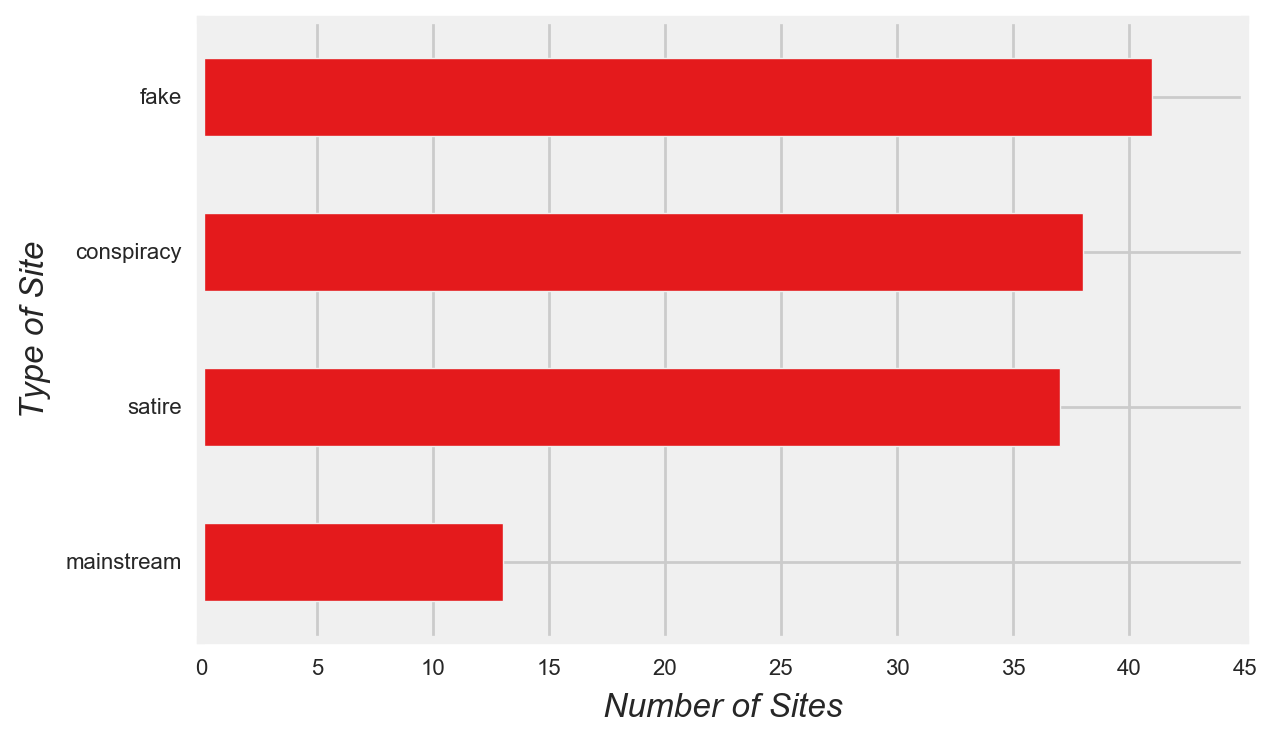

In [12]:
# Plot count of each type of page analyzed
print "Total number of Facebook pages with posts analyzed: ", len(fb_news_total['fb_id'].unique())
fb_news_total.groupby(['type'])['fb_id'].unique().map(lambda x: len(x)).sort_values().plot(kind='barh',color='#e41a1c')
plt.ylabel("Type of Site",style='italic')
plt.xlabel("Number of Sites",style='italic')
plt.tick_params(axis='both', which='major', labelsize=8)

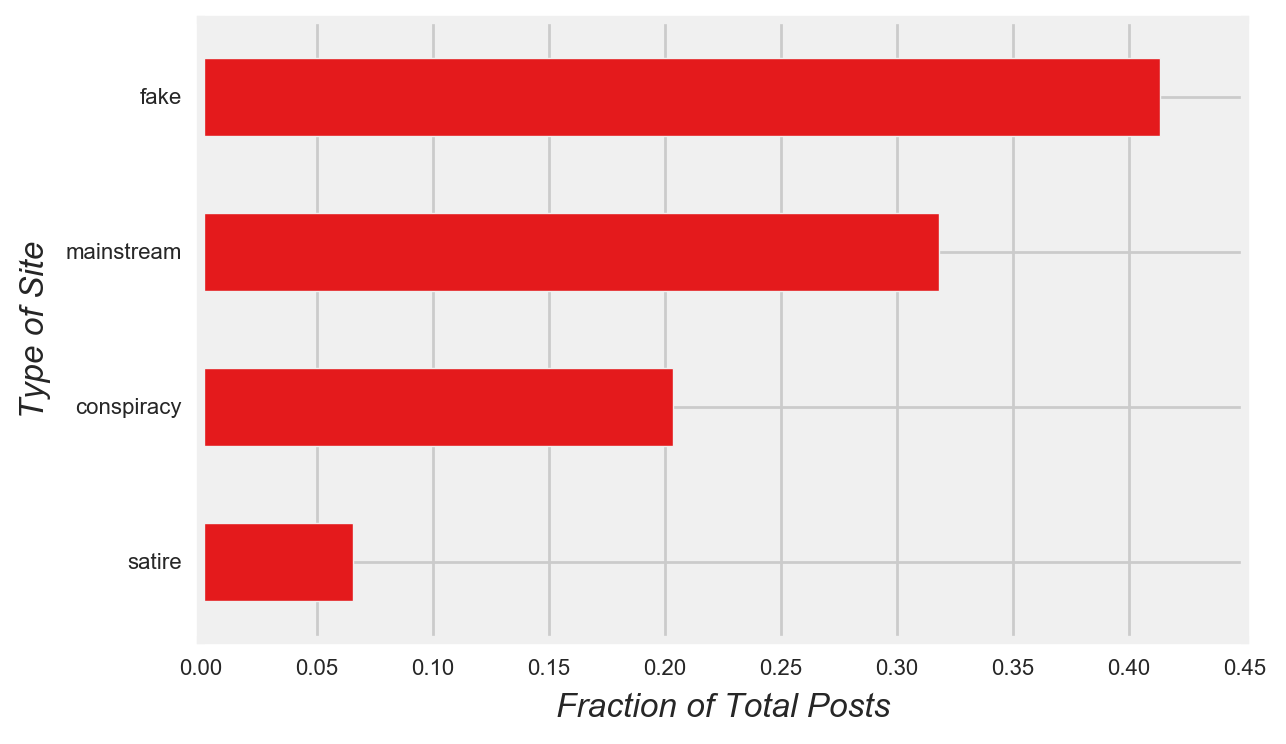

In [13]:
# Plot proportion of posts by type
((1.*fb_news_total.groupby(['type'])['p_key'].count())/len(fb_news_total['p_key'])).sort_values().plot(kind='barh',color='#e41a1c')
plt.ylabel("Type of Site",style='italic')
plt.xlabel("Fraction of Total Posts",style='italic')
plt.tick_params(axis='both', which='major', labelsize=8)

In [14]:
# List mainstream pages analyzed in the project
temp=fb_news_total.ix[fb_news_total['type']=='mainstream','fb_id'].unique()
print "Number of mainstream sites: ",len(temp)
print temp

Number of mainstream sites:  13
['nytimes' 'wsj' 'ABCNews' 'CBSNews' 'cnn' 'usatoday' 'washingtonpost'
 'msnbc' 'newyorker' 'yahoonews' 'FoxNews' 'NPR' 'newshour']


In [15]:
# List fake pages analyzed in the project
temp=fb_news_total.ix[fb_news_total['type']=='fake','fb_id'].unique()
print "Number of fake sites: ",len(temp)
print temp

Number of fake sites:  41
['worldrumor' 'FreshNews000' 'TheRightists' 'subjectpolitics'
 'weeklyworldnews' 'USPoliticsLive' 'DcGazette' 'FreedomDailyNews'
 'EmpireNewsNet' 'Newslo1' 'NewsWithViews' 'supremepatriot'
 'StormCloudsGathering' 'DHeadlines' 'newsexaminer.net' '24Newsflash'
 'LastGreatStand' 'eutopiabuzz' 'conservativeinfidel'
 'ThreePercenterNation' 'TheUndergroundWorldNews' 'RHobbusJD'
 'downtrendcom' 'intrendtoday' 'ClashDaily' 'worldstoriestoday'
 'TheAdoboChronicles' 'beforeitsnewscom' 'DonaldTrumpNews.Co' 'hmakow'
 'pakalertpress' 'usasupreme' 'rilenews' 'RickRWells' 'usanewsoftheday'
 'yesiamright' 'proudcons' 'conservativebyte' 'politicalsitenews' 'prntly'
 'OnlineConservativePress']


In [16]:
# List conspiracy pages analyzed in the project
temp=fb_news_total.ix[fb_news_total['type']=='conspiracy','fb_id'].unique()
print "Number of conspiracy sites: ",len(temp)
print temp

Number of conspiracy sites:  38
['pamelageller' 'fprnradio' 'americanfreepress' 'LibertyTalkFM'
 'TheMindUnleashed' 'adeptoerperfectus' 'Gaia' 'conservativerefocusgroup'
 'CanadaFreePress' 'concisepolitics' 'ThePoliticalInsider'
 'DisclosureMedia' 'TheSilverDoctors' '21WIRE.TV' 'atsnews' 'activistpost'
 'EyeOpeningInfo' 'freedomoutpost' 'GlobalResearchCRG' 'govtslaves'
 'HumansAreFree' 'investmentresearchdynamics' 'intelligencehub'
 'NewsTargetOfficial' 'NowTheEndBegins' 'theprepperwebsite'
 'SECRETSofTheFED' 'thedailysheeple' 'theeventhandbook'
 'TruthBroadcastNetworkcom' 'truth.frequency.radio' 'ufoholics'
 'zerohedge1' 'SilverCoinInvestor' 'LibertyMovementRadio' 'BradleeDeanSOL'
 'TheLibertyBeaconProject' 'AwarenessAct']


In [17]:
# List satire pages analyzed in the project
temp=fb_news_total.ix[fb_news_total['type']=='satire','fb_id'].unique()
print "Number of satire sites: ",len(temp)
print temp

Number of satire sites:  37
['TheHolyObserver' 'NewsToad' 'associatedmediacoverage' 'dailycurrant'
 'theineptowl' 'betootaadvocate' 'clickhole' 'disclosetv' 'elmundotoday'
 'Gomerblog' 'NewsBiscuit' 'NewsThump' 'Reductress' 'TheOnion'
 'theunrealpage' 'WhispersNews' 'goingwunderground' 'FreeWoodPost'
 'worldnewsdailyreport' 'BeehiveBugle' 'thedandygoat' 'RockCityTimes'
 'CreamBmp' 'TheMadisonMisnomer' 'liberaldarkness' 'SportsPickle'
 'TheSkunkPage' 'stuppidcom' 'SatiraTribune' 'HumorTimes' 'blastingusa'
 'islamicanews' 'BurrardStreetJournal' 'thehardtimesnews' 'TheBeaverton'
 'FridayMash' 'TheCelebtricity']


Top 20 most prolific pages as a fraction of total posts:  0.5975
Top 20 pages with the most engagement counts as a fraction of total engagement:  0.9206


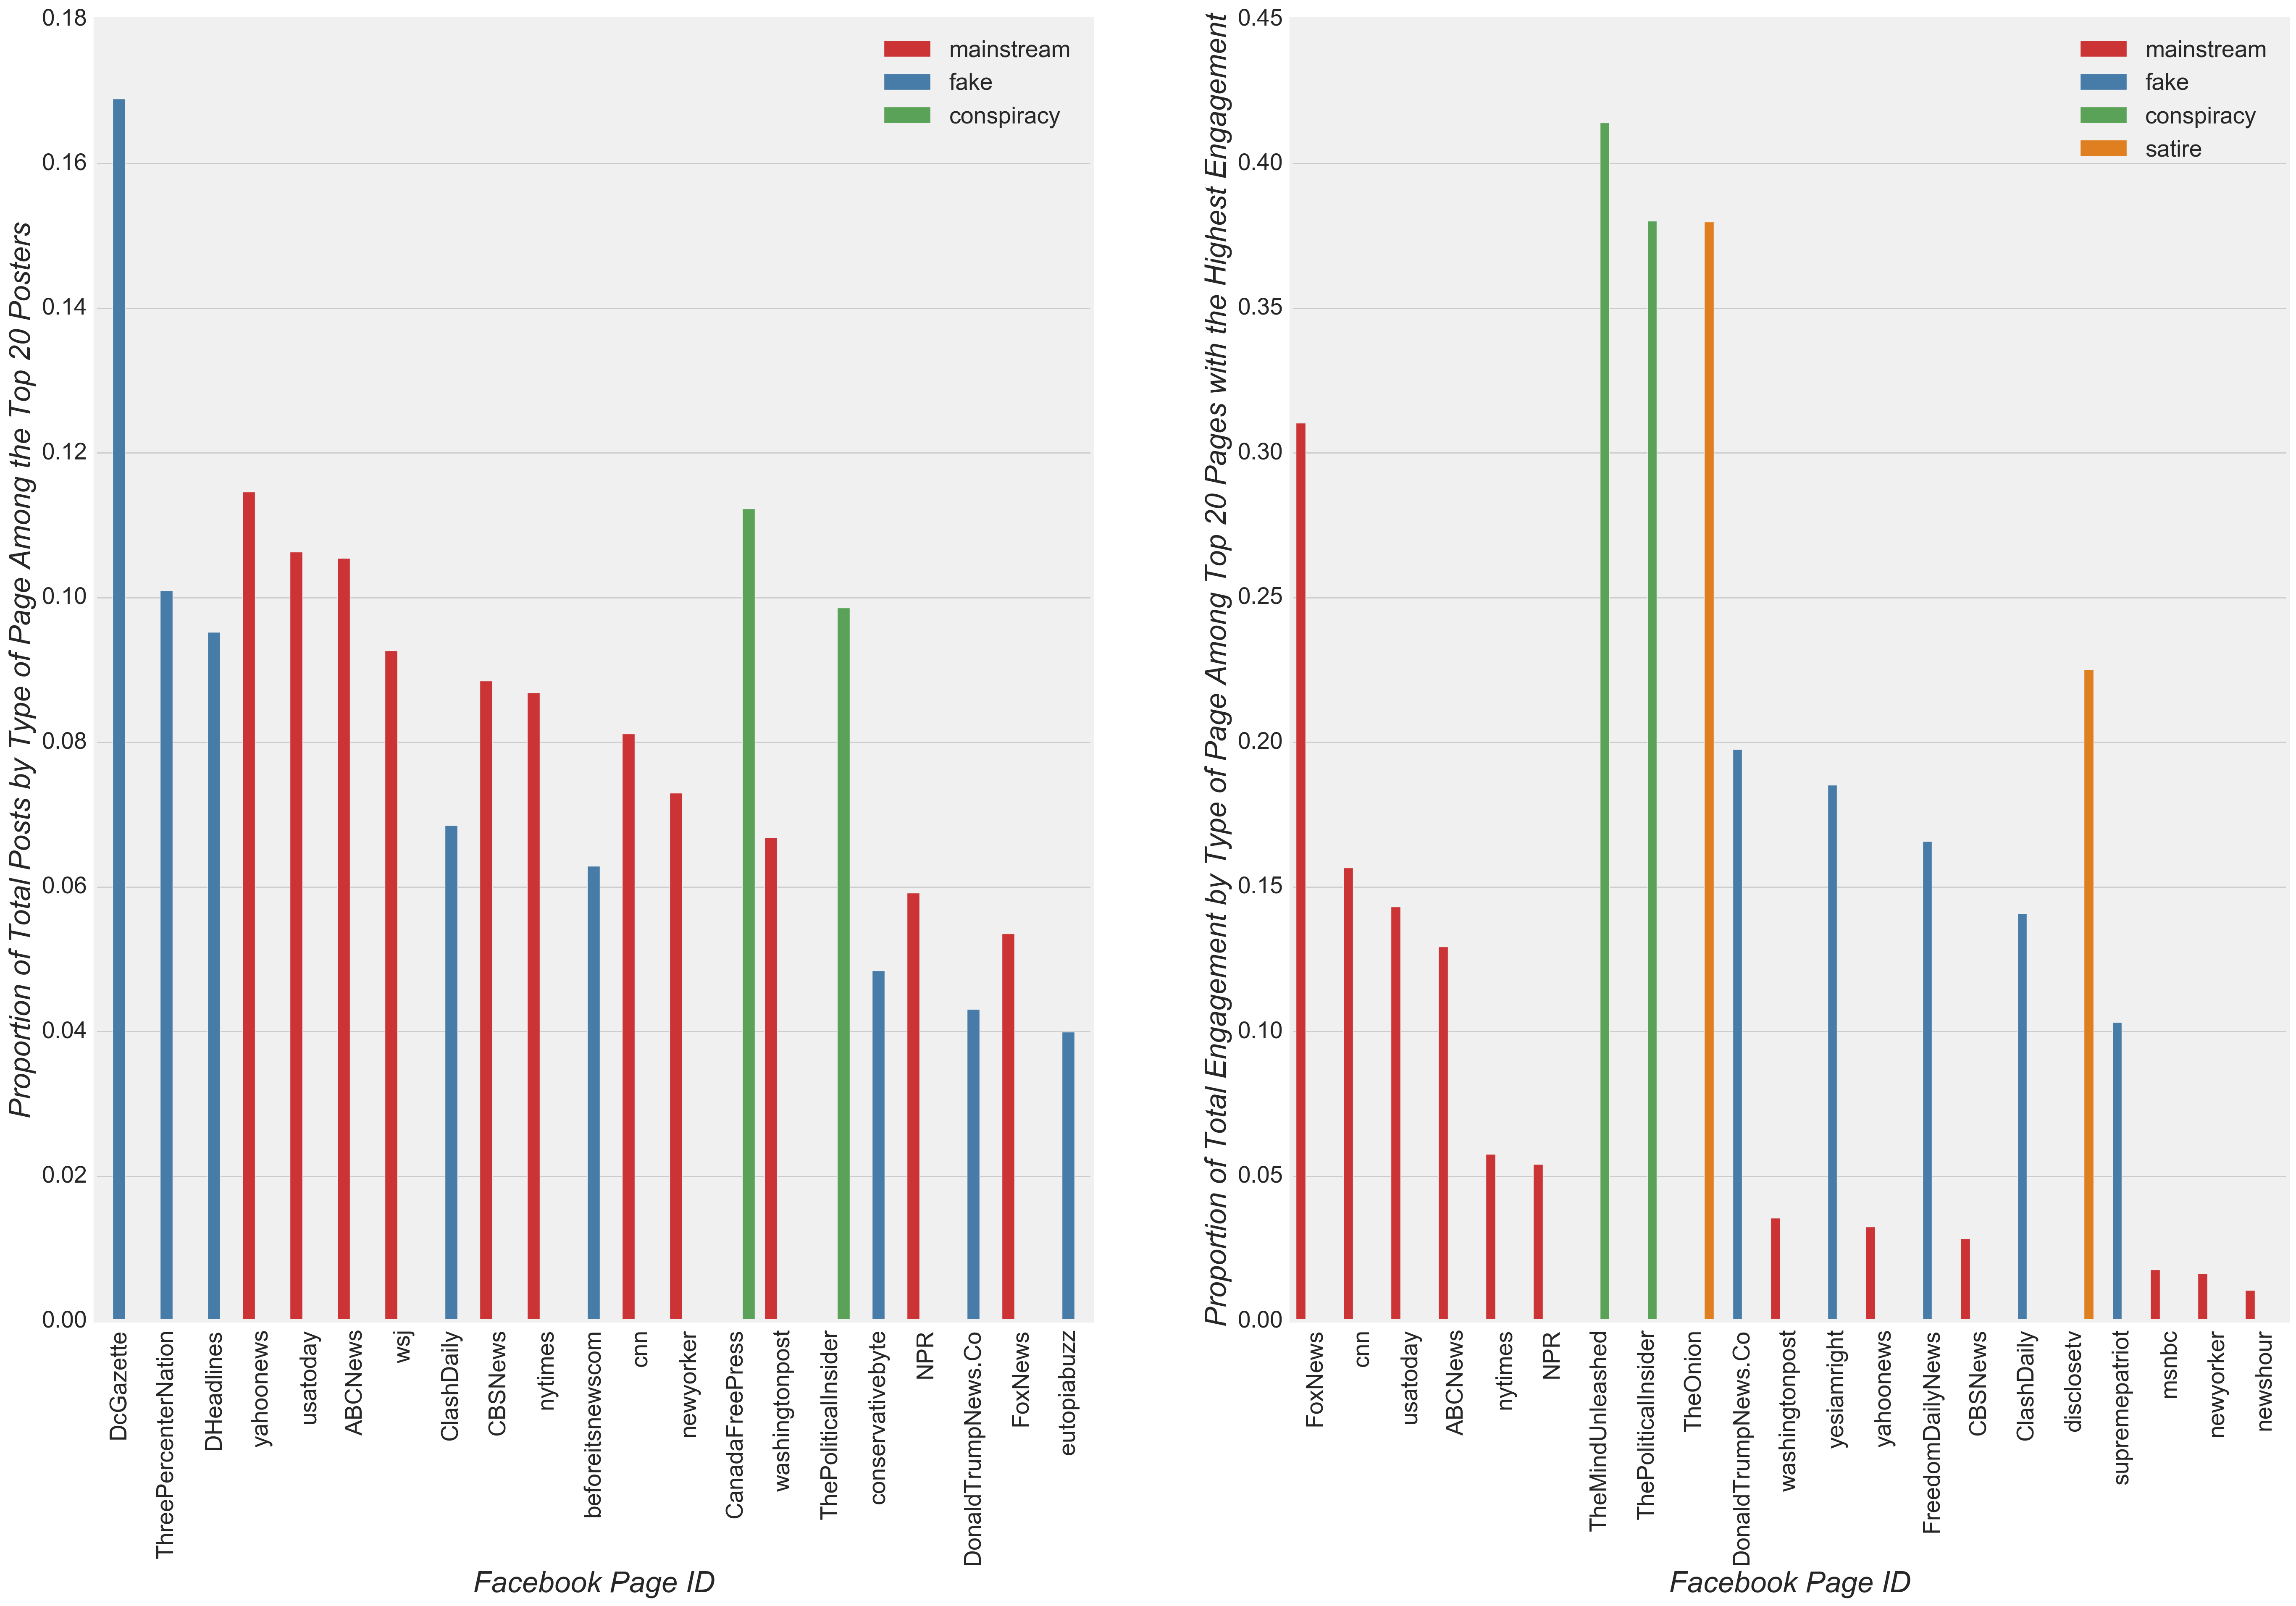

In [44]:
# Plot most prolific pages as a fraction of the total posts
temp=fb_news_total
temp['fraction']=0
for i,item in enumerate(list(temp['type'].unique())):
    temp.ix[temp['type']==item,'fraction']=(1./(temp[temp['type']==item].shape[0]))
    
summary=fb_news_total.groupby(['fb_id'])['p_key'].count().reset_index().sort_values(by='p_key',ascending=False).reset_index(drop=True)
top_posters=list(summary.ix[0:20,'fb_id'])

fig, (ax0,ax1) = plt.subplots(1,2, figsize=(30,20))
sns.barplot(x='fb_id', y='fraction',hue="type",data=temp[temp['fb_id'].isin(top_posters)],ax=ax0,estimator=np.sum,order=top_posters,ci=False,palette=['#e41a1c','#377eb8','#4daf4a','#ff7f00'])
ax0.set_ylabel("Proportion of Total Posts by Type of Page Among the Top 20 Posters",style='italic',fontsize=25)
ax0.set_xlabel("Facebook Page ID",style='italic',fontsize=25)
ax0.tick_params(axis='both', which='major', labelsize=20)
labels = ax0.get_xticklabels()
plt.setp(labels, rotation=90) 
ax0.legend(fontsize=20)
print "Top 20 most prolific pages as a fraction of total posts: ",round(((1.*sum(summary.ix[0:20,'p_key']))/temp.shape[0]),4)

# Plot pages with the most engagement as a fraction of total engagement
temp=fb_news_total
temp['fraction']=temp['all_interactions']
for i,item in enumerate(list(temp['type'].unique())):
    temp.ix[temp['type']==item,'fraction']=((1.*temp['fraction'])/(sum(temp.ix[temp['type']==item,'all_interactions'])))
summary=fb_news_total.groupby(['fb_id'])['all_interactions'].sum().reset_index().sort_values(by='all_interactions',ascending=False).reset_index(drop=True)
top_posters=list(summary.ix[0:20,'fb_id'])

sns.barplot(x='fb_id', y='fraction',hue="type",data=temp[temp['fb_id'].isin(top_posters)],ax=ax1,estimator=np.sum,order=top_posters,ci=False,palette=['#e41a1c','#377eb8','#4daf4a','#ff7f00'])
ax1.set_ylabel("Proportion of Total Engagement by Type of Page Among Top 20 Pages with the Highest Engagement",style='italic',fontsize=25)
ax1.set_xlabel("Facebook Page ID",style='italic',fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)
labels = ax1.get_xticklabels()
plt.setp(labels, rotation=90) 
ax1.legend(fontsize=20)
print "Top 20 pages with the most engagement counts as a fraction of total engagement: ",round(((1.*sum(summary.ix[0:20,'all_interactions']))/sum(temp['all_interactions'])),4)

plt.show()

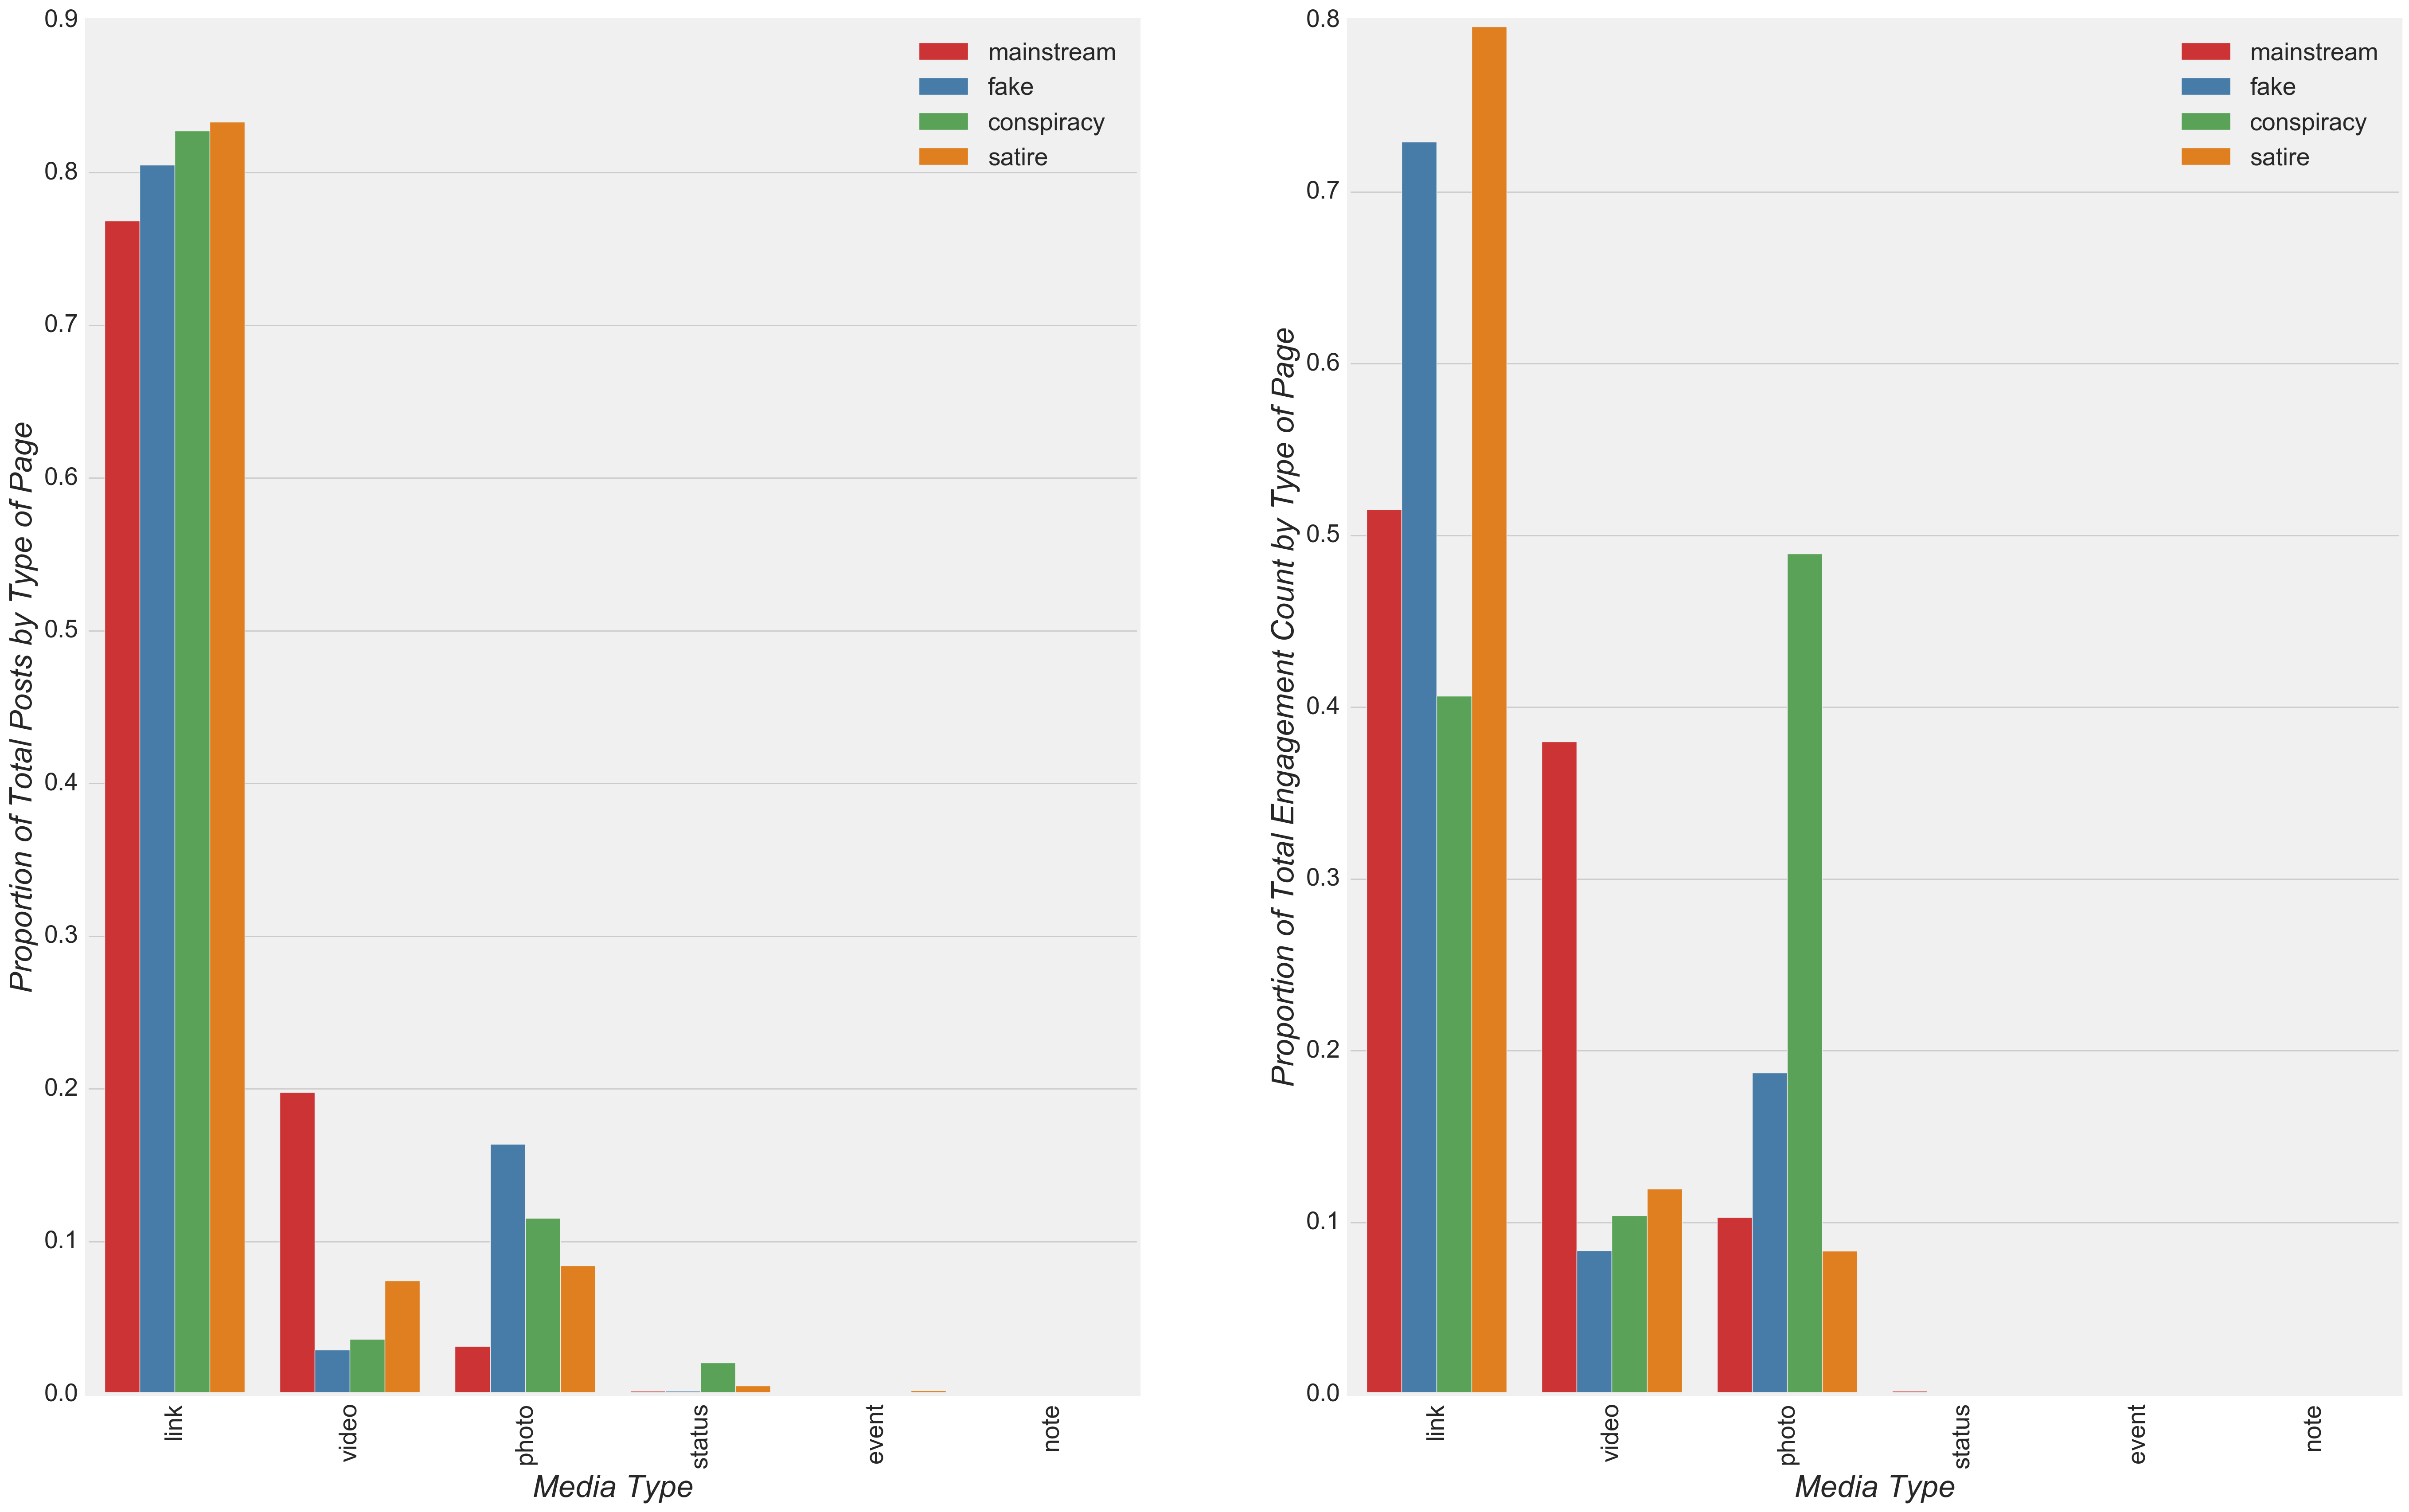

In [19]:
# Plot post counts by media type as a proportion of total post count
temp=fb_news_total
temp['fraction']=0
for i,item in enumerate(list(temp['type'].unique())):
    temp.ix[temp['type']==item,'fraction']=(1./(temp[temp['type']==item].shape[0]))
    
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(30,20))
sns.barplot(x='status_type', y='fraction',hue="type",data=temp,ax=ax0,estimator=np.sum,ci=False,palette=['#e41a1c','#377eb8','#4daf4a','#ff7f00'])
ax0.set_ylabel("Proportion of Total Posts by Type of Page",style='italic',fontsize=25)
ax0.set_xlabel("Media Type",style='italic',fontsize=25)
ax0.tick_params(axis='both', which='major', labelsize=20)
labels = ax0.get_xticklabels()
plt.setp(labels, rotation=90) 
ax0.legend(fontsize=20)

# Plot post engagement count by media type as a proportion of total engagement
temp=fb_news_total
temp['fraction']=temp['all_interactions']
for i,item in enumerate(list(temp['type'].unique())):
    temp.ix[temp['type']==item,'fraction']=((1.*temp['fraction'])/(sum(temp.ix[temp['type']==item,'all_interactions'])))

sns.barplot(x='status_type', y='fraction',hue="type",data=temp,ax=ax1,estimator=np.sum,ci=False,palette=['#e41a1c','#377eb8','#4daf4a','#ff7f00'])
ax1.set_ylabel("Proportion of Total Engagement Count by Type of Page",style='italic',fontsize=25)
ax1.set_xlabel("Media Type",style='italic',fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)
labels = ax1.get_xticklabels()
plt.setp(labels, rotation=90) 
ax1.legend(fontsize=20)

plt.show()

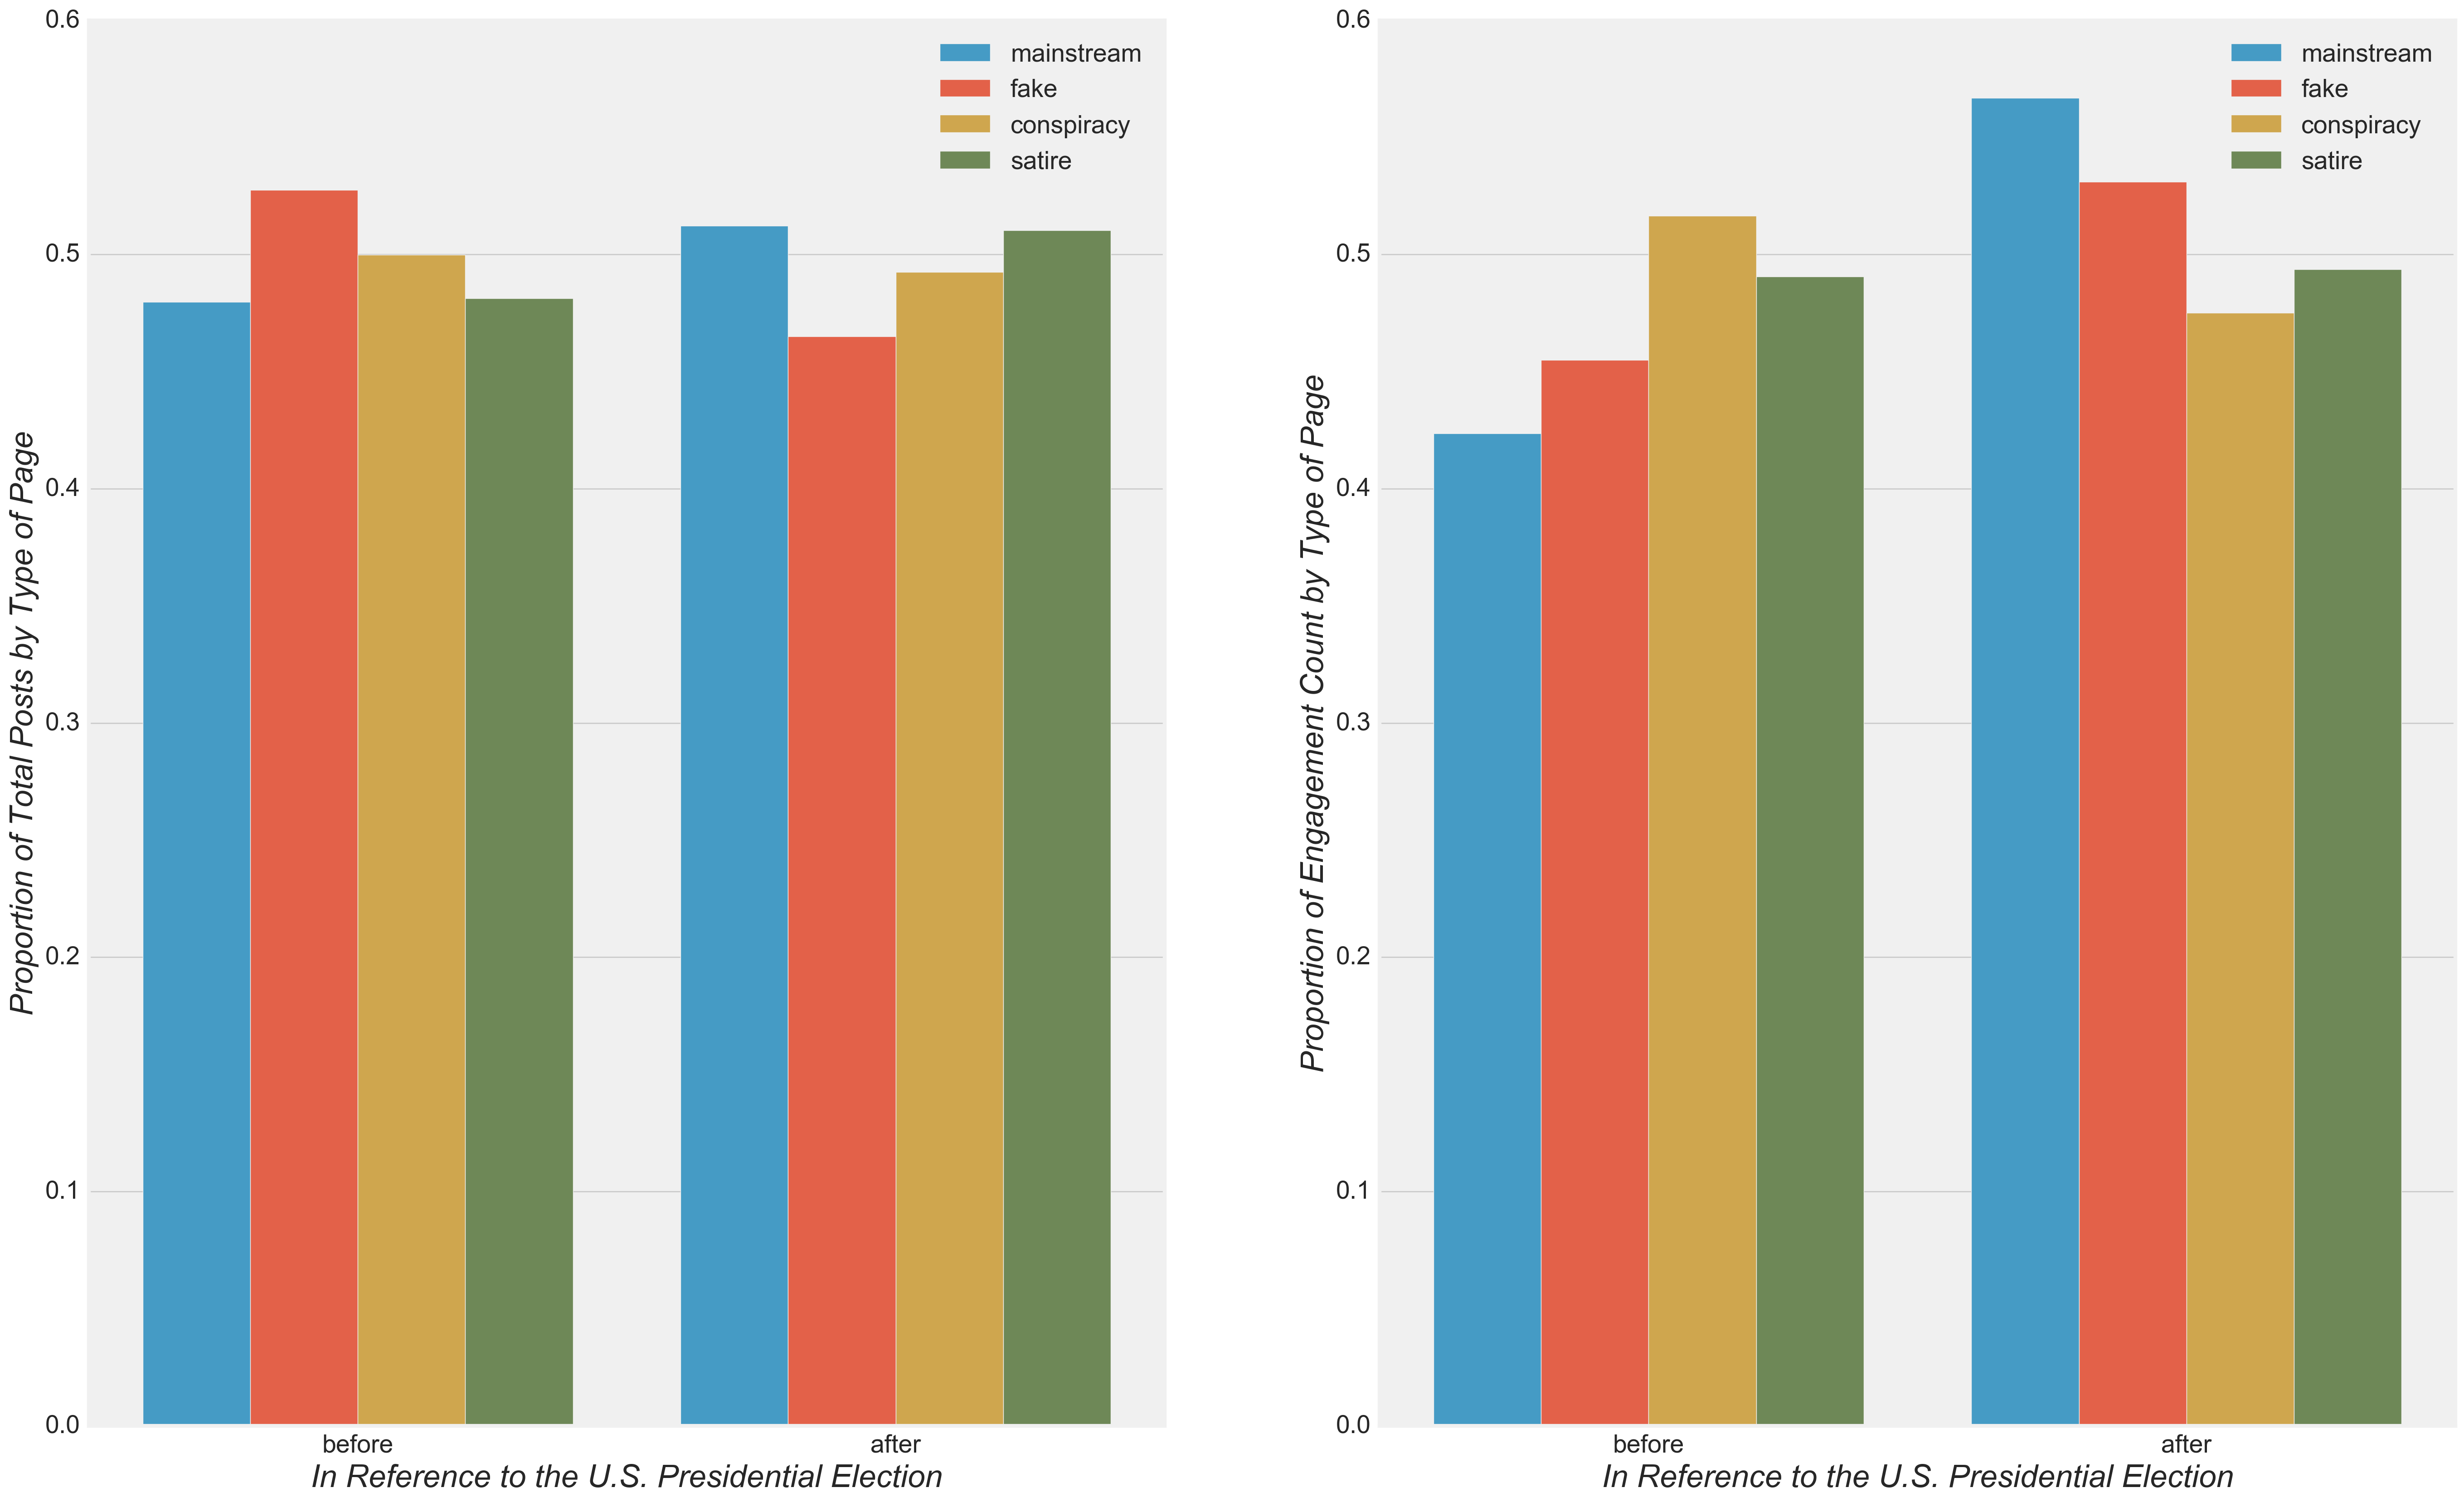

In [20]:
# Plot count of posts before and after the U.S. Presidential election as a proportion of all posts
temp=fb_news_total
temp['prop_total']=0
for i,item in enumerate(list(temp['type'].unique())):
    temp.ix[temp['type']==item,'prop_total']=(1./(temp[temp['type']==item].shape[0]))

fig, (ax0,ax1) = plt.subplots(1,2, figsize=(30,20))
sns.barplot(x='election_day', y='prop_total',hue="type",ax=ax0,data=temp[temp['election_day']!='same'],order=['before','after'],estimator=np.sum,ci=False)
ax0.set_ylabel("Proportion of Total Posts by Type of Page",style='italic',fontsize=25)
ax0.set_xlabel("In Reference to the U.S. Presidential Election",style='italic',fontsize=25)
ax0.tick_params(axis='both', which='major', labelsize=20)
ax0.legend(loc="best",fontsize=20)

# Plot engagement sum before and after the U.S. Presidential election as a proportion of the total engagement
temp['prop_total']=temp['all_interactions']
for i,item in enumerate(list(temp['type'].unique())):
    temp.ix[temp['type']==item,'prop_total']=((1.*temp['prop_total'])/(sum(temp.ix[temp['type']==item,'prop_total'])))
    
sns.barplot(x='election_day', y='prop_total', hue='type',order=['before','after'],ax=ax1,data=fb_news_total[fb_news_total['election_day']!='same'],estimator=np.sum,ci=False)
ax1.set_ylabel("Proportion of Engagement Count by Type of Page",style='italic',fontsize=25)
ax1.set_xlabel("In Reference to the U.S. Presidential Election",style='italic',fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.legend(loc="best",fontsize=20)

Total sources active before election:  40
Total sources active after election:  38
Sum of news sources with counts of posts before the election is greater than the counts after: 21


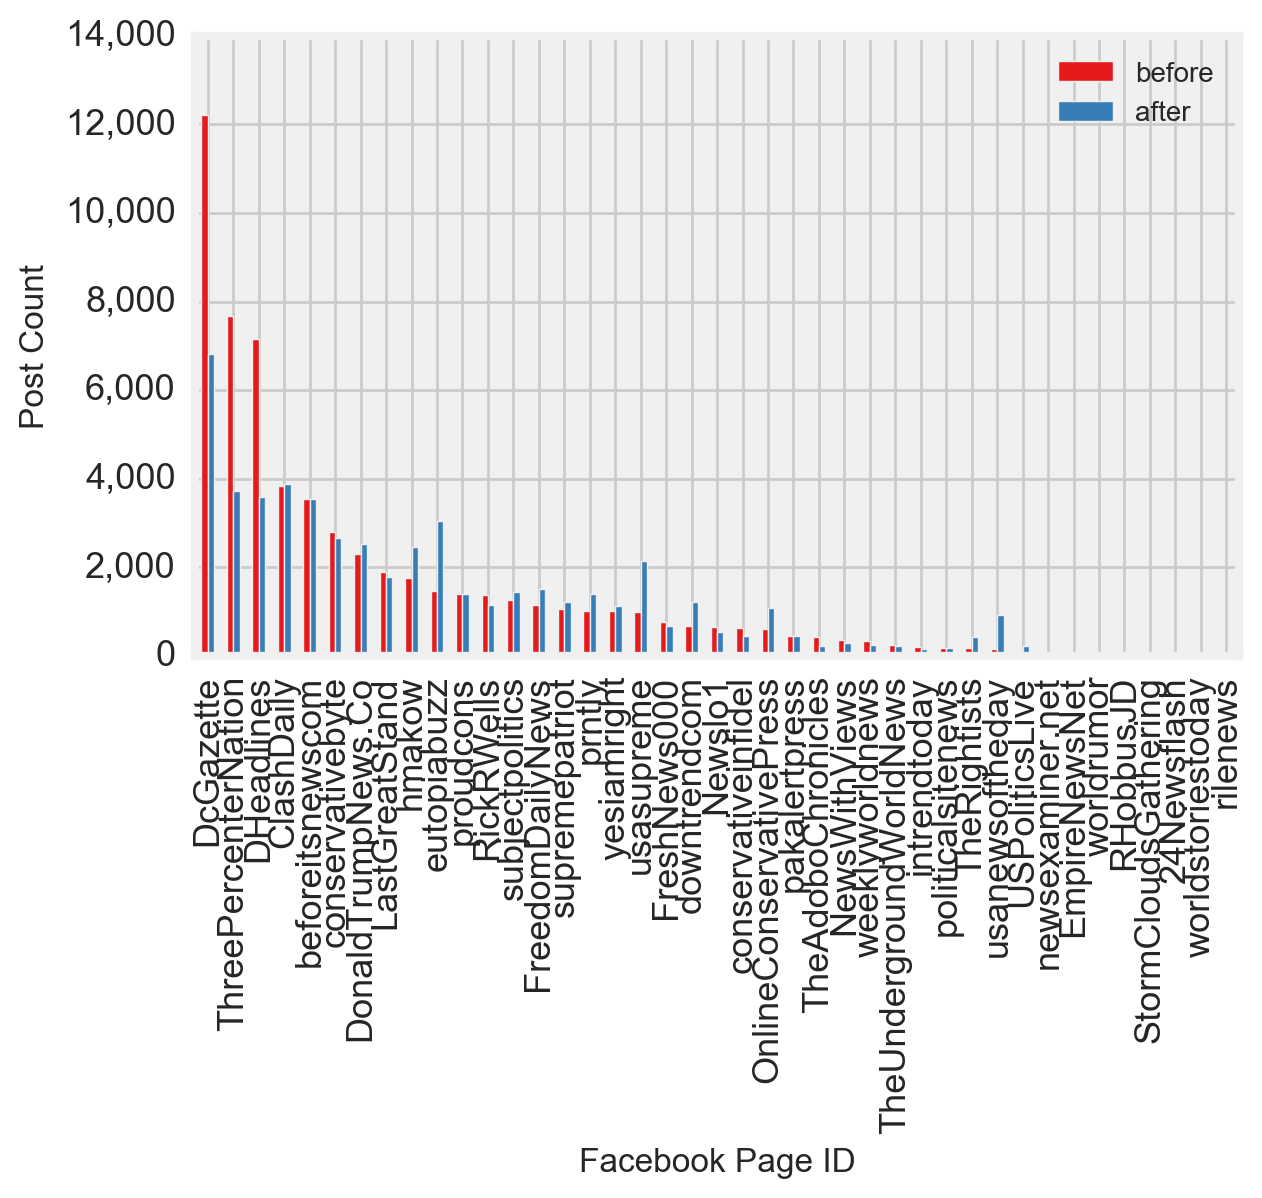

In [24]:
# Plot post counts for each fake news page to identify the reason why more fake news was posted before the election
temp=fb_news_total[fb_news_total['election_day']!='same']
temp=temp[temp['type']=='fake'].groupby(['fb_id','election_day'])['p_key'].agg('count').unstack()
temp[temp.isnull()]=0
temp=temp[['before','after']]
print "Total sources active before election: ",len(temp.ix[temp['before']>0,'before'])
print "Total sources active after election: ",len(temp.ix[temp['after']>0,'after'])
print "Sum of news sources with counts of posts before the election is greater than the counts after:",sum(temp['before']>temp['after'])
del temp.columns.name

plot=temp.sort_values(['before','after'],ascending=False).plot(kind='bar',stacked=False,color=['#e41a1c','#377eb8'])
plot.tick_params(axis='both', which='major', labelsize=13)
plot.set(xlabel='Facebook Page ID', ylabel='Post Count')
plot.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,p: format(int(y), ',')))
plt.show()

Total sources active before election:  13
Total sources active after election:  13


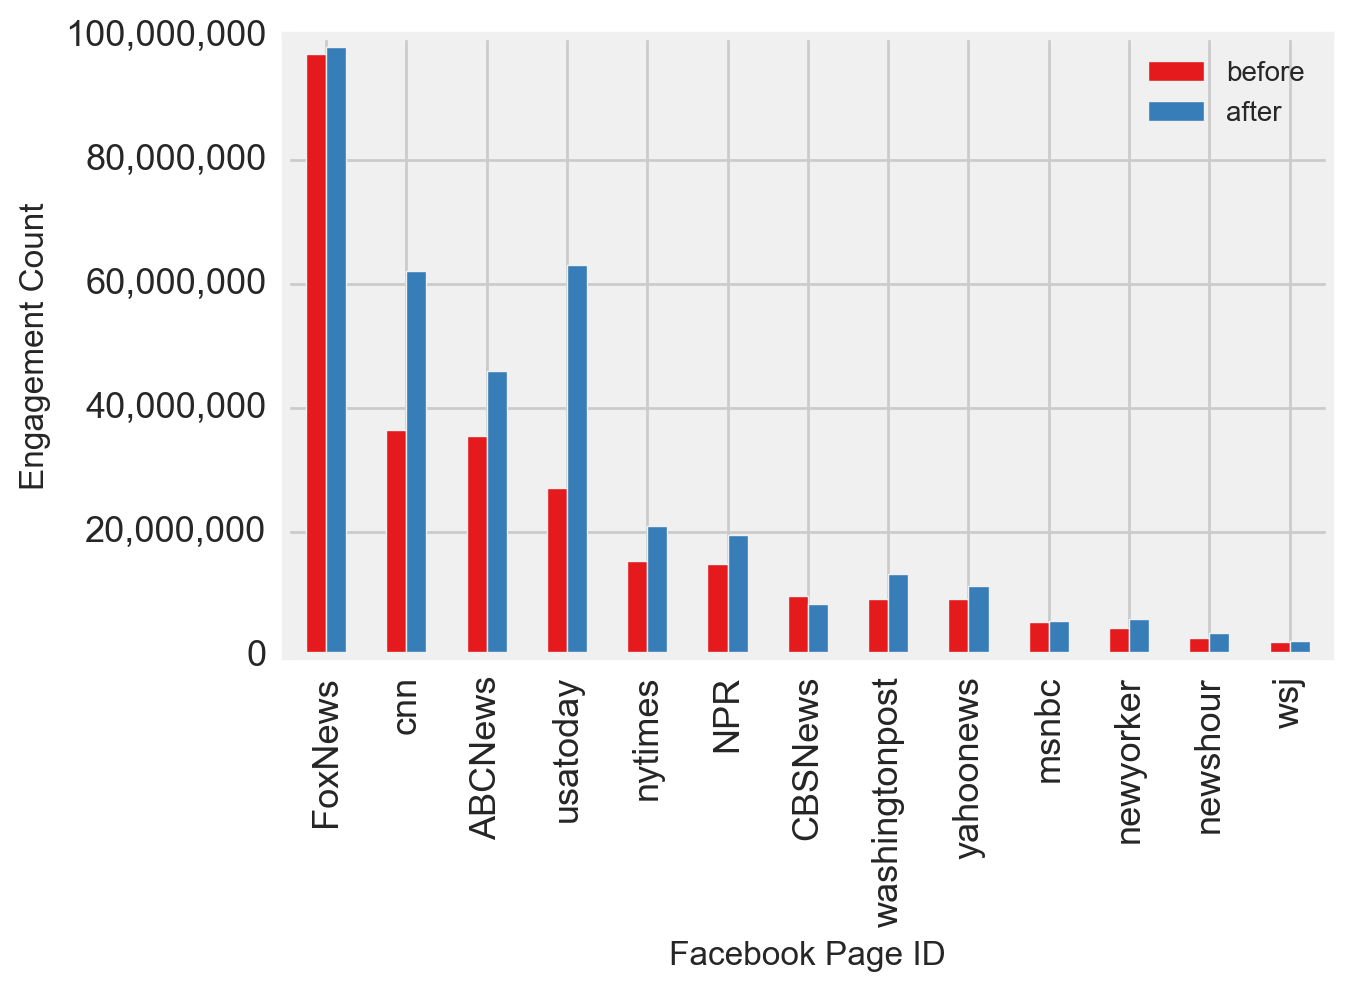

In [26]:
# Plot engagement for each mainstream news page to explain why substantially more engagement was observed after the
# election
temp=fb_news_total[fb_news_total['election_day']!='same']
temp=temp[temp['type']=='mainstream'].groupby(['fb_id','election_day'])['all_interactions'].agg(np.sum).unstack()
temp[temp.isnull()]=0
temp=temp[['before','after']]
print "Total sources active before election: ",len(temp.ix[temp['before']>0,'before'])
print "Total sources active after election: ",len(temp.ix[temp['after']>0,'after'])
del temp.columns.name

plot=temp.sort_values(['before','after'],ascending=False).plot(kind='bar',stacked=False,color=['#e41a1c','#377eb8'])
plot.tick_params(axis='both', which='major', labelsize=13)
plot.set(xlabel='Facebook Page ID', ylabel='Engagement Count')
plot.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,p: format(int(y), ',')))
plt.show()

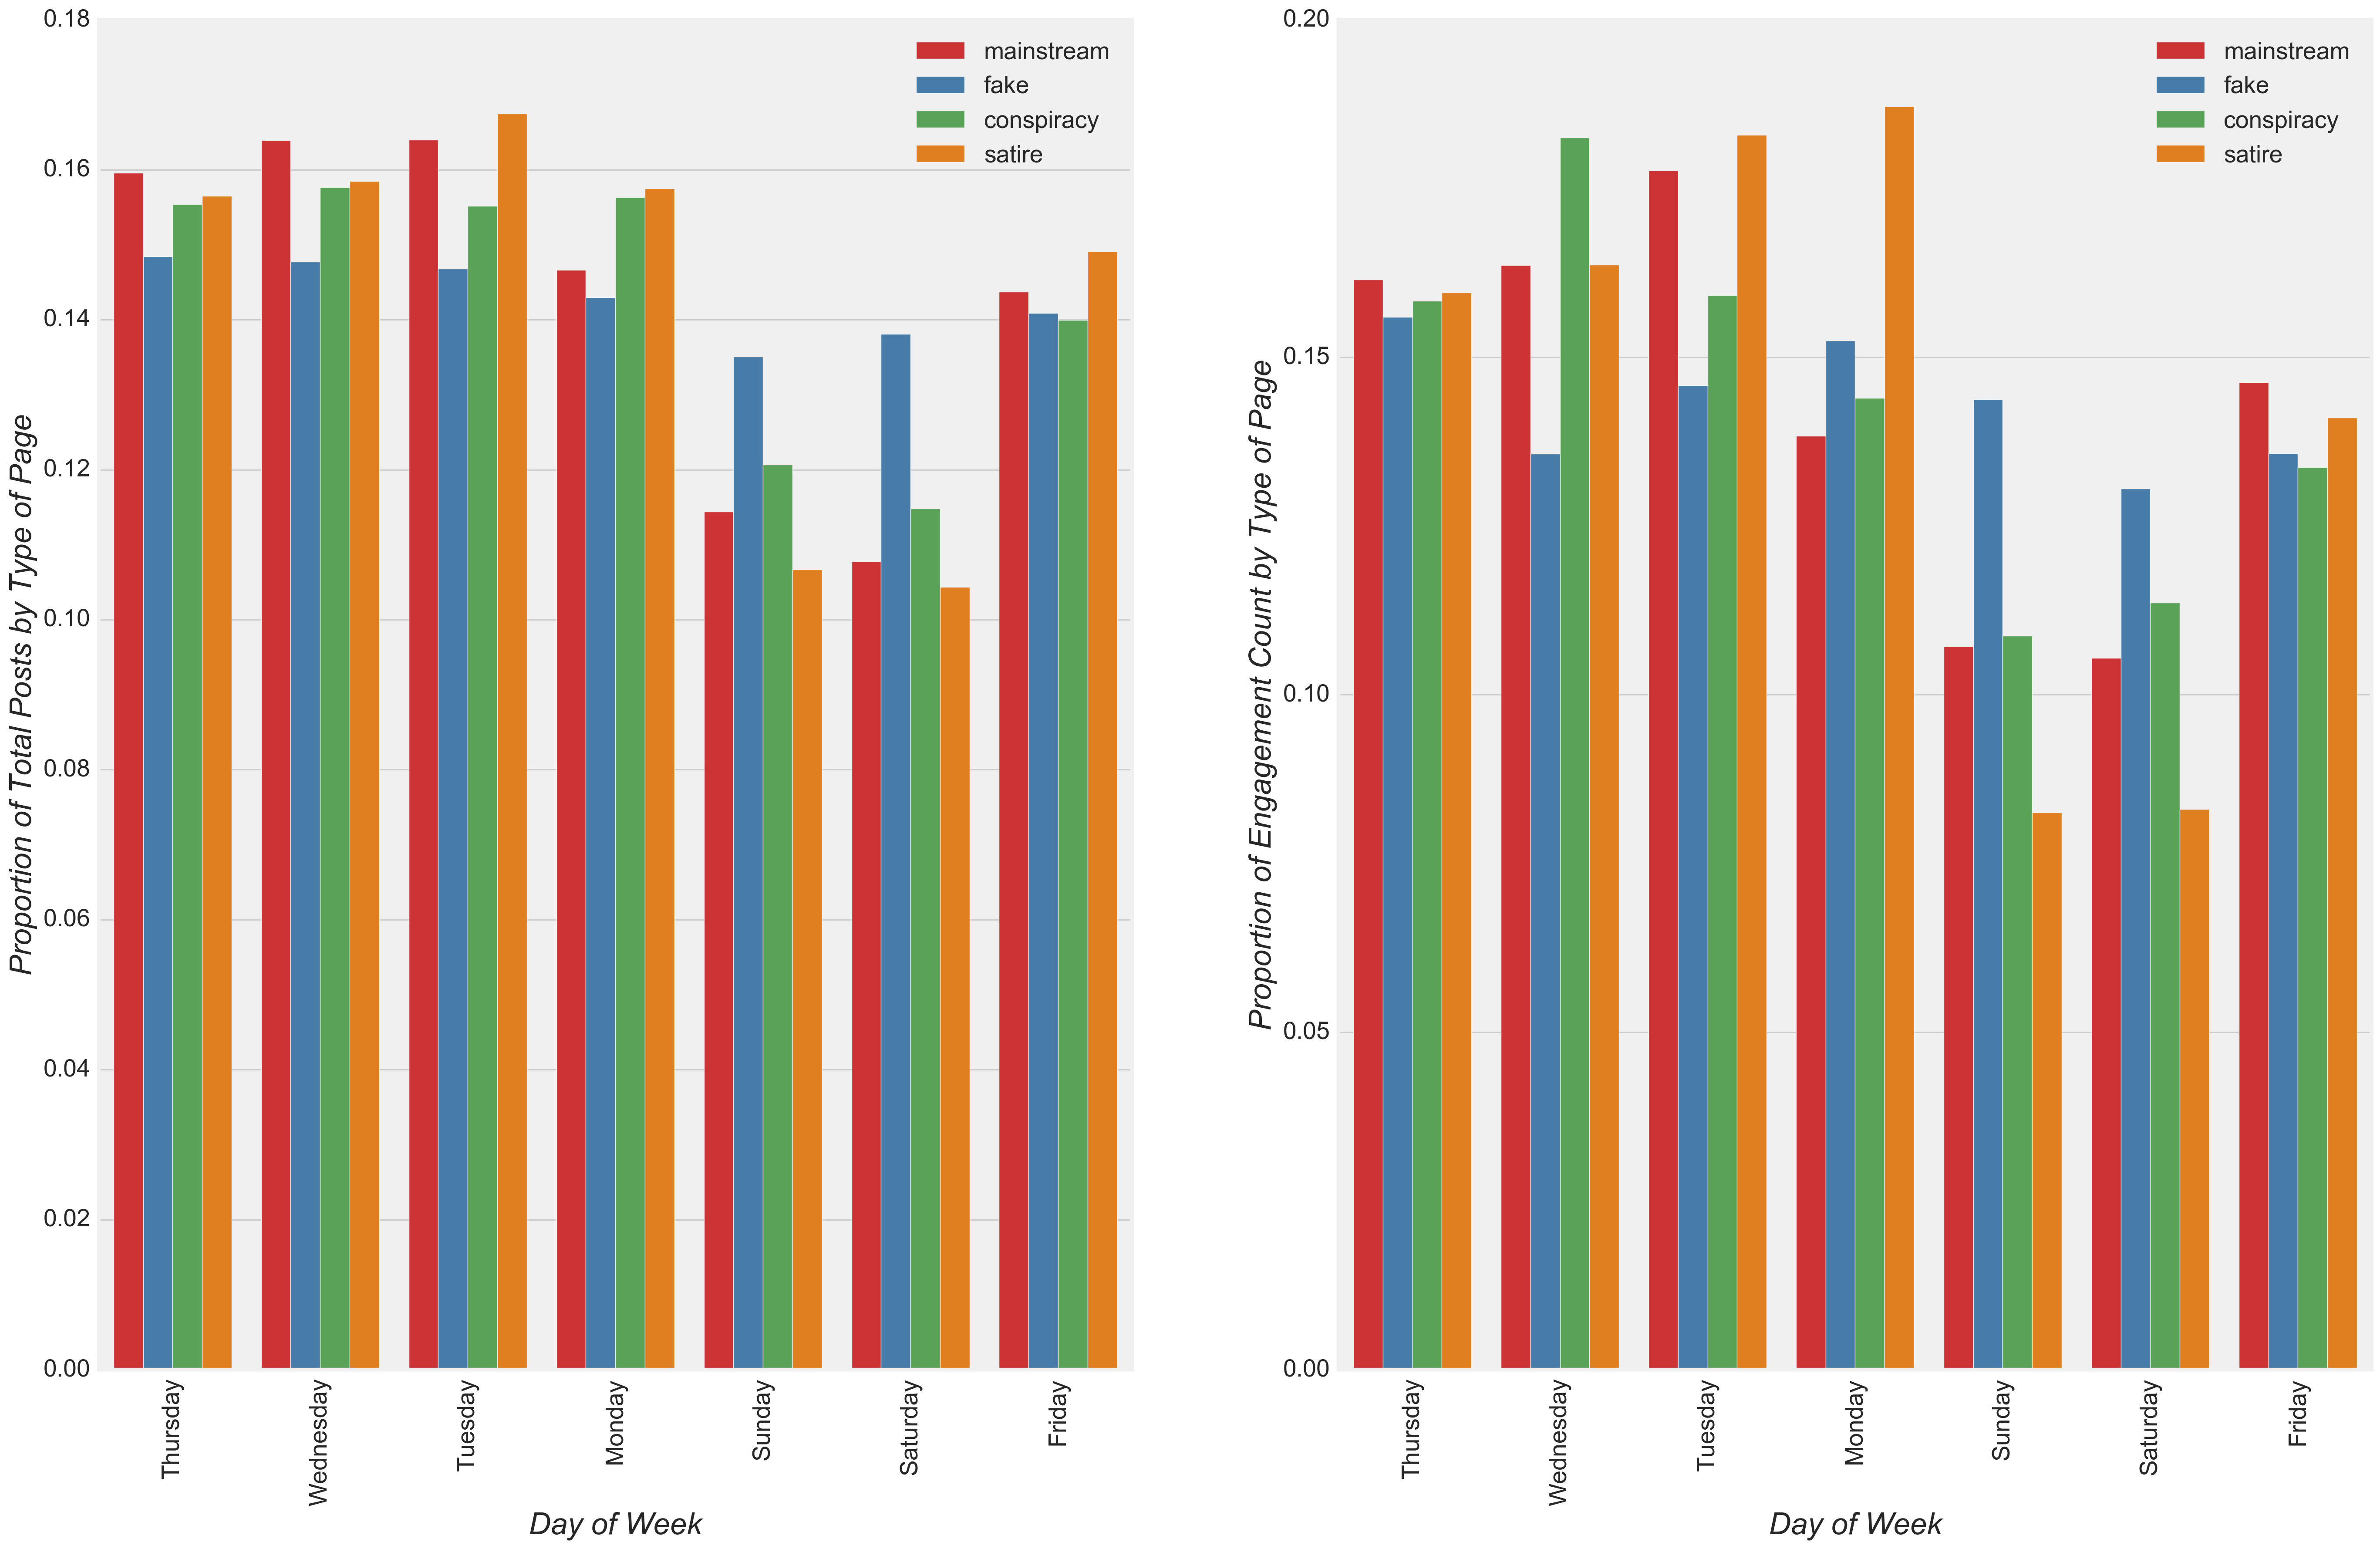

In [27]:
# Plot post count by day of the week as a proportion of total post count
temp=fb_news_total
temp['fraction']=0
for i,item in enumerate(list(temp['type'].unique())):
    temp.ix[temp['type']==item,'fraction']=(1./(temp[temp['type']==item].shape[0]))
    
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(30,20))
sns.barplot(x='day_of_week', y='fraction',hue="type",data=temp,ax=ax0,estimator=np.sum,ci=False,palette=['#e41a1c','#377eb8','#4daf4a','#ff7f00'])
ax0.set_ylabel("Proportion of Total Posts by Type of Page",style='italic',fontsize=25)
ax0.set_xlabel("Day of Week",style='italic',fontsize=25)
ax0.tick_params(axis='both', which='major', labelsize=20)
labels = ax0.get_xticklabels()
plt.setp(labels, rotation=90) 
ax0.legend(fontsize=20)

# Plot post engagement count by day of the week as a proportion of total engagement 
temp=fb_news_total
temp['fraction']=temp['all_interactions']
for i,item in enumerate(list(temp['type'].unique())):
    temp.ix[temp['type']==item,'fraction']=((1.*temp['fraction'])/(sum(temp.ix[temp['type']==item,'all_interactions'])))

sns.barplot(x='day_of_week', y='fraction',hue="type",data=temp,ax=ax1,estimator=np.sum,ci=False,palette=['#e41a1c','#377eb8','#4daf4a','#ff7f00'])
ax1.set_ylabel("Proportion of Engagement Count by Type of Page",style='italic',fontsize=25)
ax1.set_xlabel("Day of Week",style='italic',fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)
labels = ax1.get_xticklabels()
plt.setp(labels, rotation=90) 
ax1.legend(fontsize=20)

plt.show()

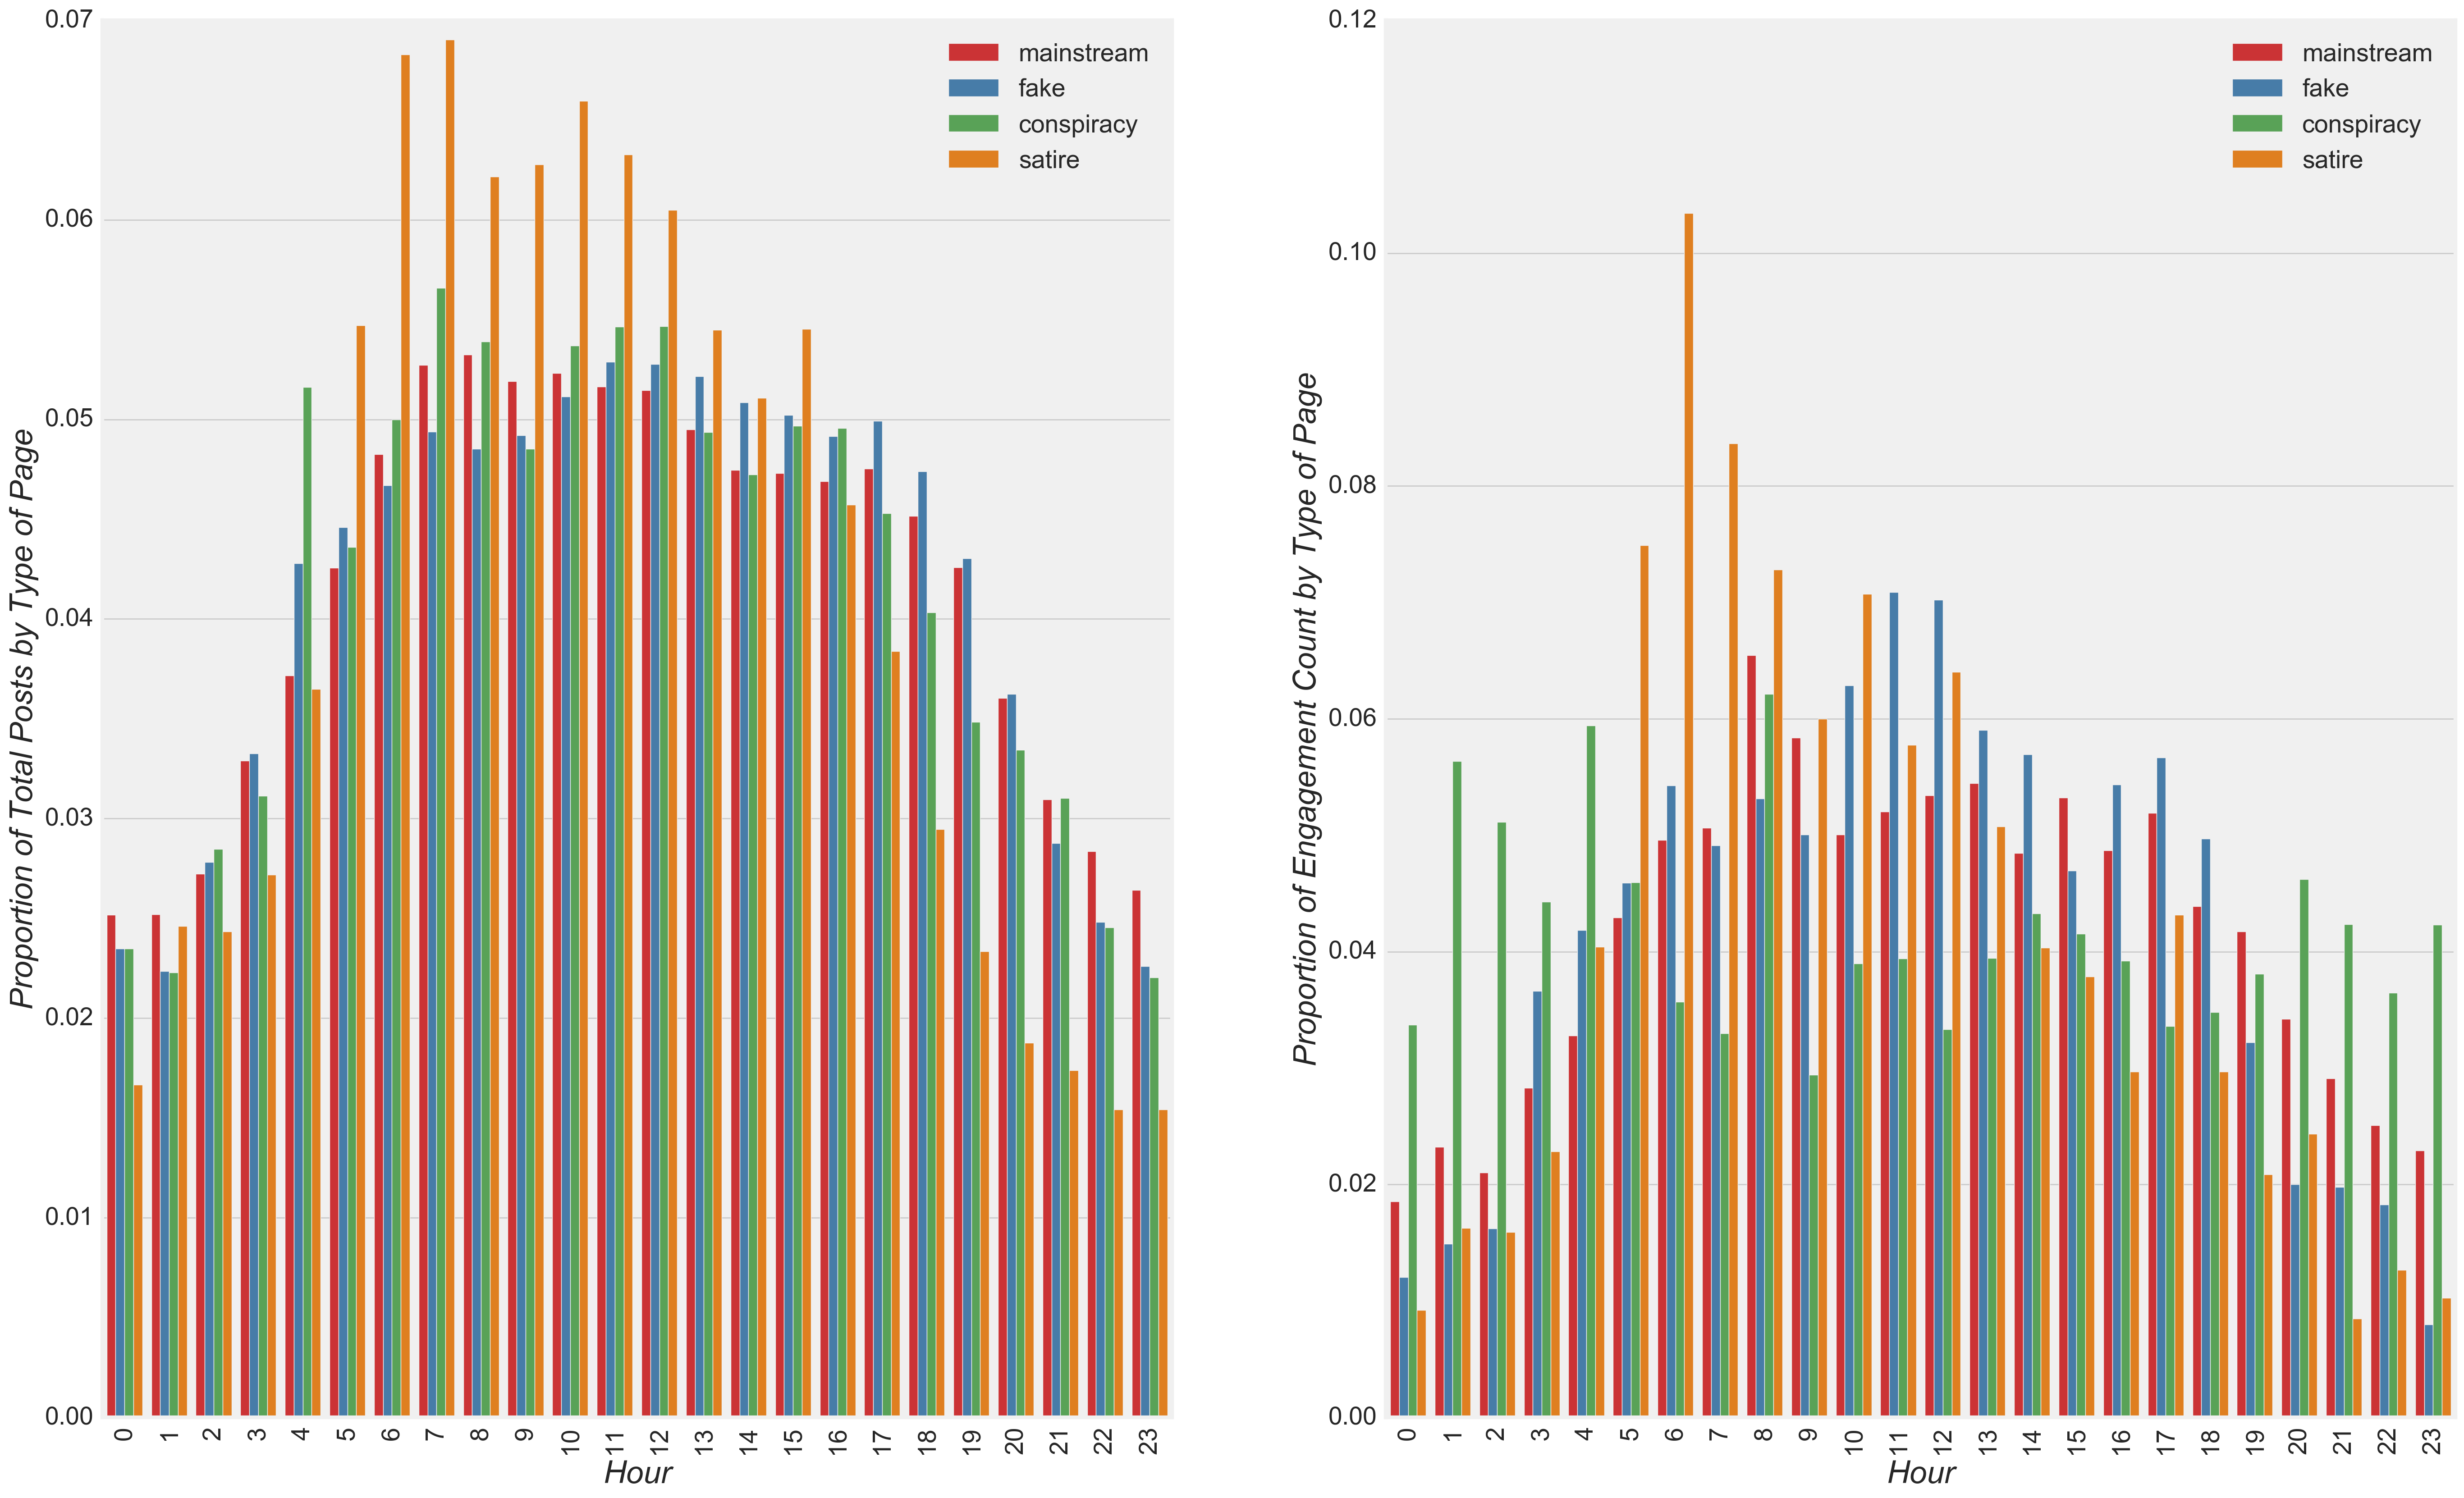

In [29]:
# Plot post counts by hour as a proportion of total post count
temp=fb_news_total
temp['fraction']=0
for i,item in enumerate(list(temp['type'].unique())):
    temp.ix[temp['type']==item,'fraction']=(1./(temp[temp['type']==item].shape[0]))
    
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(30,20))
sns.barplot(x='hour', y='fraction',hue="type",data=temp,ax=ax0,estimator=np.sum,ci=False,palette=['#e41a1c','#377eb8','#4daf4a','#ff7f00'])
ax0.set_ylabel("Proportion of Total Posts by Type of Page",style='italic',fontsize=25)
ax0.set_xlabel("Hour",style='italic',fontsize=25)
ax0.tick_params(axis='both', which='major', labelsize=20)
labels = ax0.get_xticklabels()
plt.setp(labels, rotation=90) 
ax0.legend(fontsize=20)

# Plot post engagement count by hour as a proportion of total engagement count
temp=fb_news_total
temp['fraction']=temp['all_interactions']
for i,item in enumerate(list(temp['type'].unique())):
    temp.ix[temp['type']==item,'fraction']=((1.*temp['fraction'])/(sum(temp.ix[temp['type']==item,'all_interactions'])))

sns.barplot(x='hour', y='fraction',hue="type",data=temp,ax=ax1,estimator=np.sum,ci=False,palette=['#e41a1c','#377eb8','#4daf4a','#ff7f00'])
ax1.set_ylabel("Proportion of Engagement Count by Type of Page",style='italic',fontsize=25)
ax1.set_xlabel("Hour",style='italic',fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)
labels = ax1.get_xticklabels()
plt.setp(labels, rotation=90) 
ax1.legend(fontsize=20)

plt.show()

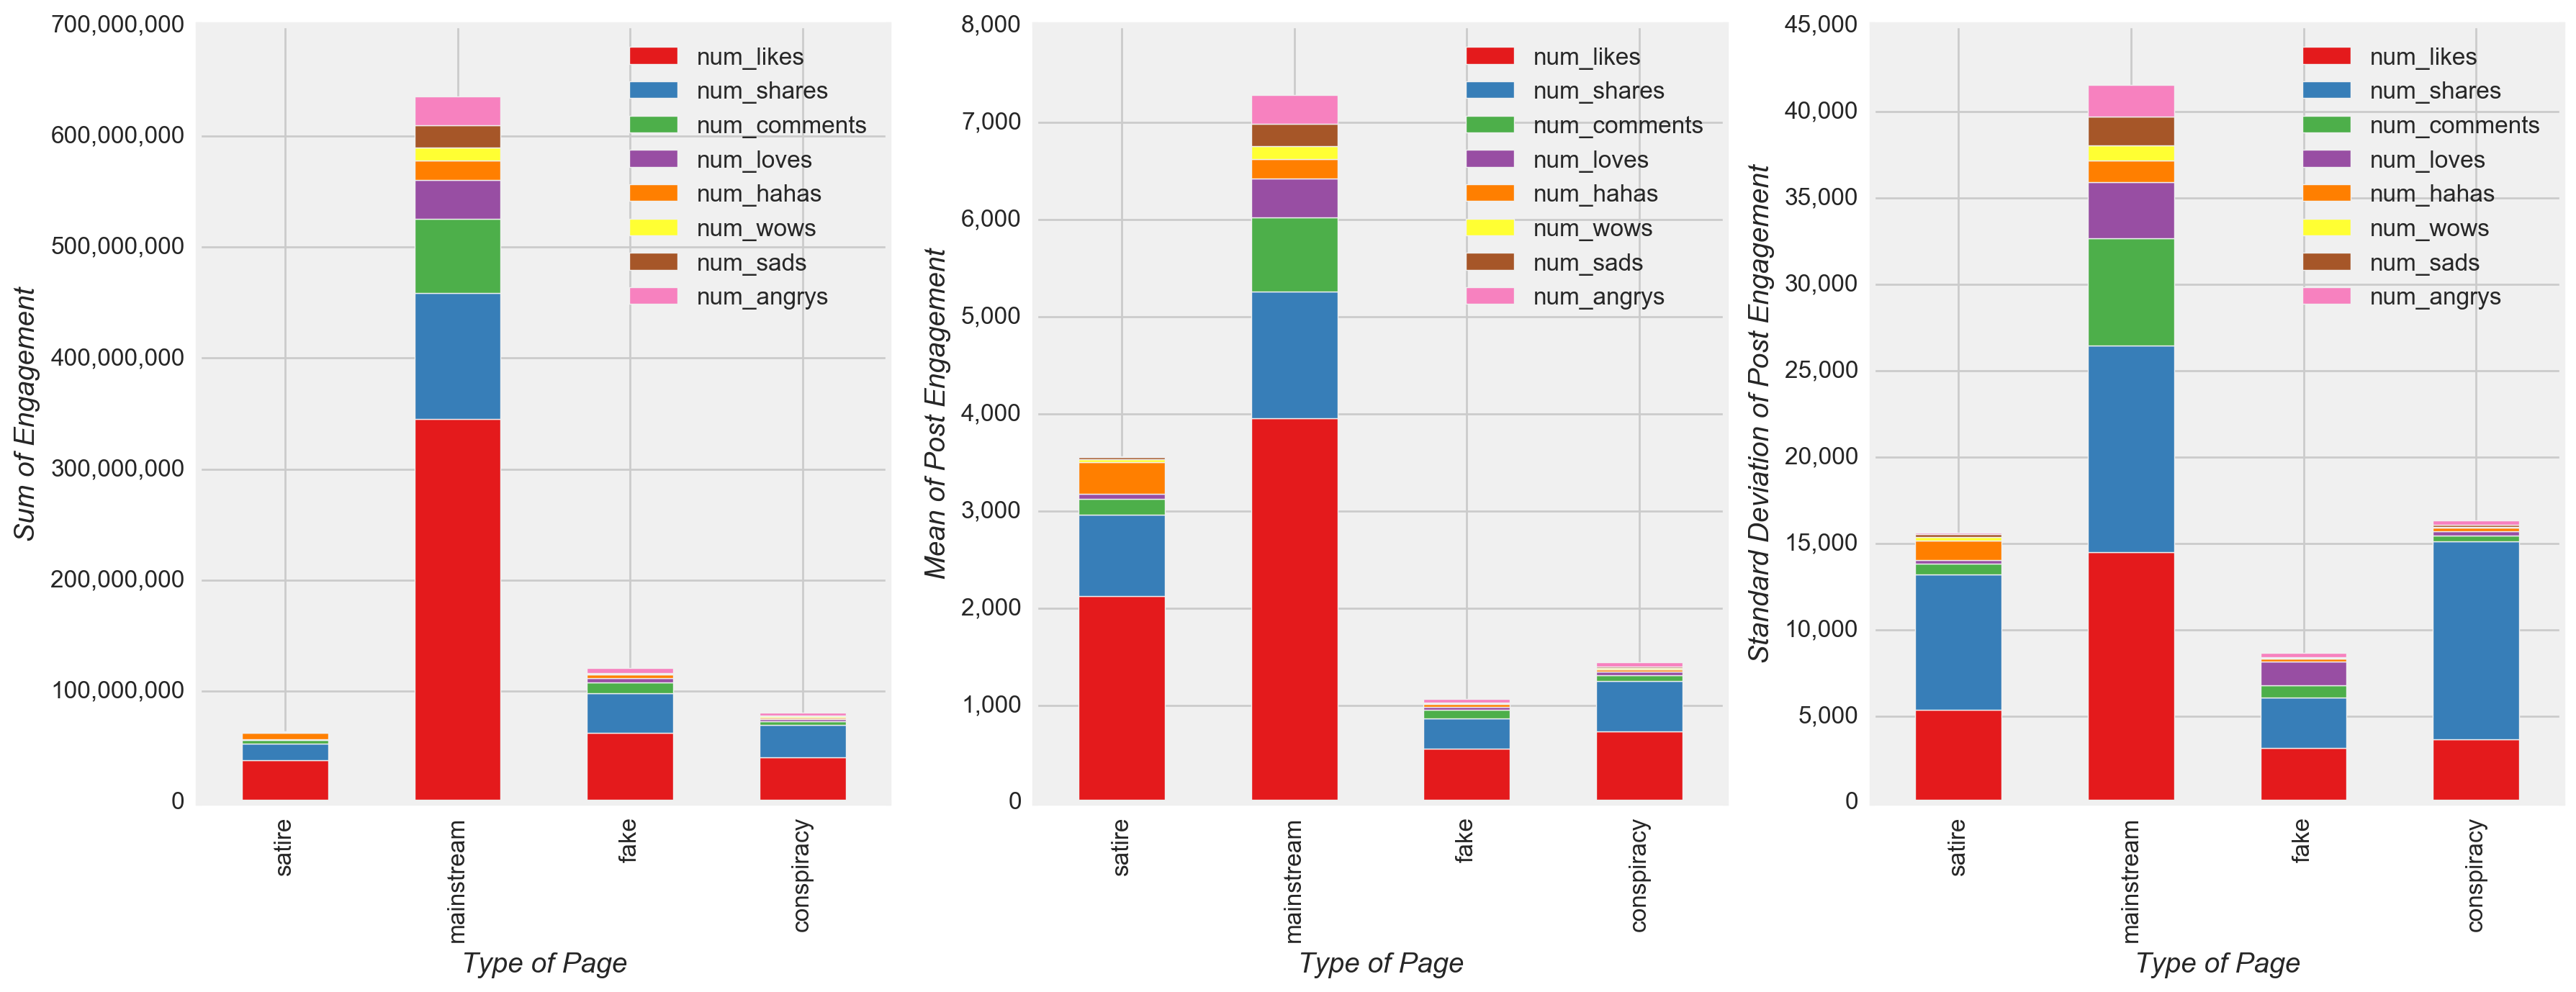

In [30]:
#Plot sum, mean, and standard deviation of engagement by type of page
temp=fb_news_total[['num_likes','num_shares','num_comments','num_loves','num_hahas','num_wows','num_sads','num_angrys']]
temp.set_index(fb_news_total['type'],inplace=True)
temp = temp.groupby(level='type')
means = temp.mean()
means.sort_index(inplace=True,ascending=False)
errors = temp.std()
errors.sort_index(inplace=True,ascending=False)
sums=temp.sum()
sums.sort_index(inplace=True,ascending=False)

fig, ax = plt.subplots(1,3, figsize=(18,7))
sums.plot(kind='bar',ax=ax[0],stacked=True,color=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf'])
means.plot(kind='bar',ax=ax[1],stacked=True,color=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf'])
errors.plot(kind='bar',ax=ax[2],stacked=True,color=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf'])

ax[0].set_ylabel("Sum of Engagement",style='italic',fontsize=14)
ax[0].set_xlabel("Type of Page",style='italic',fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,p: format(int(y), ',')))
ax[0].legend(fontsize=12)

ax[1].set_ylabel("Mean of Post Engagement",style='italic',fontsize=14)
ax[1].set_xlabel("Type of Page",style='italic',fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,p: format(int(y), ',')))
ax[1].legend(fontsize=12)

ax[2].set_ylabel("Standard Deviation of Post Engagement",style='italic',fontsize=14)
ax[2].set_xlabel("Type of Page",style='italic',fontsize=14)
ax[2].tick_params(axis='both', which='major', labelsize=12)
ax[2].yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,p: format(int(y), ',')))
ax[2].legend(fontsize=12)

plt.tight_layout()
plt.show()

# Though the least number of pages analyzed is the least, mainstream still makes up the second highest post volume
# Like mainstream news, fake and conspiracy news have a few sources posting much of the total type of news.
# This skewness is also observed with regard to engeagement, but also includes satire. 
# The second most common attached media type for mainstream pages is video, while all other types post photos second.
# Mainstream engagement is second highest for video. The highest engagement for conspiracy occurs for posts with photos.
# Most drastic change in posting volume occured in the form of a reduction for fake news after the election. This occured
# in large part due to a reduction in post volume in the top three posters afer the election.
# Engagement for mainstream and fake sites increased most drastically, while conspiracy engagement decreased. An increase
# in engagement for mainstream pages occured mostly due to higher engagement for posts from cnn, ABCNews, and usatoday.
# Post volume and engagement is lower on Saturday and Sunday across all types of news. 
# Considering the four time zones spanning the lower 48 of states, my assumption that most of the pages analyzed are 
# from the U.S. is confirmed in the working hours overlapping the period of peak posting. Interestingly,
# engagement for conspiracy appears to be most uniform across all times. 
# 

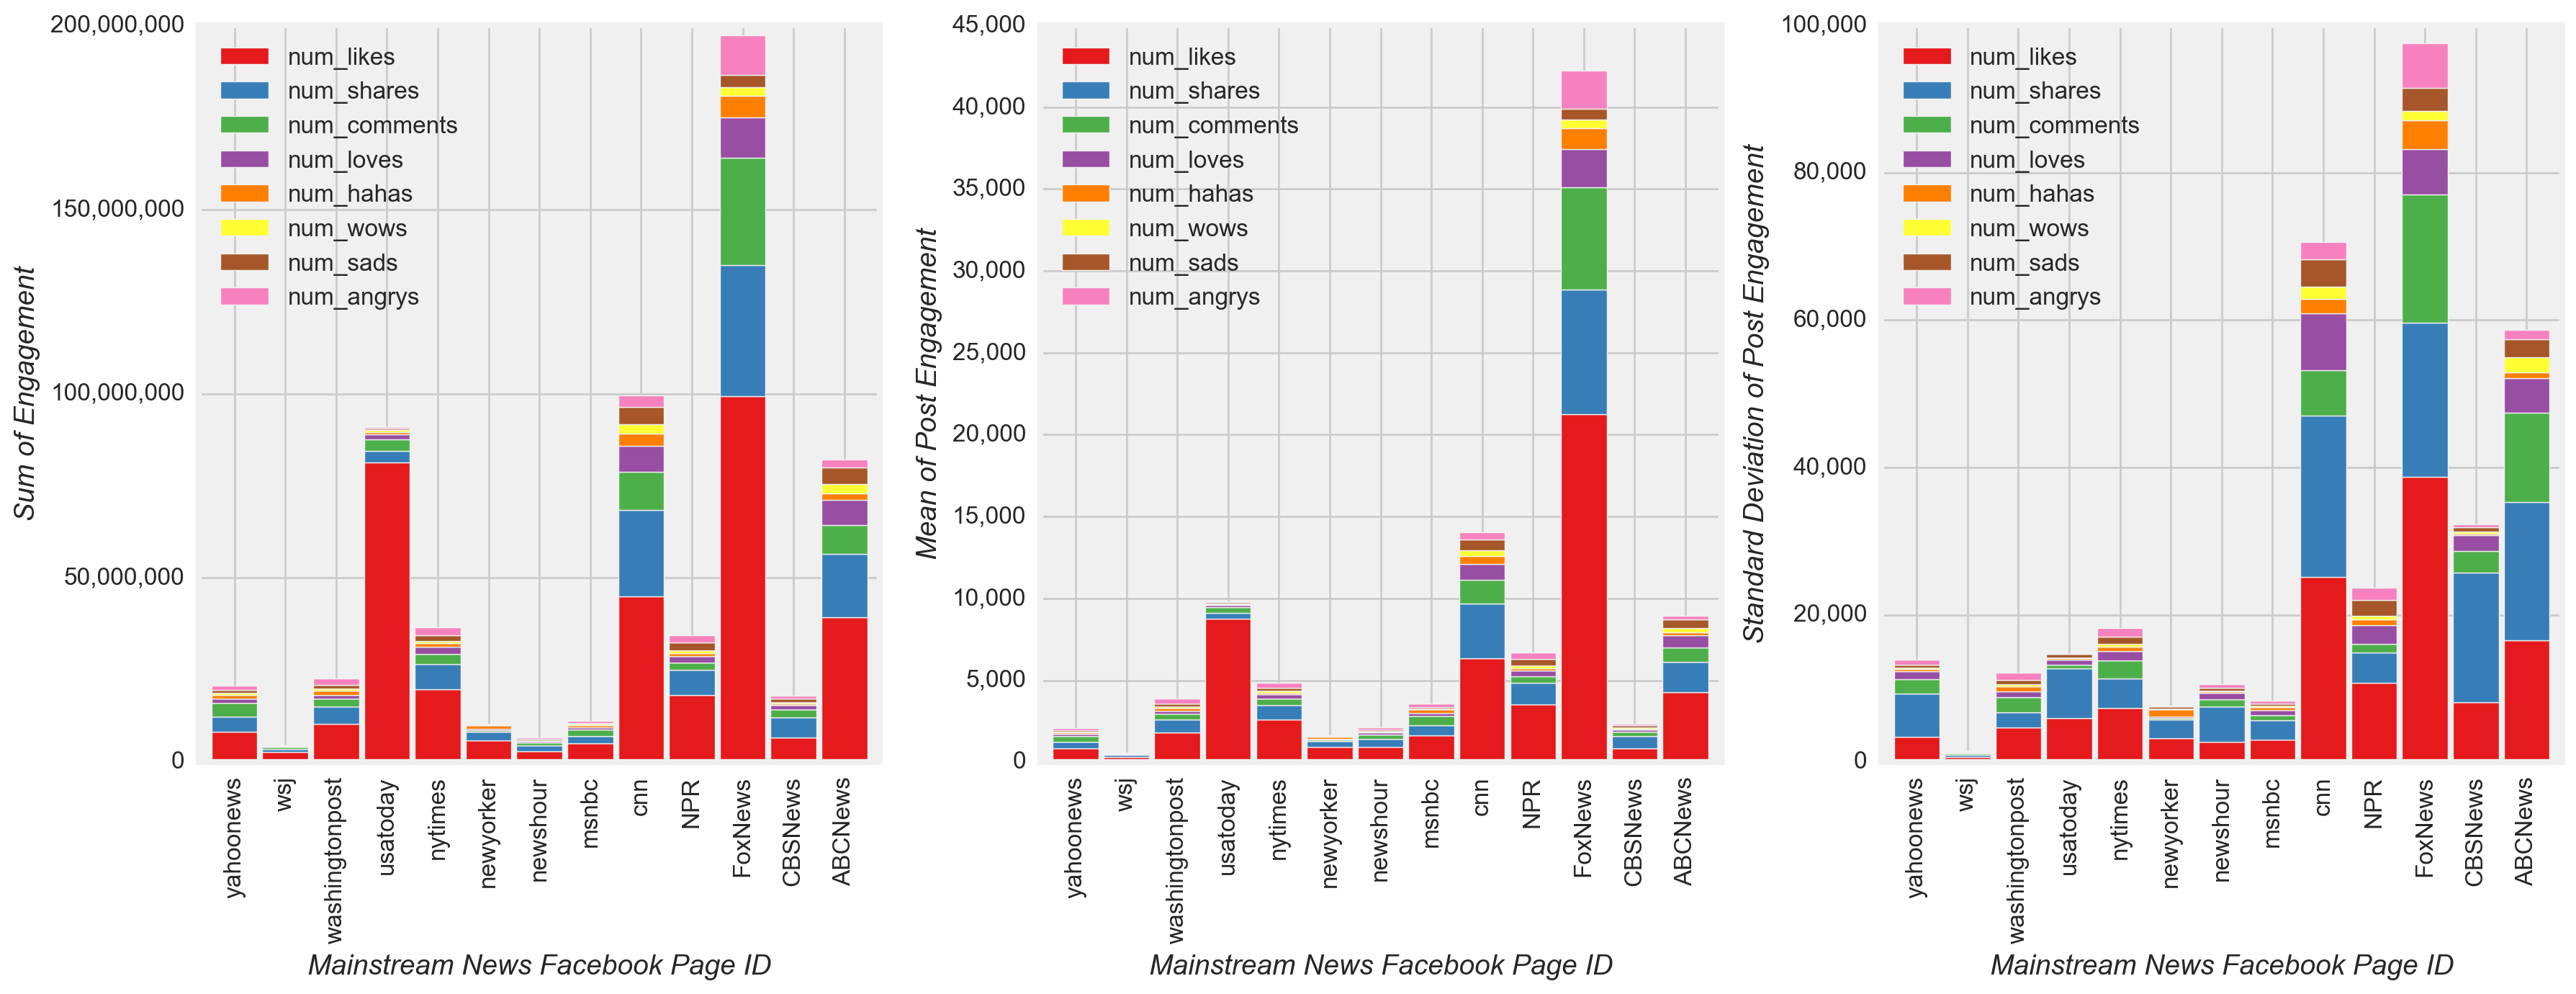

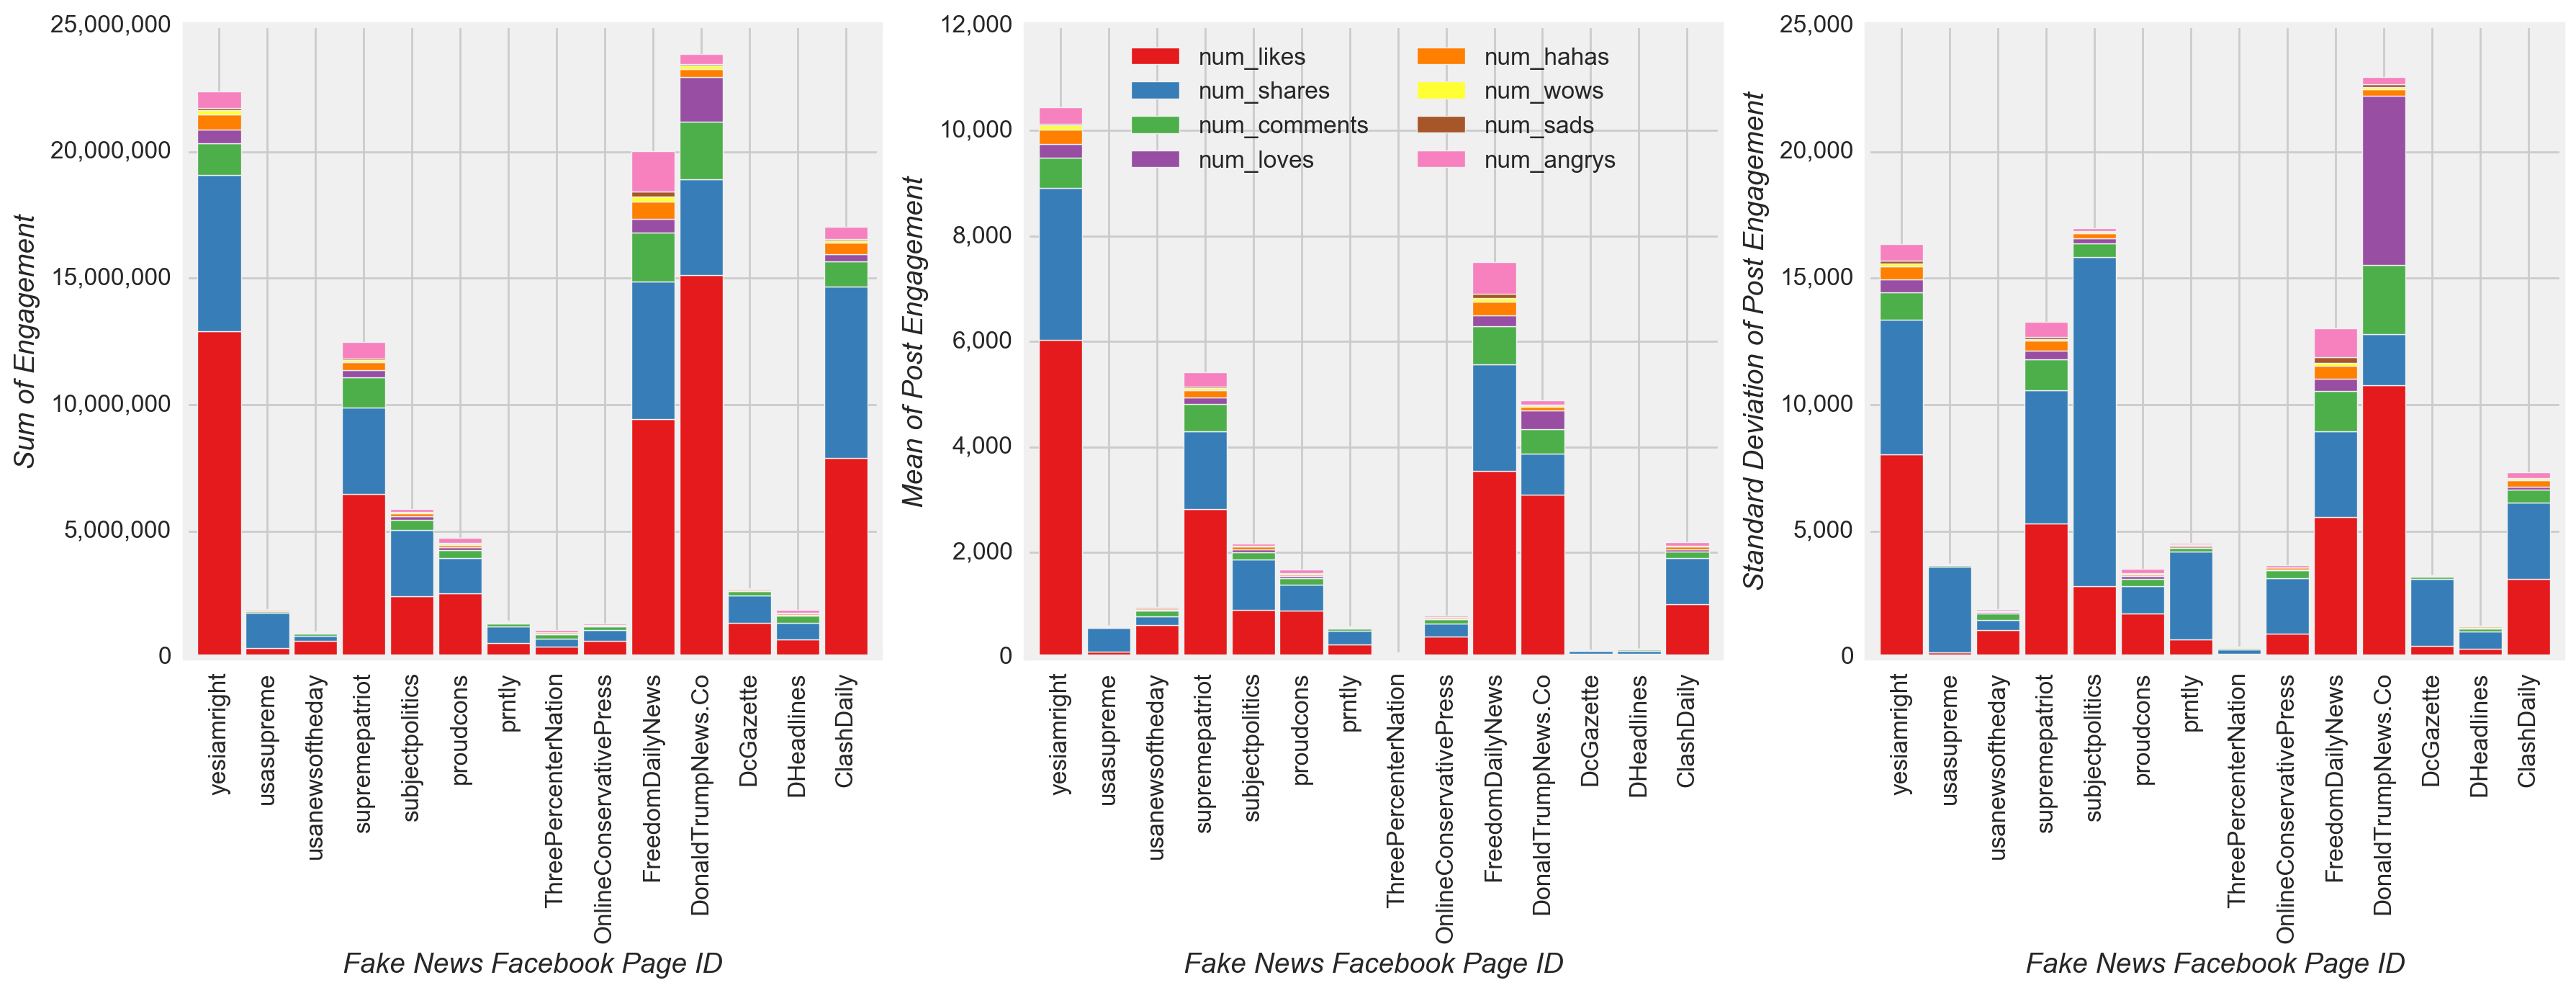

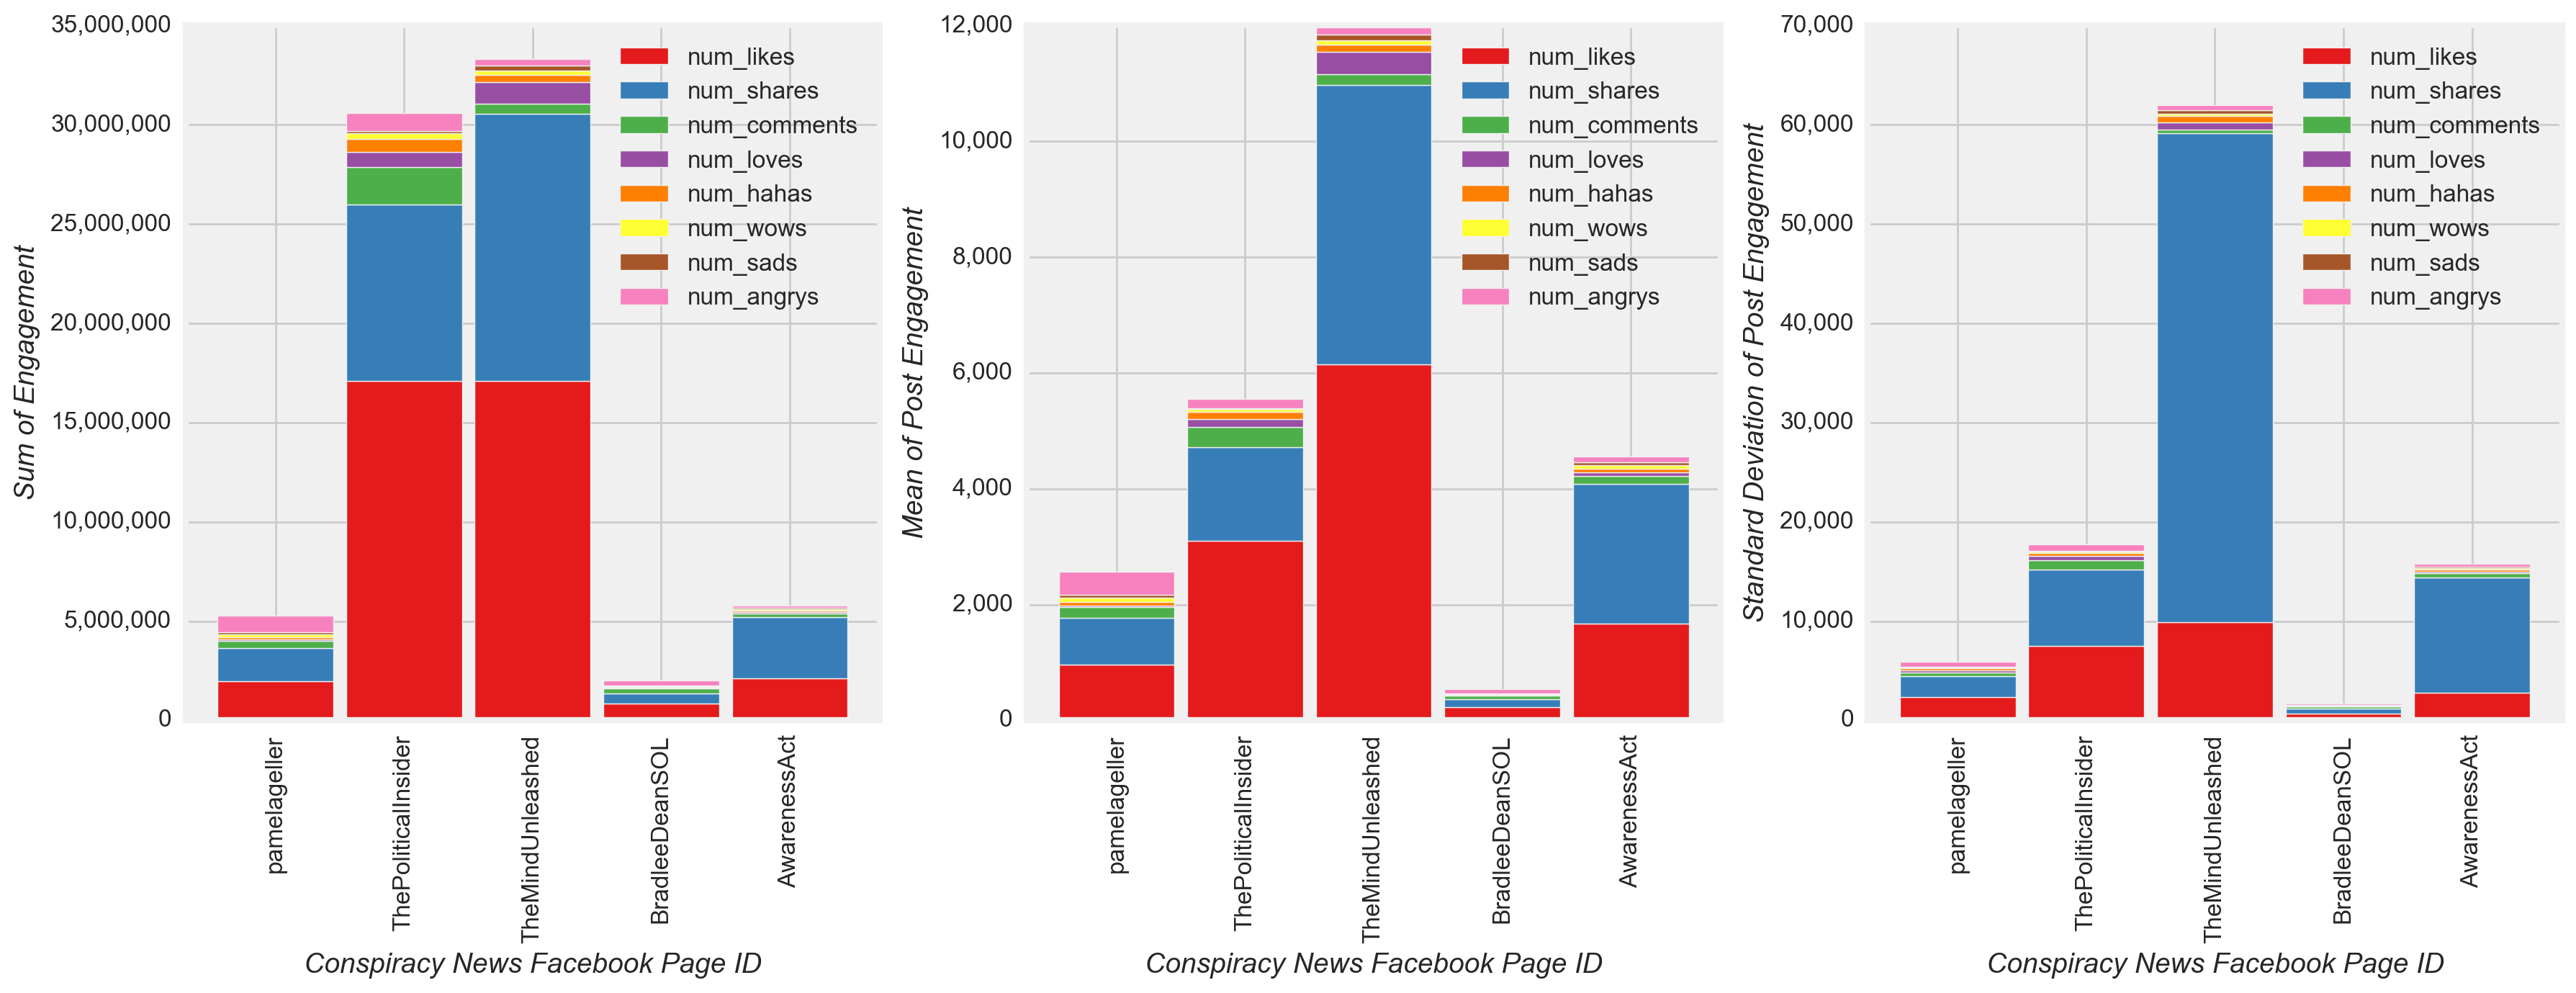

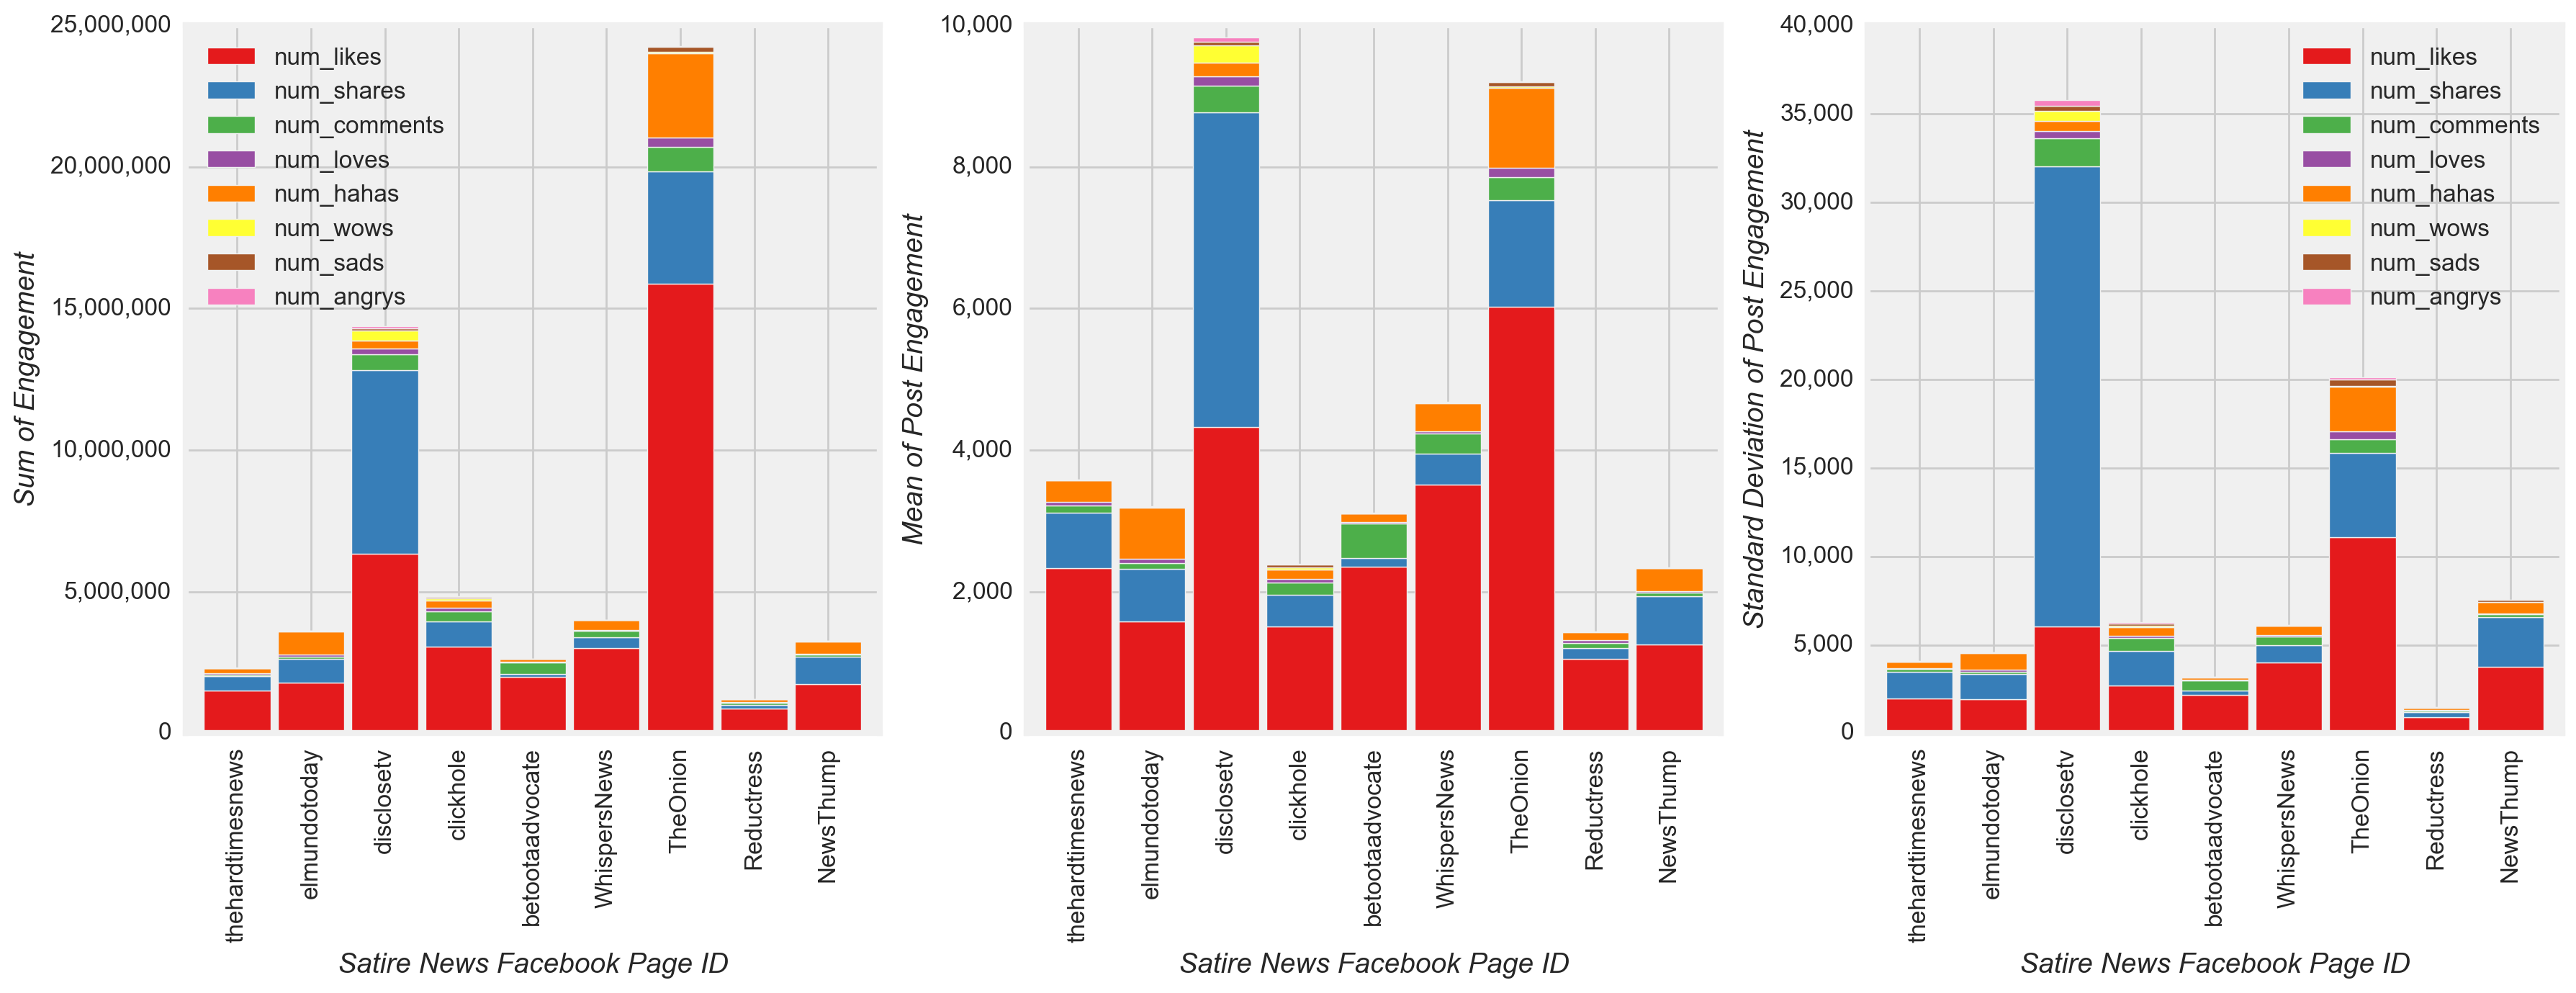

In [31]:
# Plot sum, mean, and standard deviation of engagement by Facebook page
# Only select sources with engagement sum greater than 900,000, i.e. pages with the most engagement 
for i,item in enumerate(fb_news_total['type'].unique()):
    reduced_source_list=fb_news_total[fb_news_total['type']==item].groupby('fb_id')['all_interactions'].sum()[fb_news_total[fb_news_total['type']==item].groupby('fb_id')['all_interactions'].sum()>900000]
    temp=fb_news_total.ix[fb_news_total['type']==item]
    temp=temp[temp['fb_id'].isin(list(reduced_source_list.index))]
    temp2=temp[['num_likes','num_shares','num_comments','num_loves','num_hahas','num_wows','num_sads','num_angrys']]
    temp2.set_index(temp['fb_id'],inplace=True)
    temp2 = temp2.groupby(level='fb_id')
    sums=temp2.sum()
    sums.sort_index(inplace=True,ascending=False)
    means = temp2.mean()
    means.sort_index(inplace=True,ascending=False)
    errors = temp2.std()
    errors.sort_index(inplace=True,ascending=False)
    
    fig, ax = plt.subplots(1,3,figsize=(18,7))
    sums.plot(kind='bar',stacked=True,width = 0.9,ax=ax[0],color=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf'])
    means.plot(kind='bar',stacked=True,width = 0.9,ax=ax[1],color=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf'])
    errors.plot(kind='bar',stacked=True,width = 0.9,ax=ax[2],color=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf'])
    
    ax[0].set_ylabel("Sum of Engagement",style='italic',fontsize=14)
    ax[0].set_xlabel((item.capitalize() + " News Facebook Page ID"),style='italic',fontsize=14)
    ax[0].tick_params(axis='both', which='major', labelsize=12)
    ax[0].yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,p: format(int(y), ',')))
    
    ax[1].set_ylabel("Mean of Post Engagement",style='italic',fontsize=14)
    ax[1].set_xlabel((item.capitalize() + " News Facebook Page ID"),style='italic',fontsize=14)
    ax[1].tick_params(axis='both', which='major', labelsize=12)
    ax[1].yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,p: format(int(y), ',')))
        
    ax[2].set_ylabel("Standard Deviation of Post Engagement",style='italic',fontsize=14)
    ax[2].set_xlabel((item.capitalize() + " News Facebook Page ID"),style='italic',fontsize=14)
    ax[2].tick_params(axis='both', which='major', labelsize=12)
    ax[2].yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,p: format(int(y), ',')))
      
    if i==1:
        ax[0].legend_.remove()
        ax[1].legend(loc='upper center',fontsize=12,ncol=2)
        ax[2].legend_.remove()
    elif i==2:
        ax[0].legend(loc='upper right',fontsize=12) 
        ax[1].legend(loc='upper right',fontsize=12)
        ax[2].legend(loc='upper right',fontsize=12) 
    elif i==3:
        ax[0].legend(loc='upper left',fontsize=12) 
        ax[1].legend_.remove()
        ax[2].legend(loc='upper right',fontsize=12)        
    else:
        ax[0].legend(loc='upper left',fontsize=12) 
        ax[1].legend(loc='upper left',fontsize=12)
        ax[2].legend(loc='upper left',fontsize=12)
        
    plt.tight_layout()
    plt.show()

In [10]:
#### Extract only the most useful predictors for the model. Numeric columns that are derived from predictors 
# already extracted for modeling are removed, e.g. all_interactions and num_reactions
x_subset=fb_news_total[['type','day_of_week','status_type','hour','num_comments', 'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys','all_interactions']]

for i in ['num_comments','num_shares','num_likes','num_loves','num_wows','num_hahas','num_sads','num_angrys']:
    x_subset.loc[:,i]=(1.0*x_subset.loc[:,i])/x_subset.loc[:,'all_interactions']
    x_subset.loc[x_subset['all_interactions']==0,i]=0

y_subset=pd.Series([-999] * len(x_subset['type']))

site_types=list(fb_news_total['type'].unique())
for i,item in enumerate(site_types):
    y_subset[x_subset['type']==item]=i
    
print sum(y_subset==-999)
    
weekday_types=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

x_subset.loc[:,'num_week_day']=-999

for i,item in enumerate(weekday_types):
    x_subset.loc[x_subset['day_of_week']==item,'num_week_day']=i

x_subset = x_subset.drop(['type','day_of_week','all_interactions'], 1)
x_subset['type']=y_subset
print sum(x_subset['num_week_day']==-999)
print sum(x_subset['num_comments'].isnull())

/Users/lukejarmbruster/anaconda/envs/dsi/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0


/Users/lukejarmbruster/anaconda/envs/dsi/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


0
0


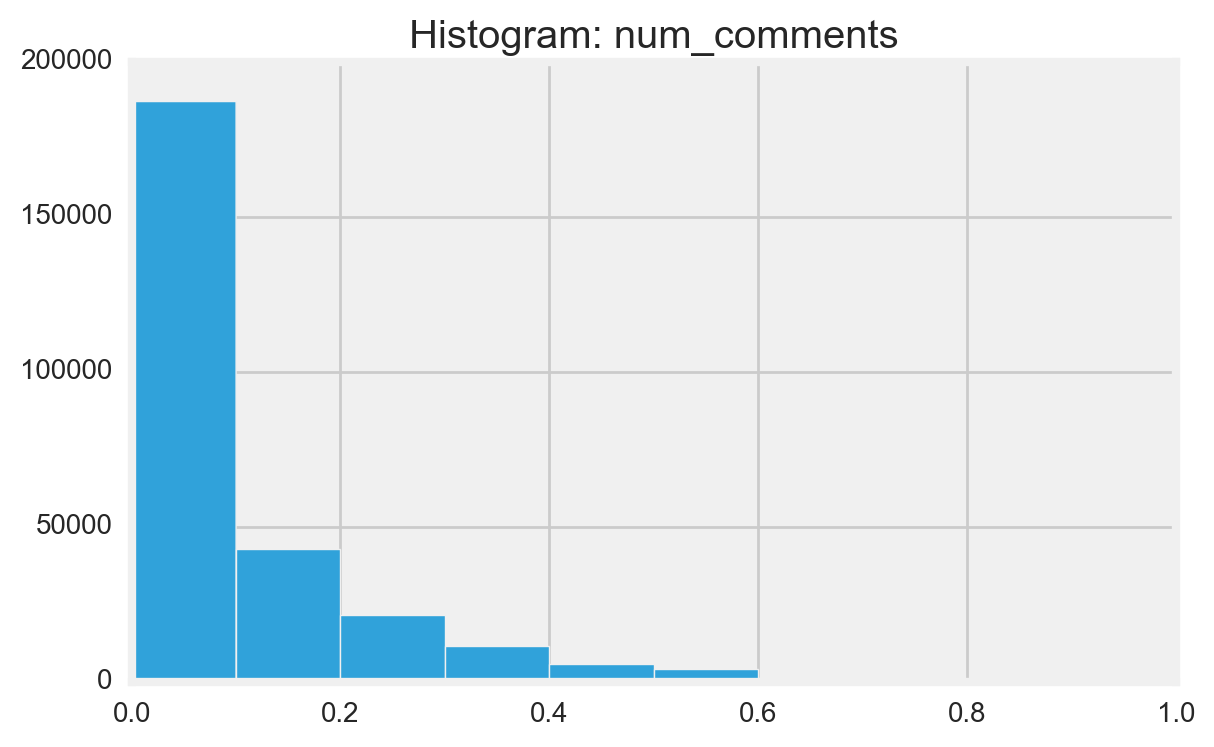

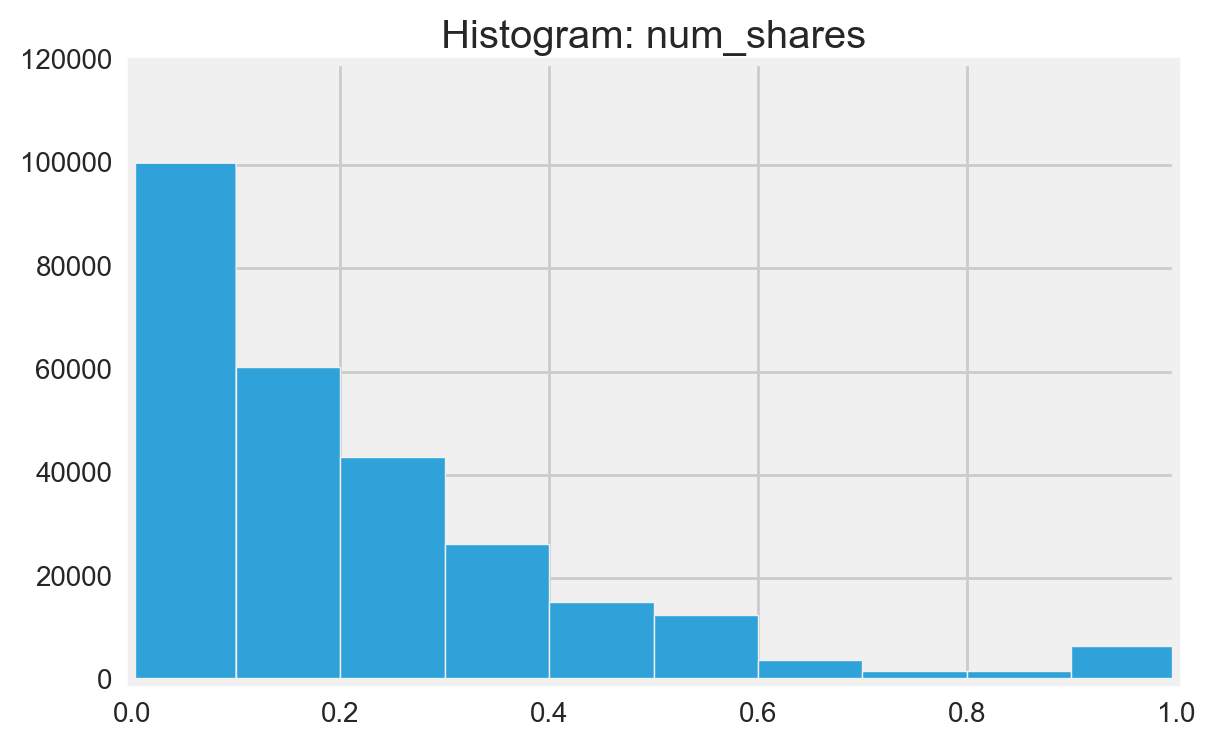

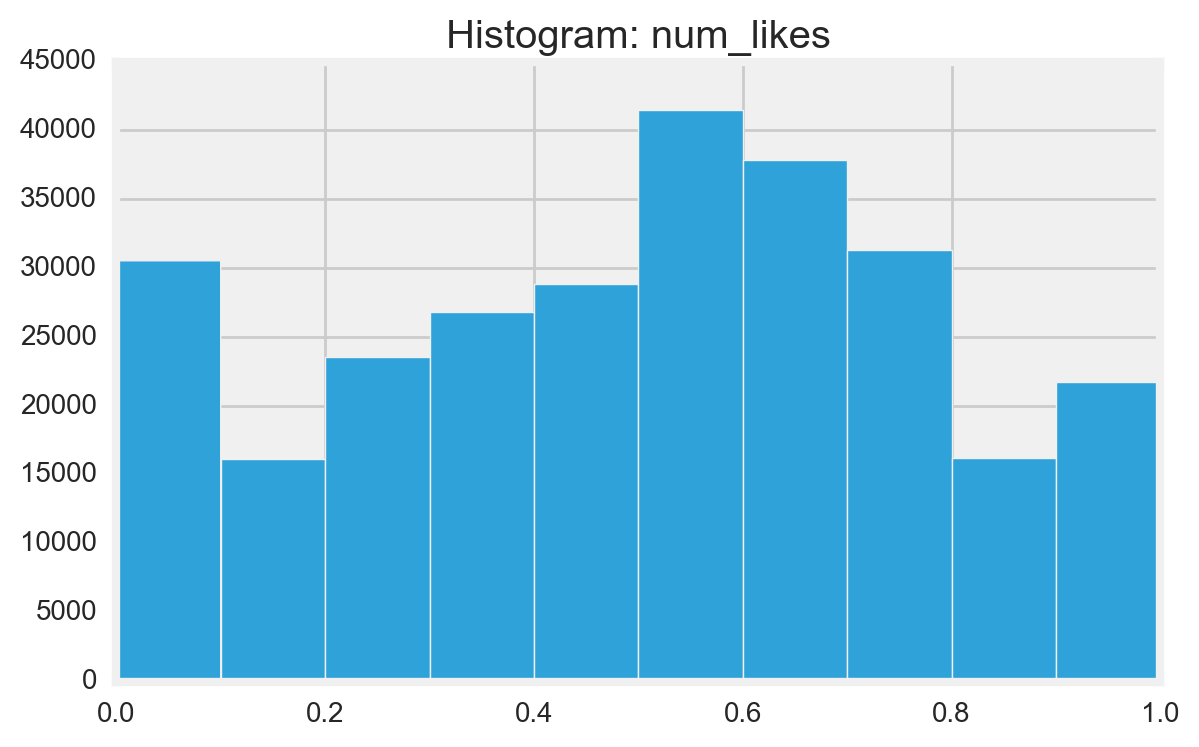

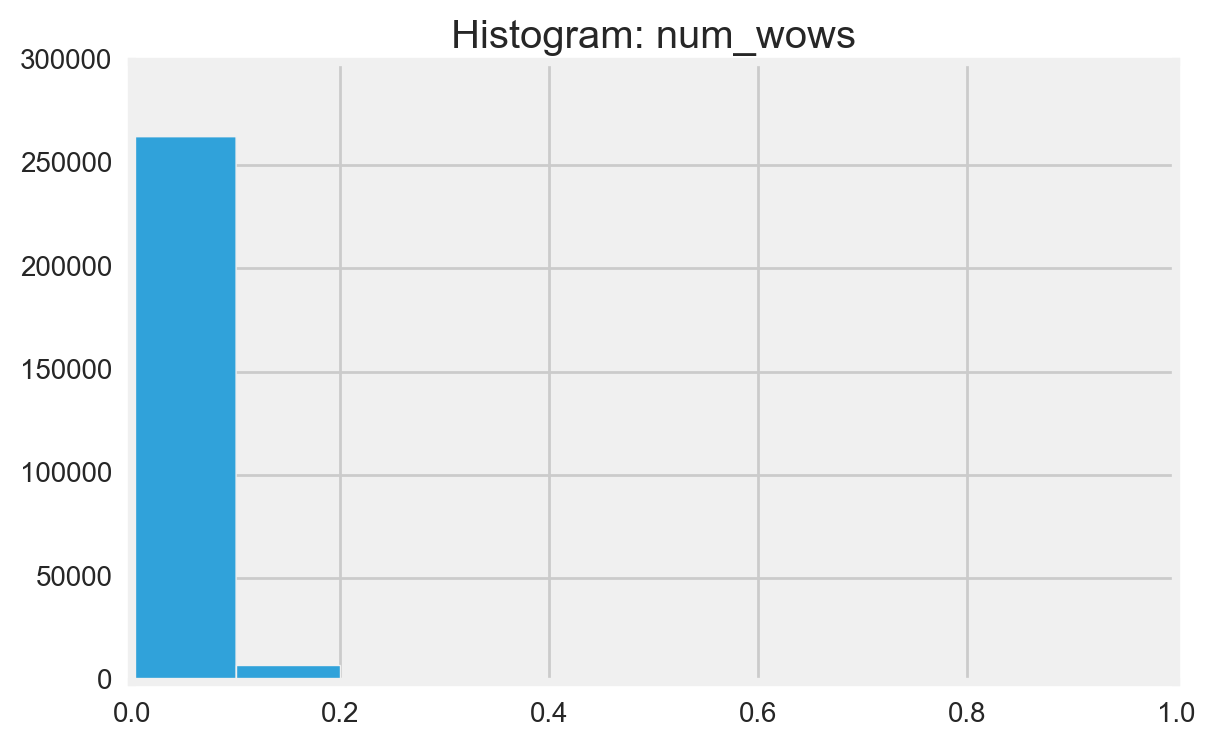

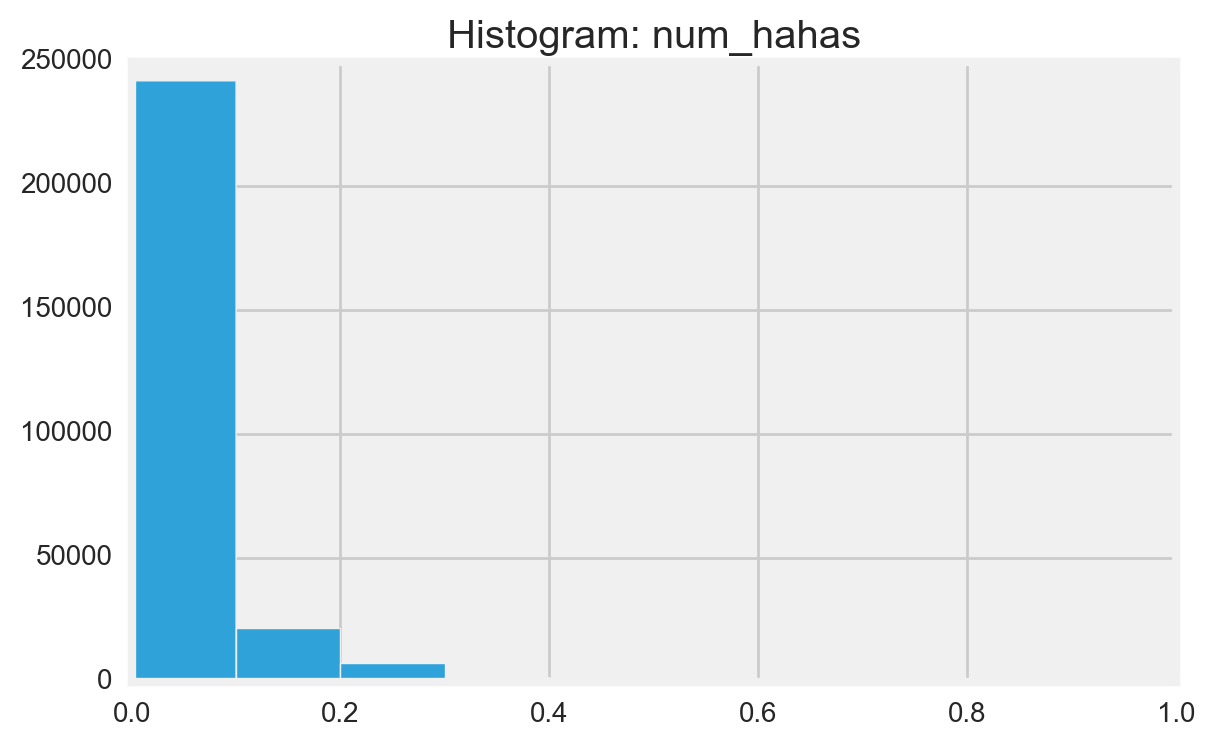

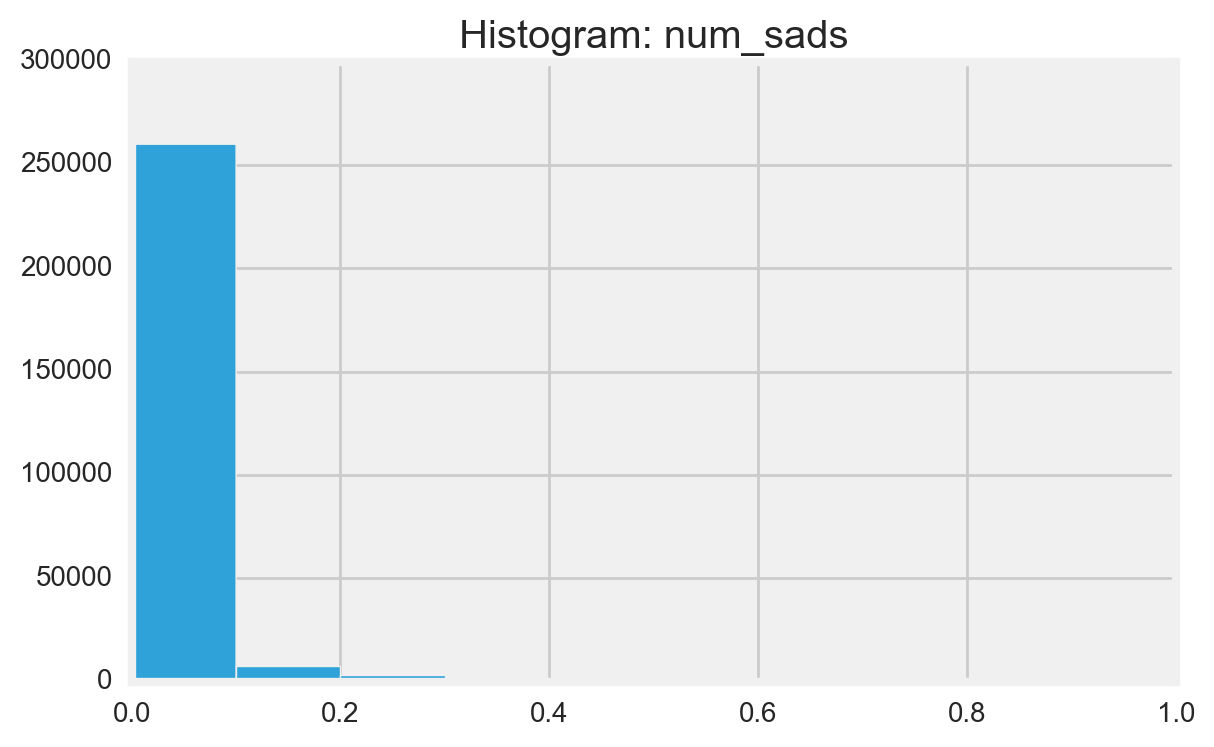

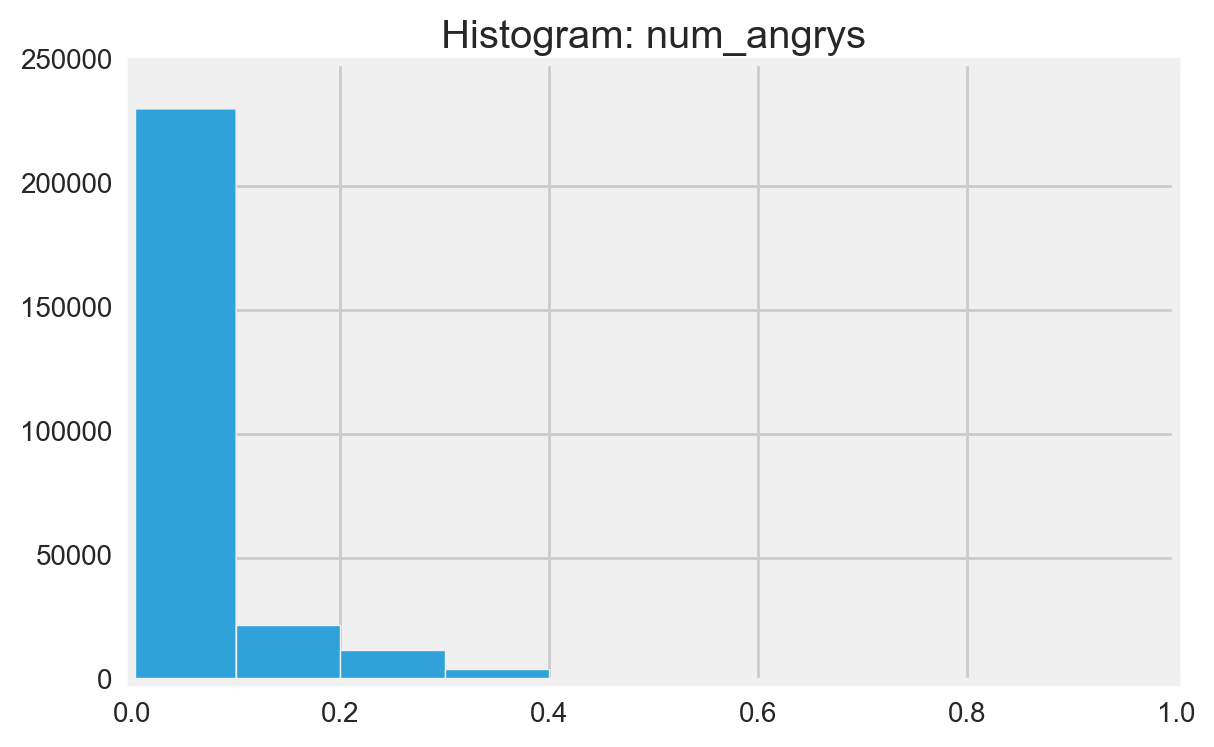

In [44]:
# Plot histograms of proportion 
for i in ['num_comments','num_shares','num_likes','num_loves','num_wows','num_hahas','num_sads','num_angrys']:
    x_subset.ix[:,i].hist()
    plt.title(('Histogram: '+i))
    plt.show()

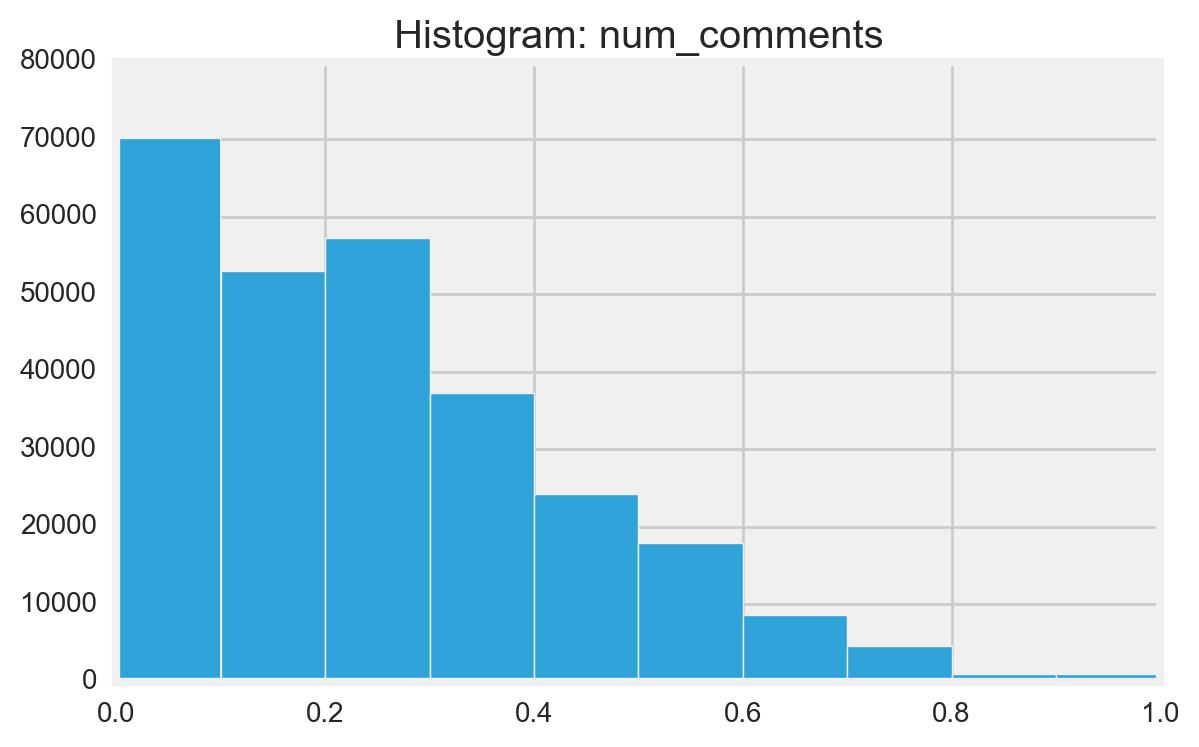

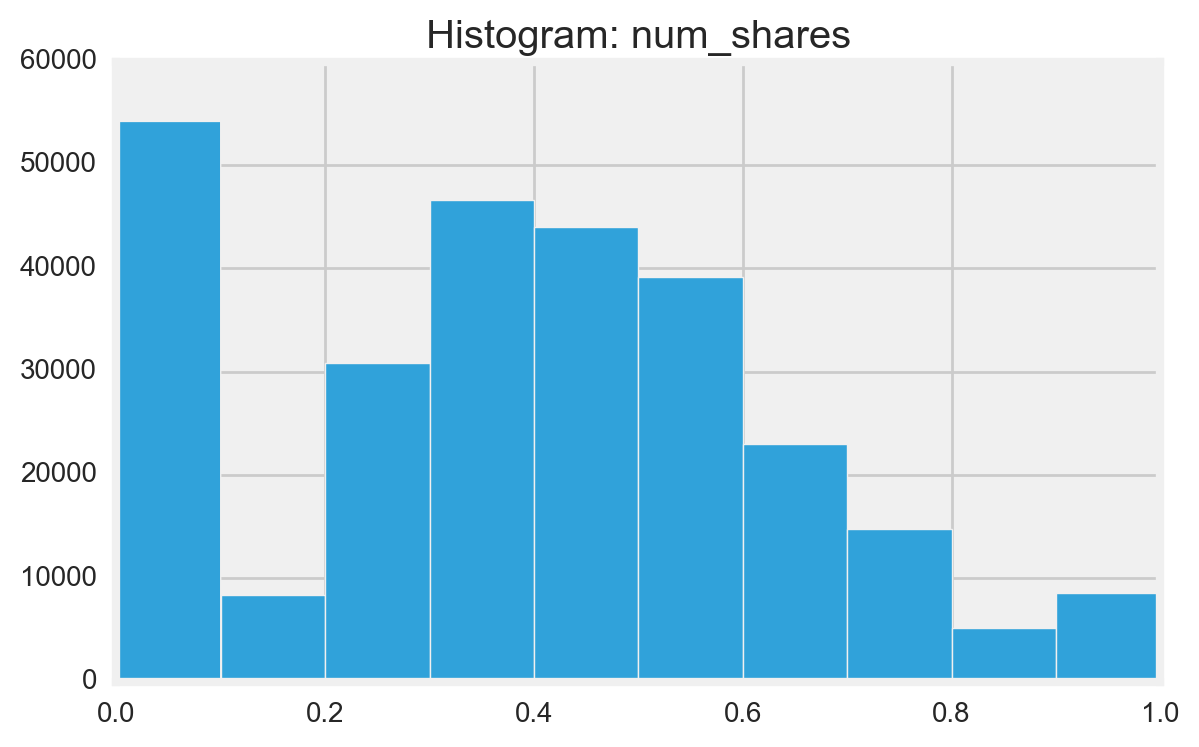

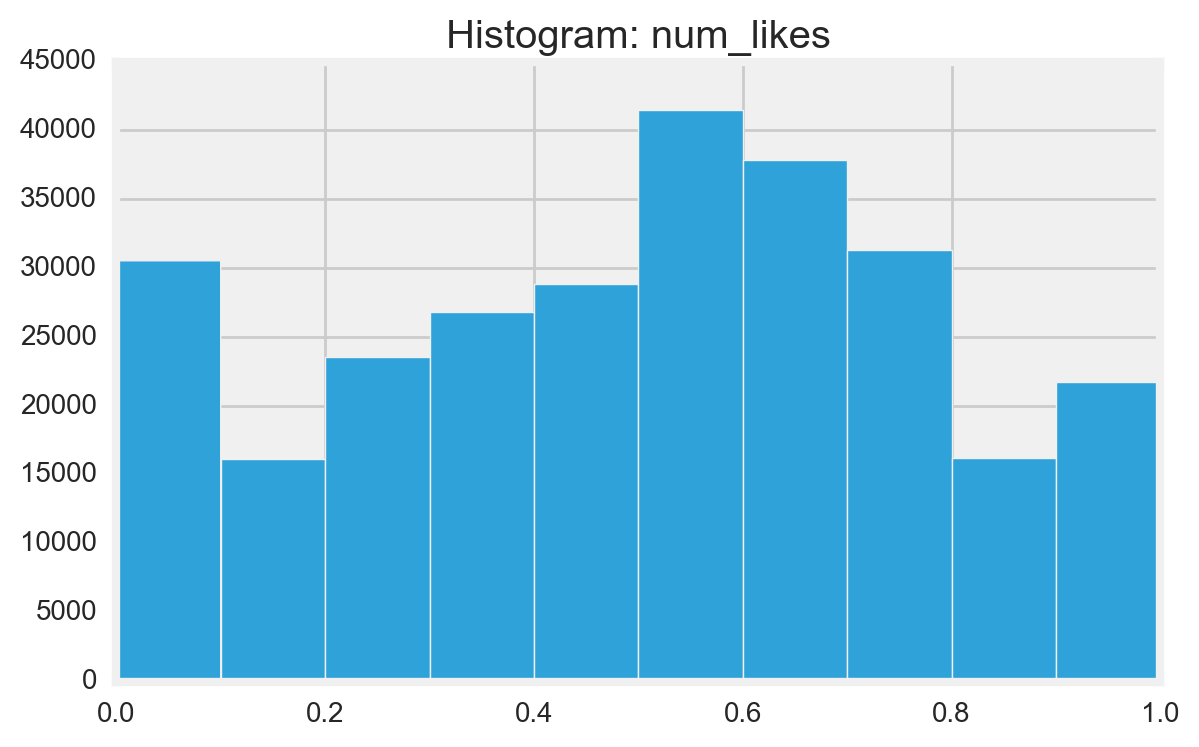

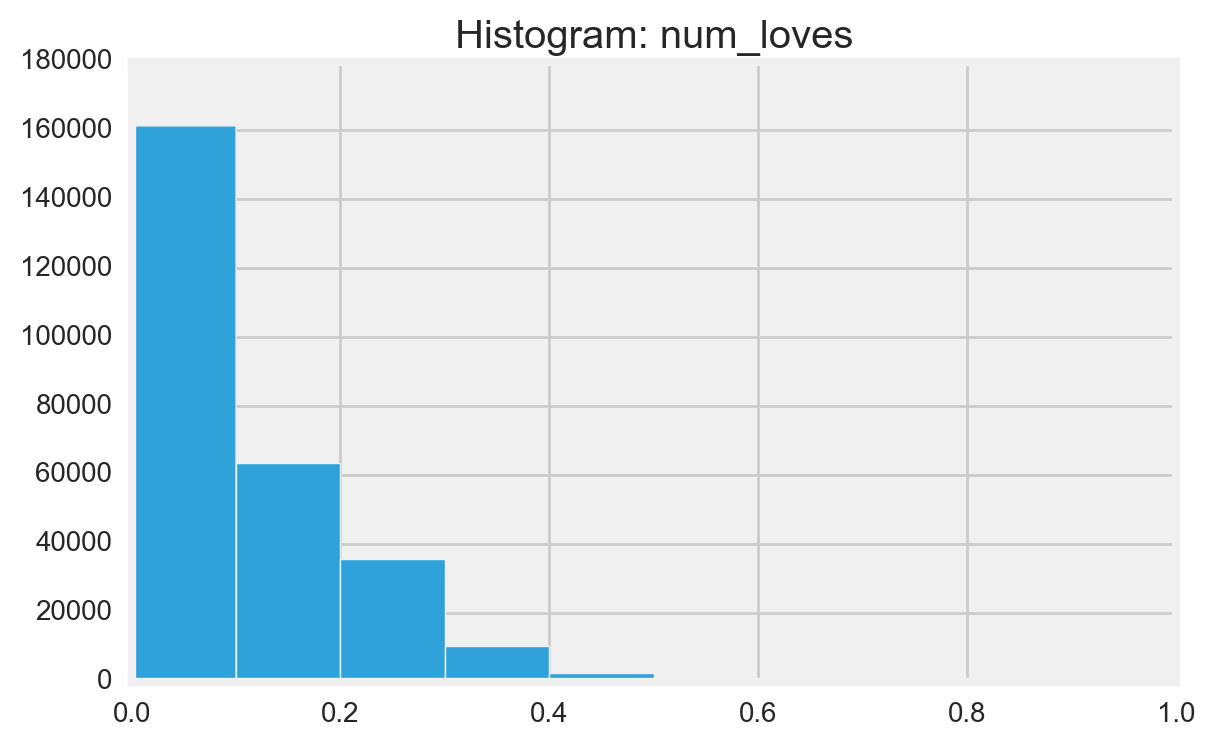

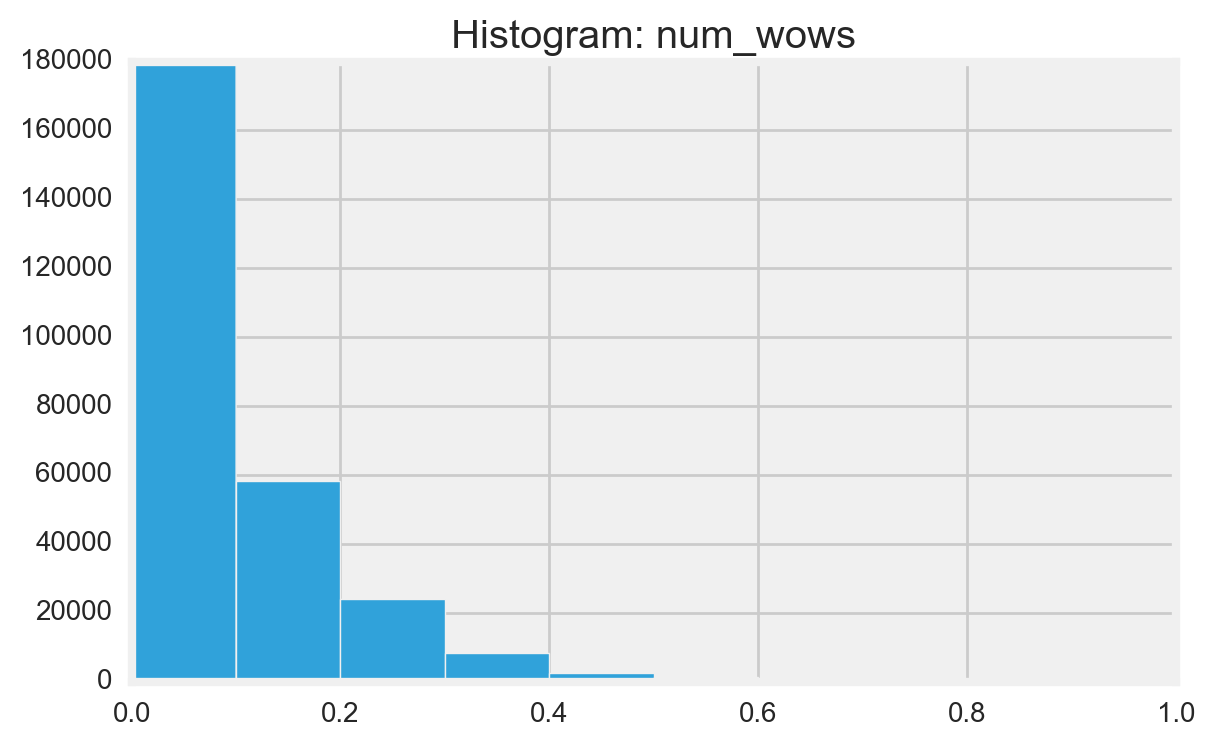

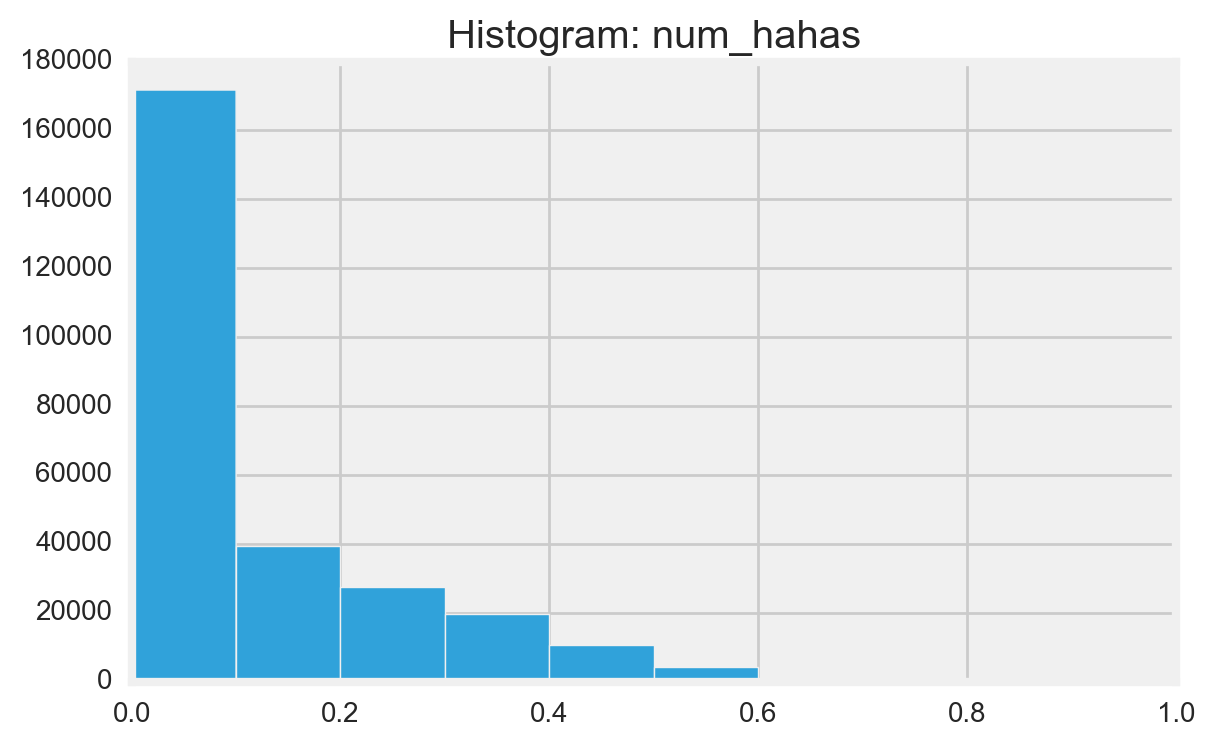

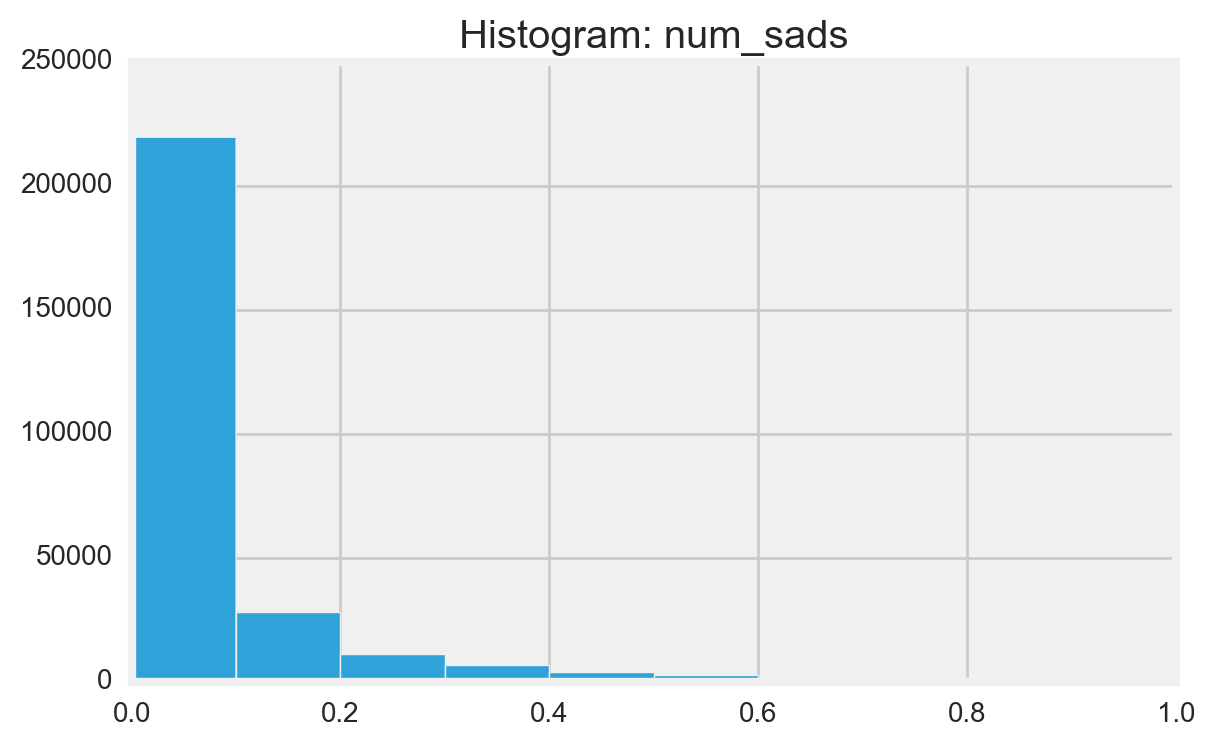

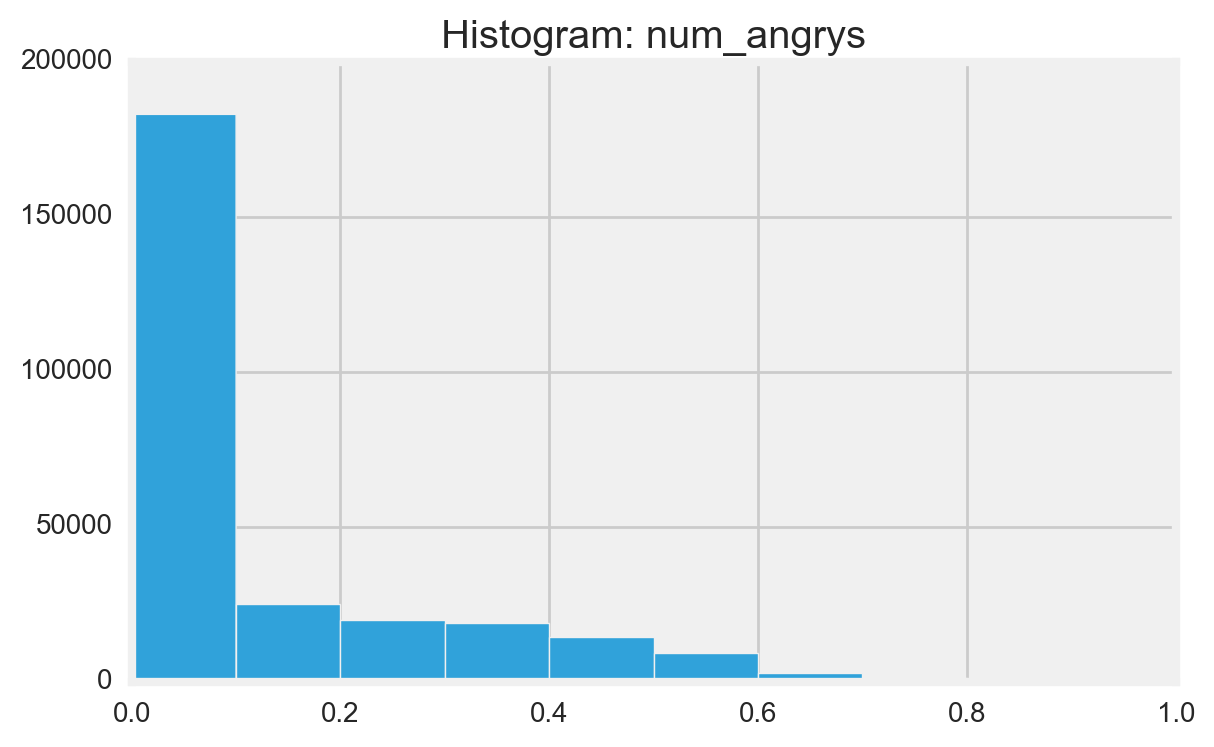

In [50]:
# Transform skewed variables to approach normality
# Plot histograms of proportion  after transformation
temp=x_subset
for i in ['num_comments','num_shares','num_likes','num_loves','num_wows','num_hahas','num_sads','num_angrys']:
    if i not in ['num_likes']:
        temp.ix[:,i]=np.sqrt(x_subset.ix[:,i])
    temp.ix[:,i].hist()
    plt.title(('Histogram: '+i))
    plt.show()

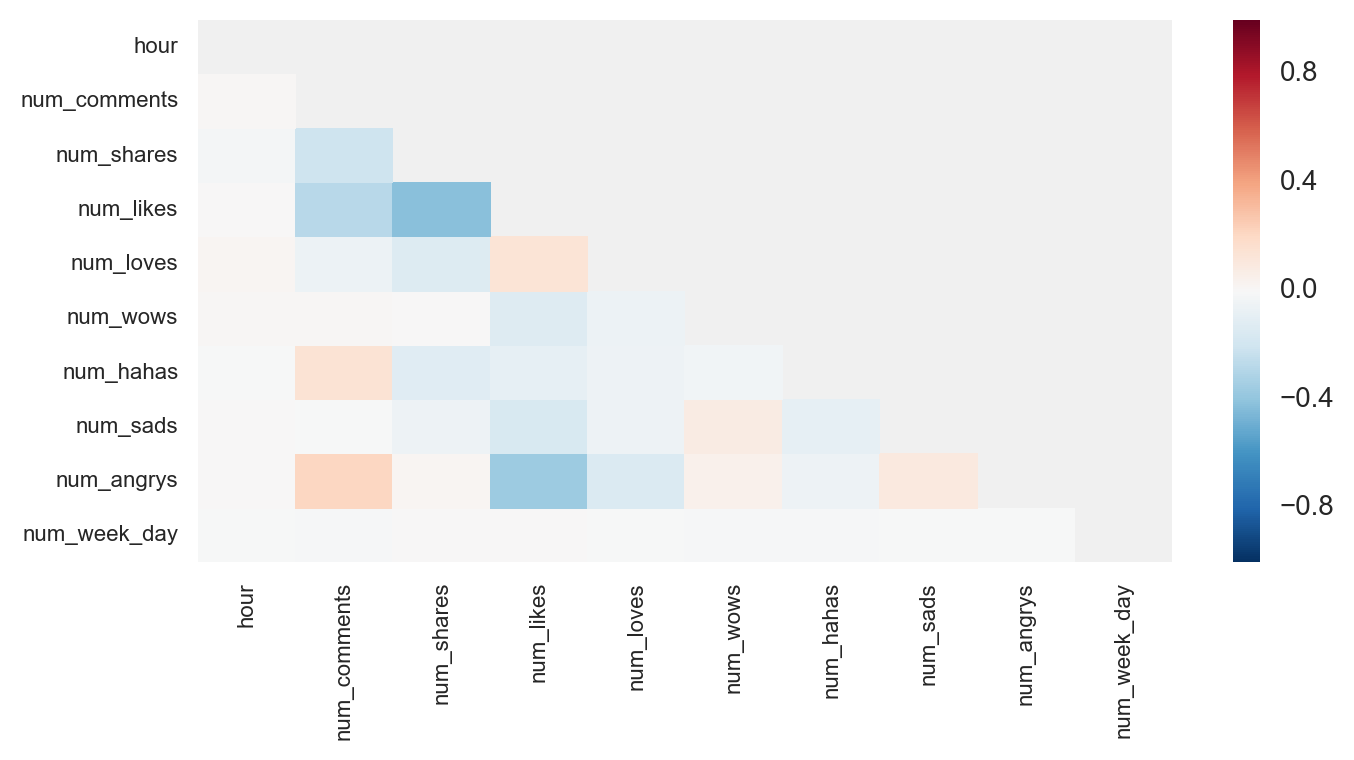

In [35]:
# Plot correlation matrix of the predictors excluding the TF-IDF of words used in the post message
# The code for the heat map below is modified from the General Assembly Data Science Immersive Cohort 4 
# Class (Nov 2016-Feb 2017)
temp=x_subset.drop(['type'], 1)
corrs = temp.corr()

# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(7,3.5))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corrs, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=8, rotation=90)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=8, rotation=0)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

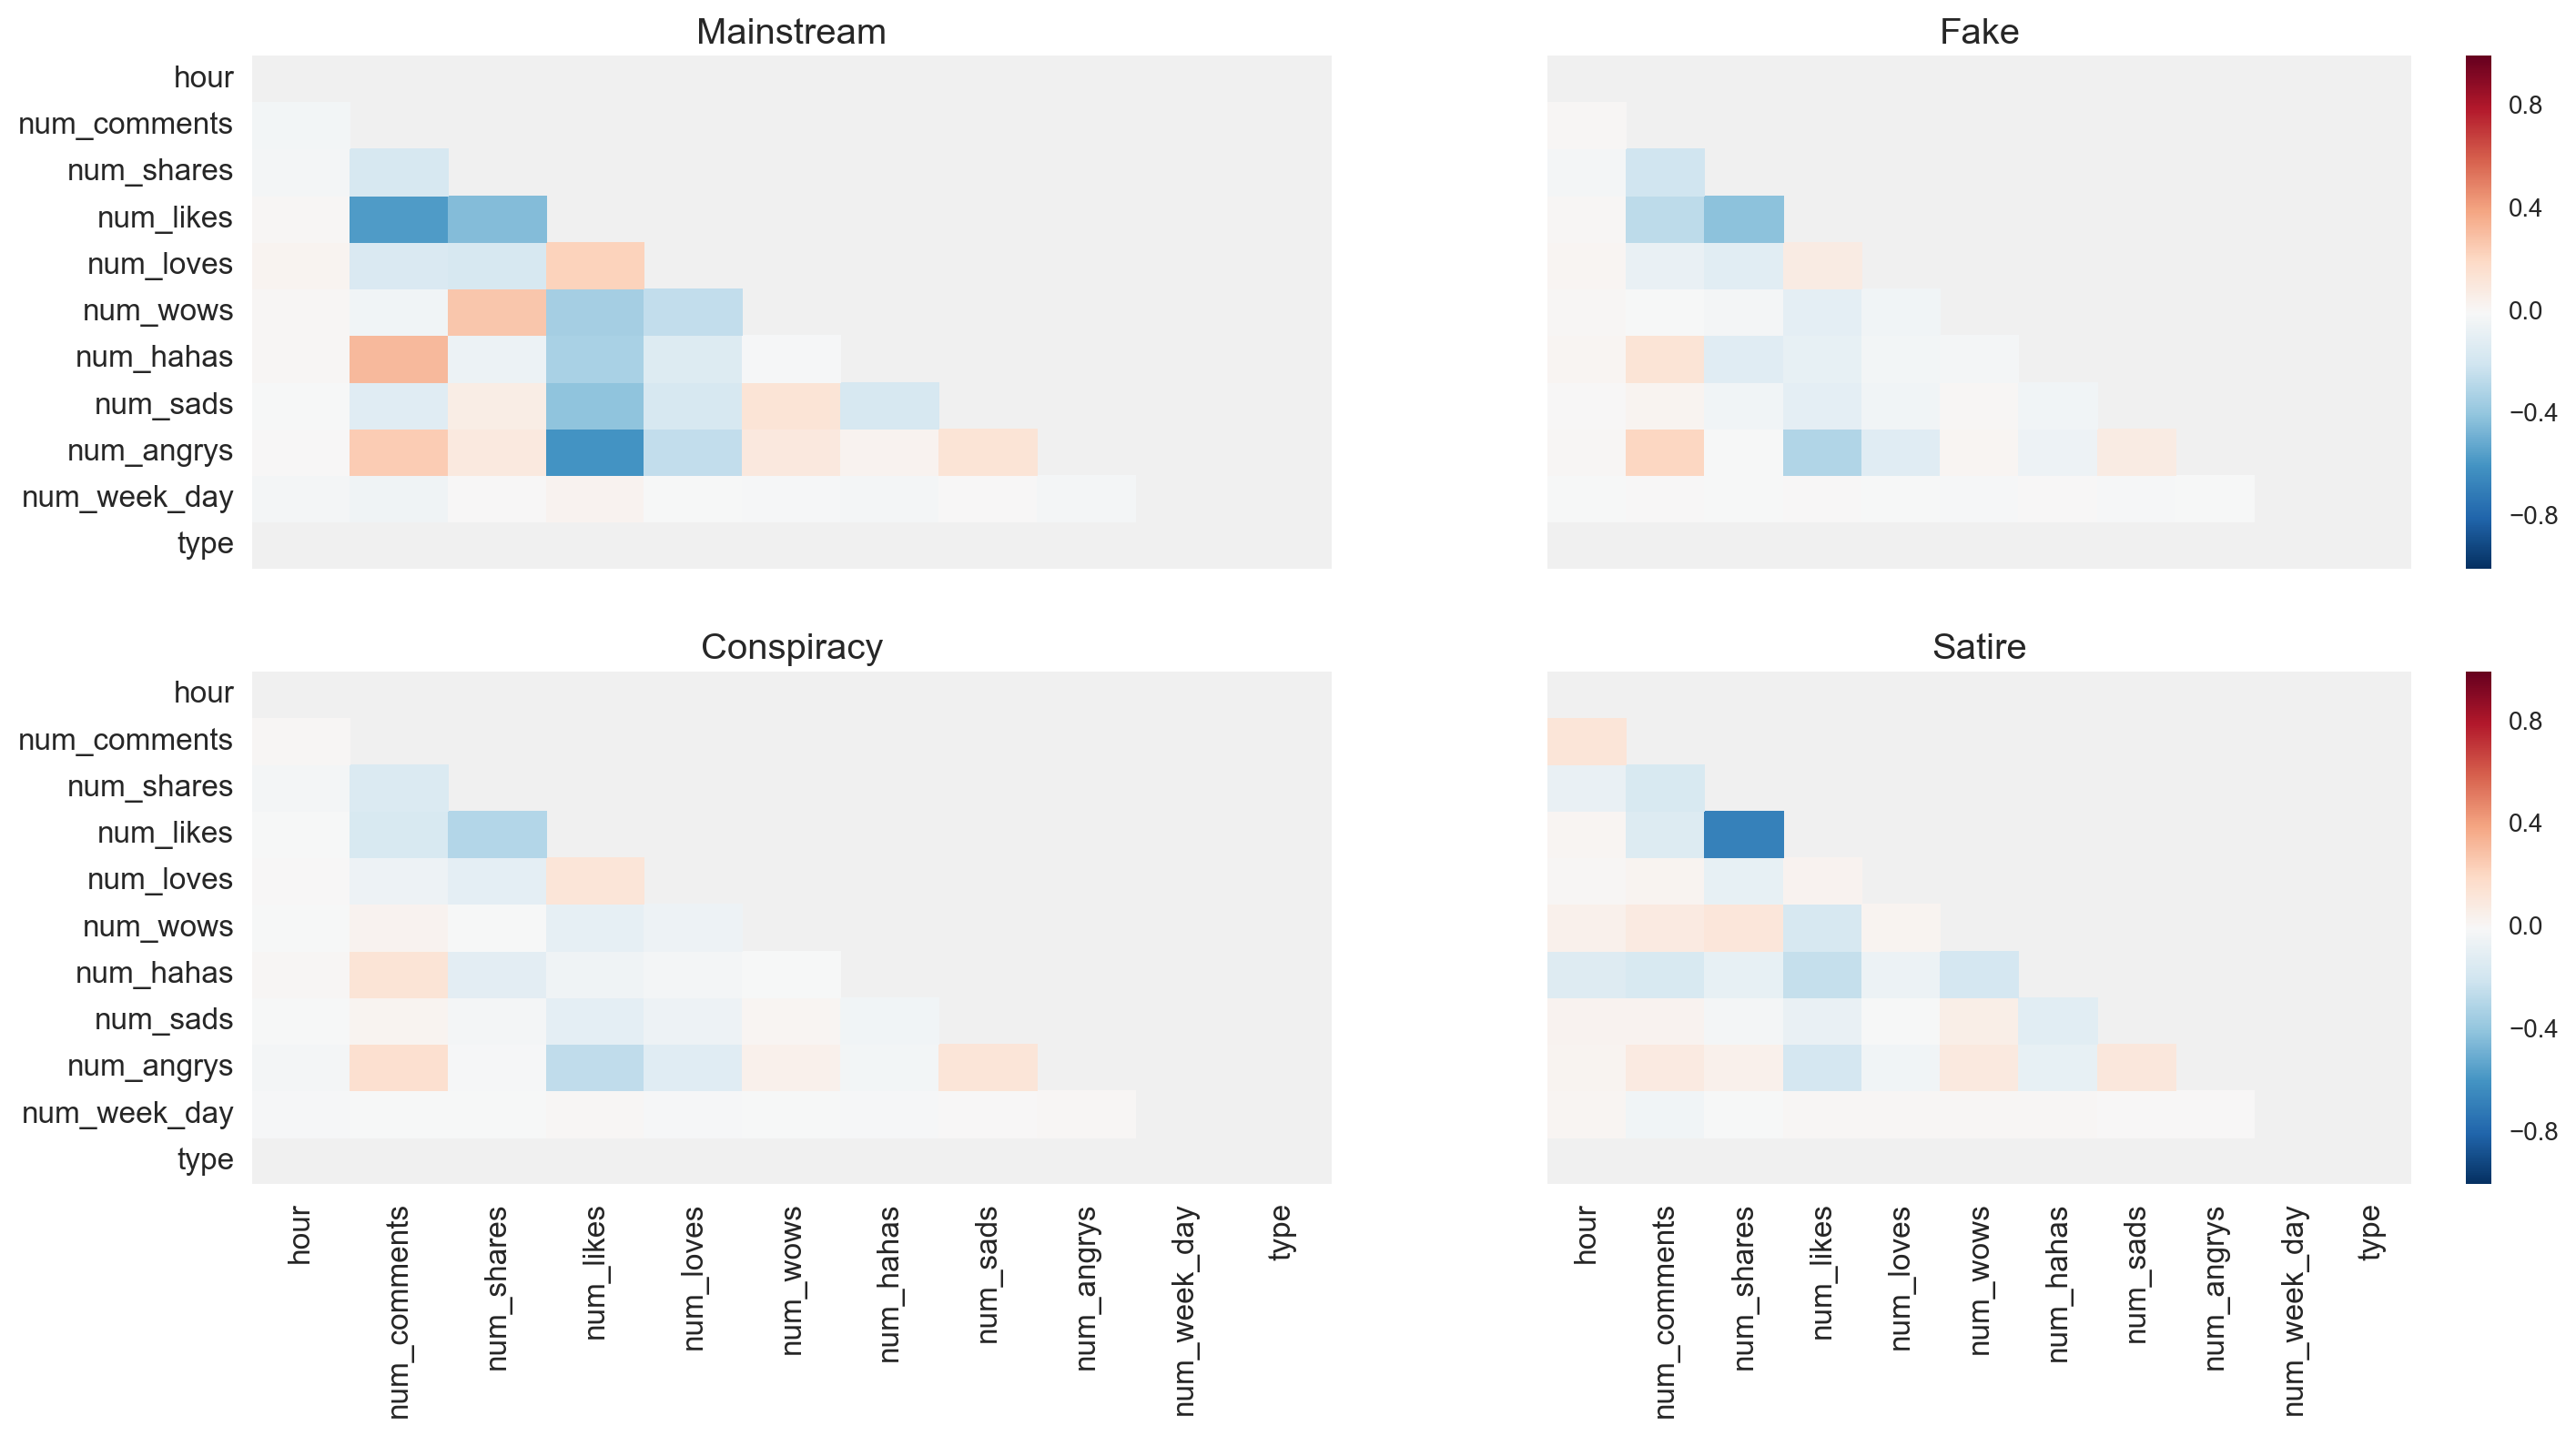

In [36]:
# Plot the correlation matrices of the predictors for each type of news excluding the TF-IDF of words used in the 
# post message
# The code for the heat map below is modified from the General Assembly Data Science Immersive Cohort 4 
# Class (Nov 2016-Feb 2017)
grouped = x_subset.groupby('type')
rowlength = grouped.ngroups/2 # fix up if odd number of groups
fig, axs = plt.subplots(figsize=(15,8), nrows=2, ncols=rowlength)
targets = zip(grouped.groups.keys(), axs.flatten())
site_types=['Mainstream','Fake','Conspiracy','Satire']

for i, (key, ax) in enumerate(targets):
    mask= np.zeros_like(grouped.get_group(key).corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    if ((i==1) | (i==3)):
        plot=sns.heatmap(grouped.get_group(key).corr(), ax=ax,xticklabels=(i >= rowlength),yticklabels=(i%rowlength==0),
                         cbar=True,mask=mask) 
        plot.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12)
        plot.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12)
    else:
        plot=sns.heatmap(grouped.get_group(key).corr(), ax=ax,
                         xticklabels=(i >= rowlength),yticklabels=(i%rowlength==0),
                         mask=mask,cbar=False) 
    ax.set_title(site_types[i])
    plot.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12)
    plot.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12)

plt.show()

In [37]:
# Show fraction of posts without messages
print 'Fraction of posts without message text: ',round((1.0*sum(fb_news_total['status_message']==""))/fb_news_total.shape[0],4)

Fraction of posts without message text:  0.0828


In [38]:
# Show fraction of posts with messages by page type
temp=fb_news_total
temp['message_state']=0
for i,item in enumerate(list(fb_news_total['type'].unique())):
    temp.ix[((temp['type']==item) & (temp['status_message']=="")),'message_state']=1./sum(temp['type']==item)


print "Count of posts with no messages as a fraction of total posts by type"
print temp.groupby('type')['message_state'].sum().sort_values(ascending=False)

Count of posts with no messages as a fraction of total posts by type
type
satire        0.285372
conspiracy    0.130598
fake          0.073066
mainstream    0.023369
Name: message_state, dtype: float64


### EDA Summary

## Logistic Regression Model

### Model Building

#### Comment Text Natural Language Processing

In [12]:
# Remove hyperlinks from post message 
def clean_text(text):
    try:
        text=re.sub(r'[-a-zA-Z0-9@:%_\+.~#?&//=]{2,256}\.[a-z]{2,4}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)?', '', text)
        return text
    except:
        return text
    
fb_news_total['status_message']=fb_news_total['status_message'].map(clean_text)

In [13]:
# Initiate the TF-IDF model class. min_df and max_features are set by trial and error, i.e. determining the signal 
# in the words select versus the noise
tfv=TfidfVectorizer(ngram_range=(1,2),strip_accents='unicode',lowercase=True,stop_words=en.STOPWORDS,min_df=0.00001,max_features=6000)

In [16]:
# Assemple the matrix listing the TF-IDF value in descending order by word on a post by post level. Each column 
# in the matrix is a word and the number and order of rows corresponds to the posts analyzed for the project
X_all = tfv.fit_transform(fb_news_total['status_message'])
x_df=pd.DataFrame(X_all.toarray(), columns=tfv.get_feature_names())
tf_df  =  pd.DataFrame(x_df.mean(), columns=["tfidf_value"])
all_posts_tfidf=tf_df.sort_values("tfidf_value",ascending=False)

In [17]:
# Repeat the following code for each type. This example code is only valid for mainstream. 
# Use the CountVectorizer to find ngrams
vect = CountVectorizer(ngram_range=(1,2),strip_accents='unicode',lowercase=True,stop_words=en.STOPWORDS,)

# Pull all of text's into one giant string and then list the most frequently used words by news type
# The code for doing this task is modified from General Assembly Data Science Immersive Cohort 4 
# Class (Nov 2016-Feb 2017)
summaries = "".join(fb_news_total.ix[fb_news_total['type']=='mainstream','status_message'])
ngrams_summaries = vect.build_analyzer()(summaries)

mainstream_freq=Counter(ngrams_summaries).most_common(6000)
mainstream_most_freq_list=[]
for i in range(0,6000):
    mainstream_most_freq_list.append(str(mainstream_freq[i][0]))

In [ ]:
# Assemble list of most frequently used words by news type, but also unique to that type for selecting words
# in the complete TF-IDF list generated for each post
all_posts_tfidf=[str(i) for i in list(all_posts_tfidf.reset_index()['index'])]

temp1=[x for x in all_posts_tfidf if (x in mainstream_most_freq_list) and (x not in fake_most_freq_list) 
       and (x not in conspiracy_most_freq_list) and (x not in satire_most_freq_list)]
temp2=[x for x in all_posts_tfidf if (x in fake_most_freq_list) and (x not in mainstream_most_freq_list) 
       and (x not in conspiracy_most_freq_list) and (x not in satire_most_freq_list)]  
temp3=[x for x in all_posts_tfidf if (x in conspiracy_most_freq_list) and (x not in mainstream_most_freq_list) 
       and (x not in fake_most_freq_list) and (x not in satire_most_freq_list)]
temp4=[x for x in all_posts_tfidf if (x in satire_most_freq_list) and (x not in mainstream_most_freq_list) 
       and (x not in conspiracy_most_freq_list) and (x not in fake_most_freq_list)]
all_posts_tfidf=temp1+temp2+temp3+temp4    

A total of 793 words are identified after generating the all_posts_tfidf object. A more refined list is producted by 
further removing 304 words for the following reasons (see sample of words removed below):
- Name of one of the sources or closely associated with one of the sources
- Words that were common and didn't describe anything in particular
- Numbers 
- Unknown names and acronymns 

In [11]:
# Load the refined version of the all_posts_tfidf object
with open('/Users/lukejarmbruster/Desktop/DSI-SF-4-larmbruster/projects/capstone/nlp_text.pkl', 'r') as f:
    nlp_text = pickle.load(f)

In [12]:
# Drop additional words for the reasons stated in the bullets above
nlp_text.drop(labels=['activist post', 'visit reality', 'shares support', 'newsletter read',
                      'insists','behold','david books','chuck','debbie','checked',
                      'swipe','wheel','friends weekend',
                      'packing','schwartz','sunday night','elect mike','stretch','lamont',
                      'bundle','rosie','bat','consciously','chronicles manila','unto'],axis=1,inplace=True)

In [51]:
# Print final shape of word TFIDF matrix
nlp_text.shape

(274618, 505)

#### Model Preprocessing Excluding Comment Text Natural Language Processing

In [13]:
# Assemble the predictor matrix and target vector for the model
f = 'type ~ '+' + '.join([c for c in x_subset.columns if not c == 'type'])+' -1'
y, X = patsy.dmatrices(f, data=x_subset, return_type='dataframe')
X=X.join(nlp_text)
coefs_columns=X.columns
X=X.values
y = y.values.ravel()

In [ ]:
# Standardize the predictor matrix because regularization is used in the model
ss = StandardScaler()
Xn = ss.fit_transform(X)

In [ ]:
# Train-test split with 30% of the original posts used for testing 
# Run a 5-fold cross-validation on the test-train split
# The code for doing this task is modified from General Assembly Data Science Immersive Cohort 4 
# Class (Nov 2016-Feb 2017)
xtr, xte, ytr, yte = train_test_split(Xn, y, test_size=0.3,random_state=42)

cv_indices = StratifiedKFold(ytr, n_folds=5)

logreg = LogisticRegression(multi_class='ovr', max_iter=300, random_state=42,tol=0.0001,C=1.0, penalty='l1')

lr_scores = []

for train_inds, test_inds in cv_indices:
    
    xtr_subset, ytr_subset = xtr[train_inds, :], ytr[train_inds]
    xte_subset, yte_subset = xtr[test_inds, :], ytr[test_inds]
    
    logreg.fit(xtr_subset, ytr_subset)
    lr_scores.append(logreg.score(xte_subset, yte_subset))

print 'Logistic Regression:'
print lr_scores
print np.mean(lr_scores)

### Model Evaluation

In [46]:
# Test on the entire training set
logreg.fit(xtr,ytr)

# Calculate the score based on the fit
holdout= logreg.score(xte, yte)
print holdout

# Predict news type based on the entire test set
pred=logreg.predict(xte)

0.571322797563


In [47]:
# Print classification report
print(classification_report_imbalanced(yte, pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.61      0.71      0.79      0.66      0.72      0.51     26086
        1.0       0.54      0.78      0.54      0.64      0.65      0.41     34110
        2.0       0.71      0.08      0.99      0.14      0.76      0.57     16913
        3.0       0.53      0.17      0.99      0.26      0.71      0.48      5277

avg / total       0.60      0.57      0.74      0.52      0.70      0.48     82386



In [48]:
# Print baseline for each news type
print "mainstream baseline: Count - ",(1.*sum(y_subset==0)), "Fraction - ",(1.*sum(y_subset==0))/len(y_subset)
print "fake baseline: Count - ",(1.*sum(y_subset==1)), "Fraction - ",(1.*sum(y_subset==1))/len(y_subset)
print "conspiracy baseline: Count - ",(1.*sum(y_subset==2)), "Fraction - ",(1.*sum(y_subset==2))/len(y_subset)
print "satire baseline: Count - ",(1.*sum(y_subset==3)), "Fraction - ",(1.*sum(y_subset==3))/len(y_subset)

mainstream baseline: Count -  87295.0 Fraction -  0.317877924972
fake baseline: Count -  113528.0 Fraction -  0.413403345738
conspiracy baseline: Count -  55843.0 Fraction -  0.203347923297
satire baseline: Count -  17952.0 Fraction -  0.0653708059923


In [49]:
# Print baseline of only test set
mainstream_baseline=(1.*sum(yte==0))/len(yte)
fake_baseline=(1.*sum(yte==1))/len(yte)
conspiracy_baseline=(1.*sum(yte==2))/len(yte)
satire_baseline=(1.*sum(yte==3))/len(yte)

print "mainstream baseline: ", mainstream_baseline
print "fake baseline: ", fake_baseline
print "conspiracy baseline: ", conspiracy_baseline
print "satire baseline: ", satire_baseline

mainstream baseline:  0.316631466511
fake baseline:  0.414026655014
conspiracy baseline:  0.205289733693
satire baseline:  0.0640521447819


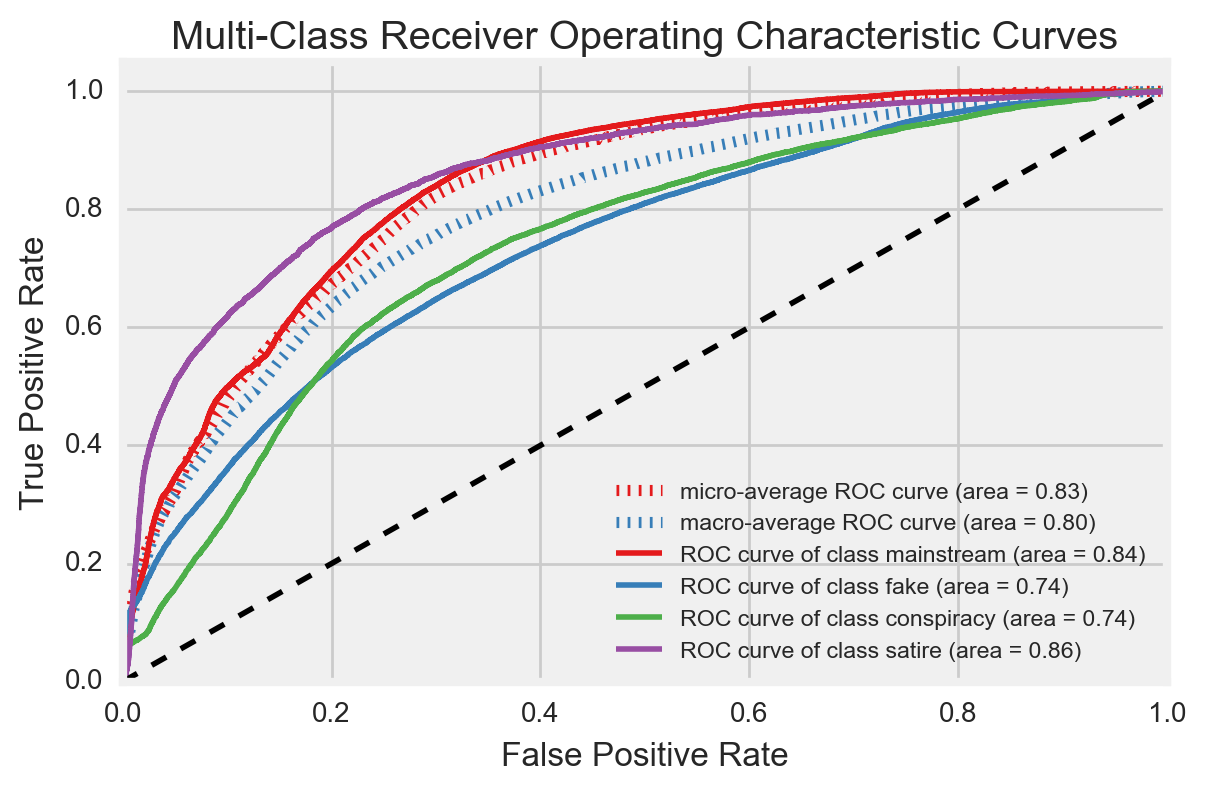

In [56]:
# Plot the ROC Curve
# The code to complete this task is a modified version of code from Scikit-Learn's website
bin_yte= label_binarize(yte, classes=[0, 1, 2, 3])
n_classes = bin_yte.shape[1]

# Retrieve the predicted probabilities and scores for the X observation matrix
y_score = logreg.fit(xtr, ytr).decision_function(xte)

# The ROC curve returns the false positive rate and true positive rates as the threshold changes
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(bin_yte[:, i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute the micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(bin_yte.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='#e41a1c', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='#377eb8', linestyle=':', linewidth=4)

colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
class_names=['mainstream','fake','conspiracy','satire']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class Receiver Operating Characteristic Curves')
plt.legend(loc="lower right",fontsize='small')
plt.show()

Confusion matrix, without normalization
[[18405  7448   109   124]
 [ 6797 26436   396   481]
 [ 2943 12462  1343   165]
 [ 1967  2381    44   885]]


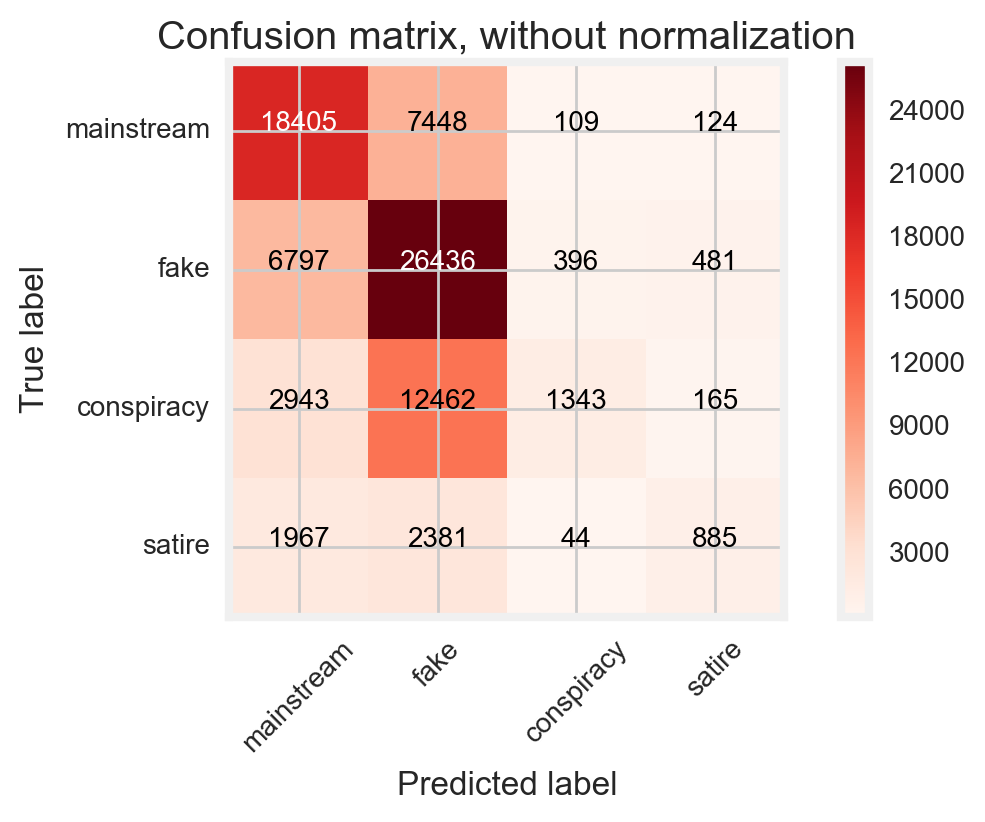

In [59]:
# Plot confusion matrix 
# The code to complete this task is a modified version of code from Scikit-Learn's website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=['mainstream','fake','conspiracy','satire']
cnf_matrix = confusion_matrix(yte, pred)
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# Test on entire dataset
logreg.fit(Xn,y)

In [ ]:
# Assebmle a matrix of the coefficients in the model and genearte a histogram of only the coefficients
# with the highest absolute values, i.e. those above 0.15
coefs = pd.DataFrame(logreg.coef_, columns=coefs_columns)
coefs.index = list(fb_news_total['type'].unique())
log_reg_coefs=coefs.transpose().reset_index()
log_reg_coefs.rename(index=str, columns={"index":"predictors"},inplace=True)
log_reg_coefs=pd.melt(log_reg_coefs, id_vars=['predictors'], value_vars=['mainstream', 'fake','conspiracy','satire'])

In [ ]:
# Plot histogram of the greatest absolute value of the coefficients
log_reg_coefs.ix[log_reg_coefs['value'].abs()>0.2,'value'].hist(bins=50)

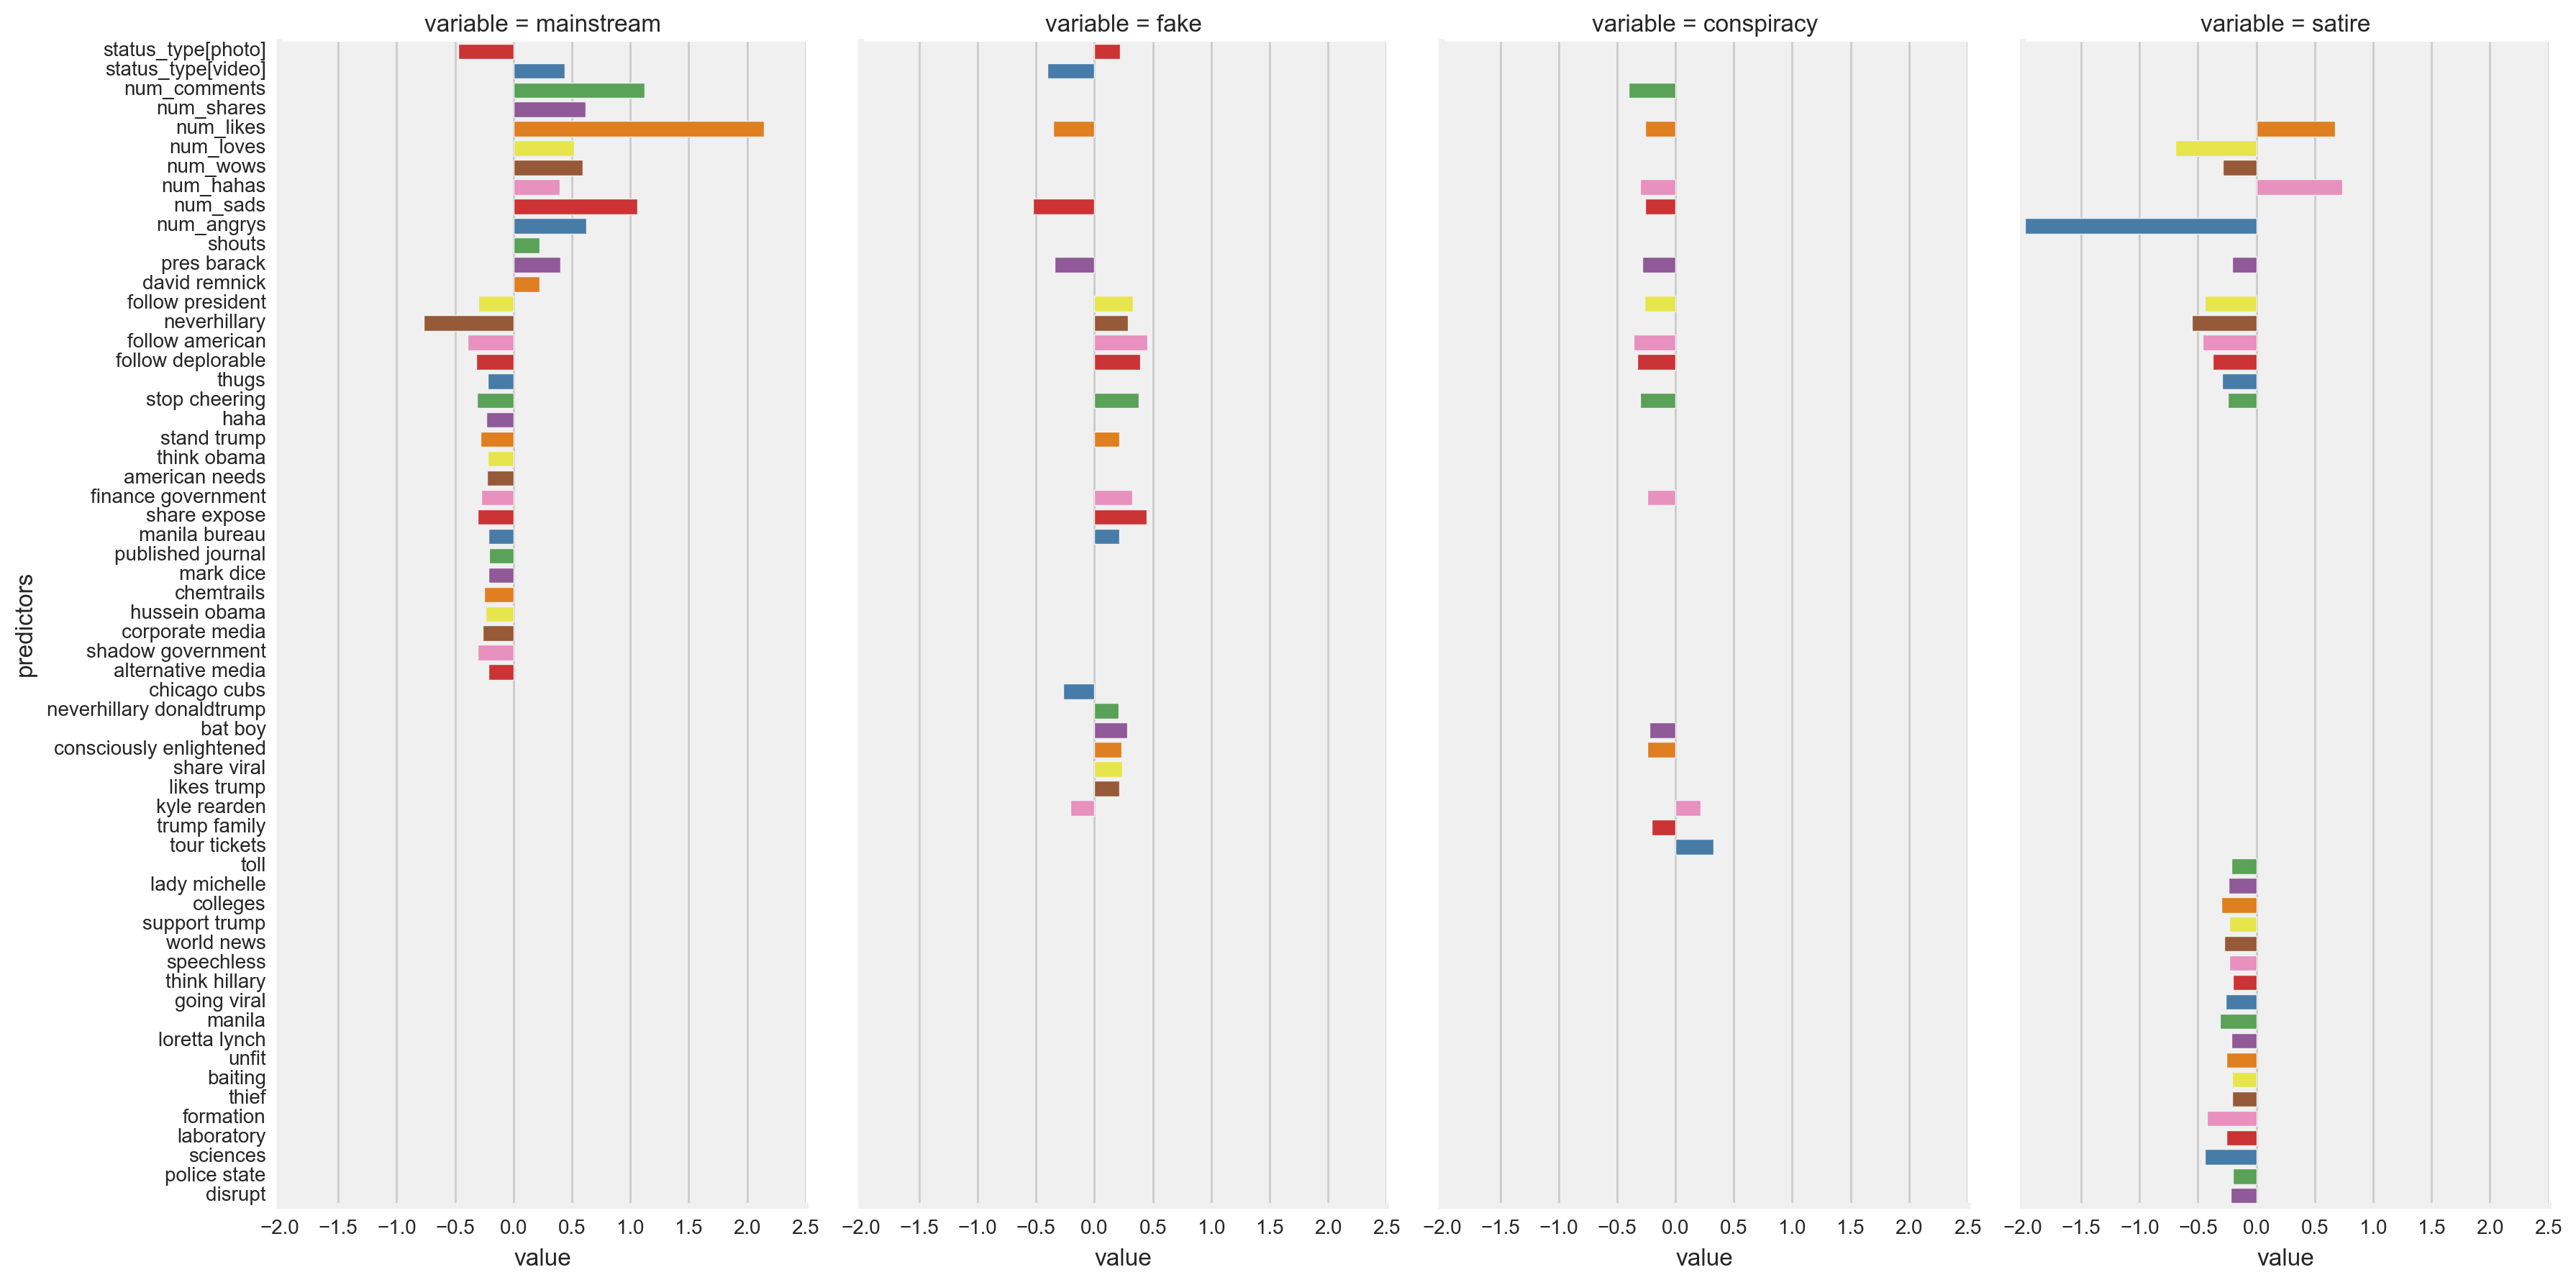

In [77]:
# Generate a plot with the greatest absolute values
sns.factorplot(x='value', y='predictors', data=log_reg_coefs[log_reg_coefs['value'].abs()>0.2], col="variable",kind='bar',size=9, aspect=.5,palette=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf']);

## Conclusions

## Further Work

- Build a model using a more evenly sampled or use re-sampling techniques to correct sample skew of the
existing dataset
- Calibrate and verify the model using more posts in more U.S. news as well as foreign sources (Do proxies stand?)
- Vary number and types of words from message text used in the model. Possibly include n-grams of link names. 
- Examine the content of the pre-categorized posts in the dataset and, if necessary, correct the label. 
- Evaluate other feature engineering options to compare against the  performance of Lasso
- Use GridSearch to vary C parameter

<img src="https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png" style="float: left; margin: 10px;">

# Intro to Natural Language Processing
Week 6| Lesson 4.1


![](https://snag.gy/uvESGH.jpg)

# NLP Project:  Rapstats.io

<a href="http://rapstats.io"><img src="https://snag.gy/8GSVqf.jpg"></a>

<img src="https://snag.gy/8eJNFv.jpg" style="width: 300px; float: left;">
<img src="https://snag.gy/2Hz0o7.jpg" style="width: 300px;">

See Also:

- [Largest Vocabulary in Hip Hop](http://poly-graph.co/vocabulary.html)
- [Rap Genius: Rapstats](http://genius.com/rapstats)
- [Rap Lyric Generator, Hieu Nguyen, Brian Sa](http://nlp.stanford.edu/courses/cs224n/2009/fp/5.pdf)

### LEARNING OBJECTIVES
*After this lesson, you will be able to:*
- Extract features from unstructured text using Scikit Learn
- Identify Parts of Speech using NLTK
- Remove stop words
- Describe how TFIDF works

### LESSON GUIDE
| TIMING  | TYPE  | TOPIC  |
|:-:|---|---|
| 10 min | [Opening](#opening) | Opening |
| 10 min | [Introduction](#introduction) | Feature Extraction from Text |
| 10 min | [Demo](#demo) | Demo: Scikit Learn Count Vectorizer |
| 10 min | [Guided](#guided_practice) | Scikit Learn Hashing Vectorizer |
| 15 mins | [Introduction](#introduction_2) | Intro: Natural Language Processing |
| 15 mins | [Demo](#demo_2) | Demo: Advanced NLP with NLTK |
| 10 mins | [Guided-practice](#guided-practice_2) | Term frequency - Inverse document Frequency |
| 5 mins | [Conclusion](#conclusion) | Conclusion |

## 1. Vectorize your corpus using TfidfVectorizer and set to a variable called "X"
1. Initialize TfidfVectorizer to a new variable.
1. Set X to the return of fit_transform.

## 5. Refactor your existing code into a function.
- Your method should accept a corpus object, a vectorizer type (tfidf or countvectorizer), and aggregate function parameter (string or function -- your choice!).
- Your method should output a figure

An example use case of your code would be:
> ```python
>  corpus = ["I am a rat", "I am a cat", "I am a bat"]
>
>  # TFIDF plot with max aggregation
>  vectorize_and_plot(corpus, vectorizer="tfidf", agg_func="max")
>  [your plot here] 
>
>  # COUNT plot with max aggreagation
>  vectorize_and_plot(corpus, vectorizer="count", agg_func="max")
>  [your plot here] 
>  ```

_This is not a real-world probem but hopefully you get a sense of the basics of looking at text data, and it's application in sklearn._

### A Simple Example
Suppose we are building a spam/ham classifier. Input are emails, output is a binary classification.

Here's an example of an input email:


```python
spam = """
Hello,\nI saw your contact information on LinkedIn. I have carefully read through your profile and you seem to have an outstanding personality. This is one major reason why I am in contact with you. My name is Mr. Valery Grayfer Chairman of the Board of Directors of PJSC "LUKOIL". I am 86 years old and I was diagnosed with cancer 2 years ago. I will be going in for an operation later this week. I decided to WILL/Donate the sum of 8,750,000.00 Euros(Eight Million Seven Hundred And Fifty Thousand Euros Only etc. etc.
"""

ham = """
Hello,\nI am writing in regards to your application to the position of Data Scientist at Hooli X. We are pleased to inform you that you passed the first round of interviews and we would like to invite you for an on-site interview with our Senior Data Scientist Mr. John Smith. You will find attached to this message further information on date, time and location of the interview. Please let me know if I can be of any further assistance. Best Regards.
"""
print spam
print
print ham
```


<a name="demo"></a>
## Demo: Scikit Learn Count Vectorizer (10 min)

Scikit-learn offers a `CountVectorizer` with many configurable options:


```python
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
```


```python
cvec = CountVectorizer()
cvec.fit([spam])
```




    CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
            dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
            lowercase=True, max_df=1.0, max_features=None, min_df=1,
            ngram_range=(1, 1), preprocessor=None, stop_words=None,
            strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
            tokenizer=None, vocabulary=None)




```python
df  = pd.DataFrame(cvec.transform([spam]).todense(),
             columns=cvec.get_feature_names())

df.transpose().sort_values(0, ascending=False).head(10).transpose()
```




<div>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>of</th>
      <th>and</th>
      <th>your</th>
      <th>contact</th>
      <th>is</th>
      <th>in</th>
      <th>have</th>
      <th>euros</th>
      <th>the</th>
      <th>this</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>4</td>
      <td>3</td>
      <td>2</td>
      <td>2</td>
      <td>2</td>
      <td>2</td>
      <td>2</td>
      <td>2</td>
      <td>2</td>
      <td>2</td>
    </tr>
  </tbody>
</table>
</div>



Note that there are several parameters to tweak.

<a name="guided-practice_2"></a>
## Term frequency - Inverse document Frequency (10 mins-ish)

More interesting than stop-words is the tf-idf score. This tells us which words are most discriminating between documents. Words that occur a lot in one document but doesn't occur in many documents will tell you something special about the document.

- This weight is a statistical measure used to evaluate how important a word is to a document in a collection (aka corpus)
- The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.

Let's see how it is calculated.

Term frequency tf is the frequency of a certain term in a document:

$$
\mathrm{tf}(t,d) = \frac{N_\text{term}}{N_\text{terms in Document}}
$$

Inverse document frequency is defined as the frequency of documents that contain that term over the whole corpus.

$$
\mathrm{idf}(t, D) = \log\frac{N_\text{Documents}}{N_\text{Documents that contain term}}
$$

Term frequency - Inverse Document Frequency is calculated as:

$$
\mathrm{tfidf}(t,d,D) = \mathrm{tf}(t,d) \cdot \mathrm{idf}(t, D)
$$


<Br><br>
![](https://snag.gy/rBNLtd.jpg)

This enhances terms that are highly specific of a particular document, while suppressing terms that are common to most documents.

> **Someone will ask:  "But what is log used for!?"**<br>
> Good question!  This is a sublinear transformation that helps separate our extremes between rare and common values.

> "...any linear function ${\displaystyle g}$, for sufficiently large input ${\displaystyle f} $ grows slower than ${\displaystyle g}$" -Wikipedia

### ADDITIONAL RESOURCES

- [Count Vectorizer Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
- [Choosing a Stemmer](https://www.elastic.co/guide/en/elasticsearch/guide/current/choosing-a-stemmer.html)
- [Feature Hashing](https://en.wikipedia.org/wiki/Feature_hashing)
- [Term Frequency Inverse Document Frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)
- [TFIDF Vectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [ ]:
<img src="General_Assembly_DSI.jpg" />